# C3RO Demographics Analysis Statistics Code

Perform exploratory analysis and specific statistical analysis for manuscript.

Code Authors: Kareem A. Wahid and Serageldin Kamel. 

Last edited by Kareem Wahid on Januaray, 06, 2022.

Important notes: 

This notebook is dependent on the existance of CSV files from Base_file_generation.ipynb code. The files are provided in the GitHub repo (or you can recreate them yourself if you have access to the NIfTI images and structure sets). 

As one can expect the Bayesian sampling process has an intrinsic random element. Besides setting random seeds, there is some package dependency to ensure complete reproducibility of numeric results of the Bayesian regression with the results of the manuscript. To ensure exact reproducibility one should use the associated YAML file to conda install a duplicate of the conda enviornment used to generate this code (i.e., exact Python library versions). Unfortunatley, this can only be done on a Windows OS distribution since some of the conda packages used specific build hash's native only to Windows. Exact decimal level reproduciblity precision cannot be ensured if you run this code on a different OS. 

## Table of Contents
- [Dependencies and Configuration](#config)
- [Initial Data Exploration and Preprocessing](#explore)
- [Direct Comparison Barplots](#compare_plots)
- [Grouped Data Analyses](#group)
- [Bayesian Regression Analysis](#bayes)
- [Results Harmonization and Pivoting](#result)


## Dependencies and Configuration <a class="anchor" id="config"></a>
### Description:
- Imports necessary Python libraries and modules for data processing, visualization, and statistical analysis.
- Sets up configurations to suppress specific warnings for a cleaner output.

In [1]:
# Importing necessary libraries and modules

# Basic utilities and data manipulation
import os
import pandas as pd
import numpy as np

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
import seaborn as sns

# Mathematical operations
import math

# Bayesian statistical modeling
import bambi as bmb # pip install bambi
import arviz as az

# Suppress specific warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')  # Suppress irrelevant pandas copyset warnings for cleaner notebook

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Initial Data Exploration and Preprocessing <a class="anchor" id="explore"></a>
### Description
- Loads datasets for different medical sites from the `csv_files` directory.
- Handles data preprocessing tasks such as removing duplicates, filtering specific records, and renaming columns for clarity.
- Visualizes correlations in the data using heatmaps.
- Generates summary statistics for each disease site.


Breast
(94, 37)
Unique observers 94


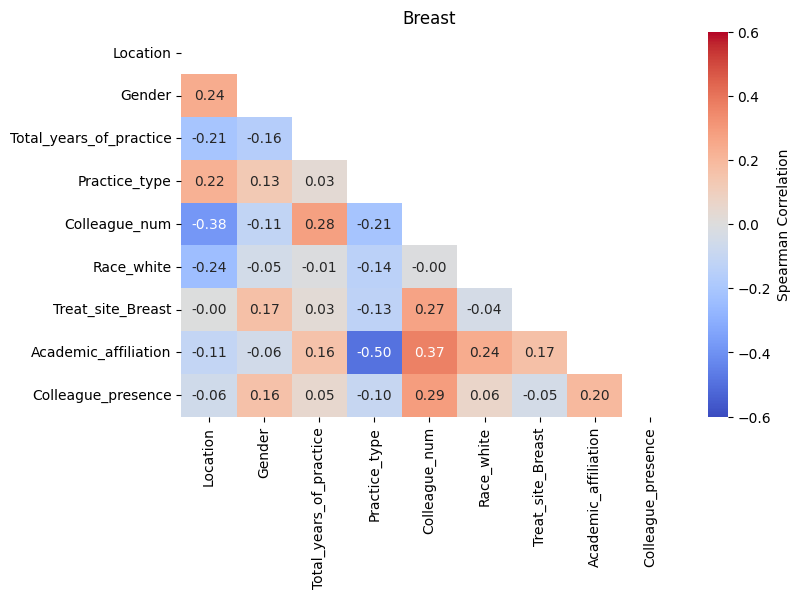

Numerical Summary for Breast


Q1 (25th)  Median  Q3 (75th)
Total_years_of_practice        3.0     6.0       10.0
Colleague_num                  2.0     5.0       11.0

Categorical Summary for Breast


0         1
Location              0.872340  0.127660
Gender                0.393617  0.606383
Practice_type         0.542553  0.457447
Race_white            0.436170  0.563830
Treat_site_Breast     0.914894  0.085106
Academic_affiliation  0.521277  0.478723
Colleague_presence    0.191489  0.808511

Sarcoma
(42, 37)
Unique observers 42


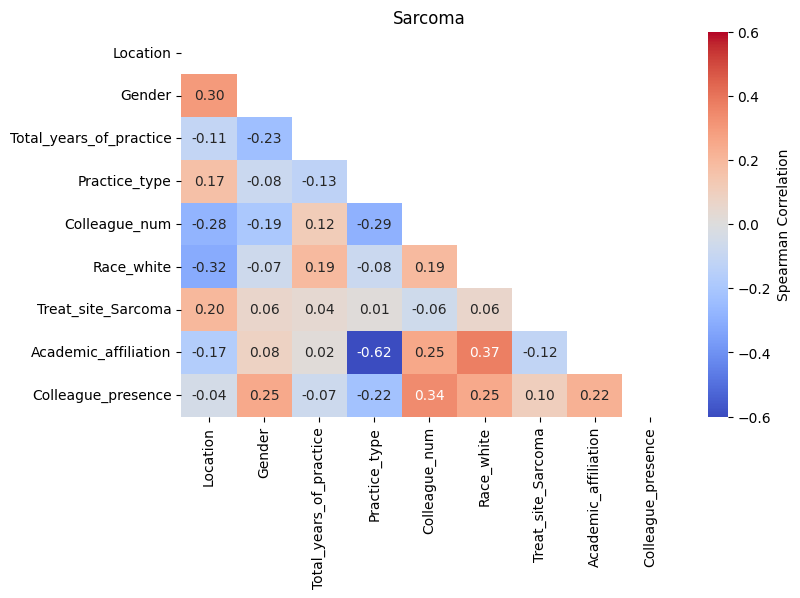

Numerical Summary for Sarcoma


Q1 (25th)  Median  Q3 (75th)
Total_years_of_practice        3.0     7.0       11.5
Colleague_num                  2.0     4.0       10.0

Categorical Summary for Sarcoma


0         1
Location              0.809524  0.190476
Gender                0.428571  0.571429
Practice_type         0.547619  0.452381
Race_white            0.428571  0.571429
Treat_site_Sarcoma    0.690476  0.309524
Academic_affiliation  0.452381  0.547619
Colleague_presence    0.214286  0.785714

H&N
(50, 37)
Unique observers 50


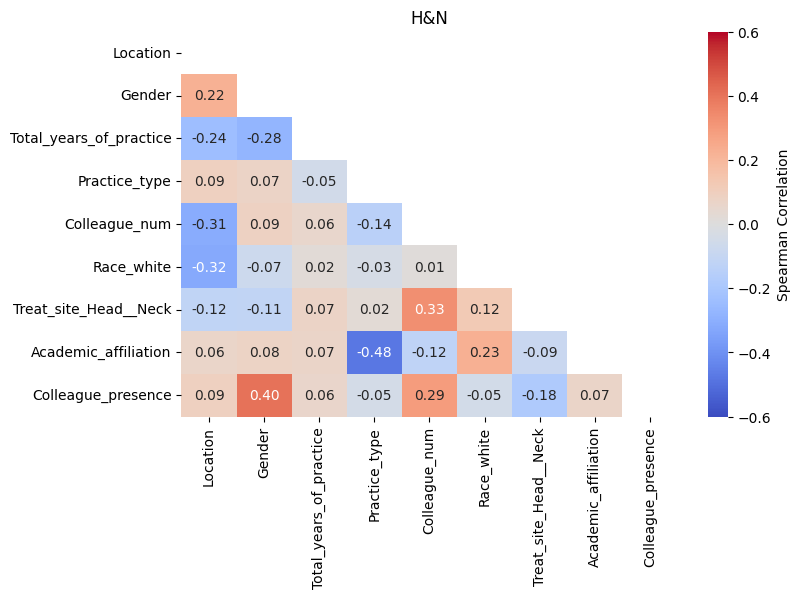

Numerical Summary for H&N


Q1 (25th)  Median  Q3 (75th)
Total_years_of_practice       2.25     6.5       11.0
Colleague_num                 2.00     5.0       10.0

Categorical Summary for H&N


0     1
Location               0.86  0.14
Gender                 0.56  0.44
Practice_type          0.54  0.46
Race_white             0.46  0.54
Treat_site_Head__Neck  0.92  0.08
Academic_affiliation   0.36  0.64
Colleague_presence     0.24  0.76

GYN
(32, 37)
Unique observers 32


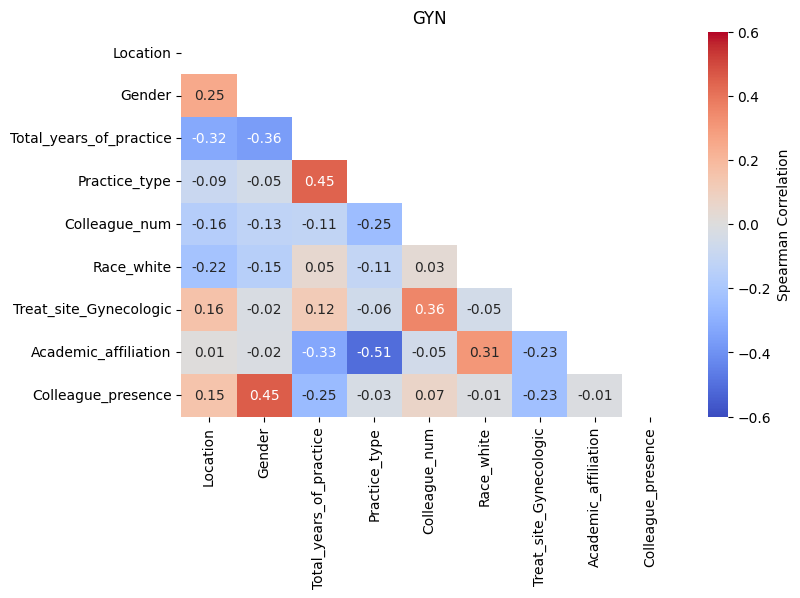

Numerical Summary for GYN


Q1 (25th)  Median  Q3 (75th)
Total_years_of_practice        4.0     6.5      12.50
Colleague_num                  2.0     5.0      10.25

Categorical Summary for GYN


0        1
Location                0.90625  0.09375
Gender                  0.37500  0.62500
Practice_type           0.53125  0.46875
Race_white              0.34375  0.65625
Treat_site_Gynecologic  0.84375  0.15625
Academic_affiliation    0.34375  0.65625
Colleague_presence      0.18750  0.81250

GI
(17, 37)
Unique observers 17


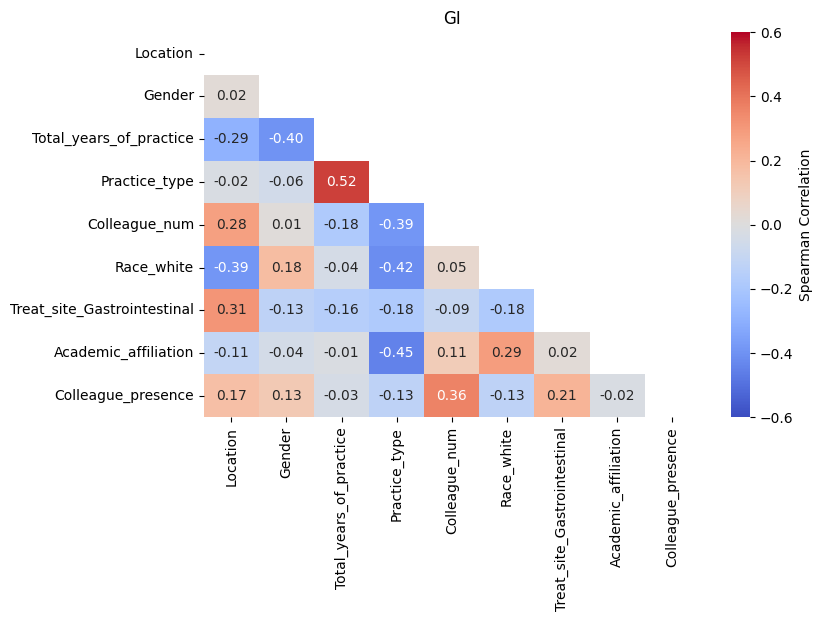

Numerical Summary for GI


Q1 (25th)  Median  Q3 (75th)
Total_years_of_practice        4.0     8.5      15.25
Colleague_num                  2.0     4.0      10.00

Categorical Summary for GI


0         1
Location                     0.882353  0.117647
Gender                       0.529412  0.470588
Practice_type                0.470588  0.529412
Race_white                   0.470588  0.529412
Treat_site_Gastrointestinal  0.823529  0.176471
Academic_affiliation         0.352941  0.647059
Colleague_presence           0.176471  0.823529

In [2]:
# Constants and configurations for initial exploratory analysis
DATA_PATH = 'csv_files'
SITE_LIST = ['Breast', 'Sarcoma', 'H&N', 'GYN', 'GI']

# Dictionary to map site names to their corresponding choice values
CHOICE_MAPPING = {
    "Breast": "Breast",
    "Sarcoma": "Sarcoma",
    "H&N": "Head__Neck",
    "GYN": "Gynecologic",
    "GI": "Gastrointestinal"
}

# Load all datasets once and store in a dictionary for efficient access
dataframes = {}
for site in SITE_LIST:
    file_path = os.path.join(DATA_PATH, f"{site}.csv")
    if os.path.exists(file_path):
        dataframes[site] = pd.read_csv(file_path)
    else:
        print(f"Error: {file_path} does not exist!")

# Iterate over each site to analyze and visualize the data
for site in SITE_LIST:
    print(site)
    
    # Access the pre-loaded data for the current site
    site_df = dataframes[site]

    # Pre-process the dataset
    # Remove any duplicate records based on 'Record_ID', retaining only the first instance
    site_df.drop_duplicates(subset='Record_ID', keep='first', inplace=True)

    # Convert practice type to a simpler binary form and filter records
    site_df['Practice_type'] = np.where(site_df['Practice_type'] == 'Academic/university', 'Academic', 'Non-academic')
    site_df = site_df[site_df['What_is_your_profession'] == 'Radiation Oncologist/Clinical Oncologist']

    # Drop unnecessary columns in one go
    drop_columns = [
        'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceOpportunity_to_win_gift_cards',
        'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceComparison_to_peersleaderboard',
        'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceAccess_to_educational_content',
        'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceAccess_to_contour_datasets_for_guidelineresearch_purposes',
        'How_did_you_first_hear_about_this_challenge__Select_all_that_apply',
        'Please_specify_Other',
        'What_year_of_residency_are_you_in',
        'What_year_did_you_start_practicing_graduate_residency',
        'What_is_your_profession'
    ]
    site_df.drop(labels=drop_columns, axis=1, inplace=True)   

    # Informational prints
    print(site_df.shape)  # check size
    print('Unique observers', len(site_df['Record_ID'].unique()))

    # Map the site to its corresponding choice value and select relevant columns
    choice = CHOICE_MAPPING.get(site, site)
    site_treat = f"Treat_site_{choice}"
    selected_columns = [
        'Location', 'Gender', 'Total_years_of_practice', 'Practice_type',
        'Colleague_num', 'Race_white',  site_treat,
        'Academic_affiliation', 'Colleague_presence'
    ]
    df_selected = site_df[selected_columns].copy()

    # Convert categorical labels to numerical codes for analysis
    for col in df_selected.columns:
        if df_selected[col].dtype == 'object': 
            df_selected[col] = df_selected[col].astype('category').cat.codes

    # Plotting the correlation heatmap
    plt.figure(figsize=(8, 5))
    corr = df_selected.corr(method='spearman')
    mask = np.triu(np.ones_like(corr, dtype=bool))
    heatmap = sns.heatmap(corr, annot=True, vmin=-0.6, vmax=0.6, fmt=".2f", cmap='coolwarm', mask=mask)
    plt.gca().collections[0].colorbar.set_label('Spearman Correlation')
    plt.title(site)
    plt.savefig(f"descriptive_stats/{site}_heatmap.pdf", bbox_inches='tight')
    plt.show()
    
    # Generating summary statistics
    numerical_columns = ['Total_years_of_practice', 'Colleague_num']
    categorical_columns = [col for col in df_selected.columns if col not in numerical_columns]

    # Summary statistics for numerical columns
    numerical_summary = df_selected[numerical_columns].describe(percentiles=[.25, .5, .75]).T[['25%', '50%', '75%']]
    numerical_summary.columns = ['Q1 (25th)', 'Median', 'Q3 (75th)']

    # Summary statistics for categorical columns
    categorical_summary = df_selected[categorical_columns].apply(lambda x: x.value_counts(normalize=True)).fillna(0).T

    # Displaying the summary statistics
    print("Numerical Summary for", site)
    display(numerical_summary)
    print("Categorical Summary for", site)
    display(categorical_summary)

    # Save the summary statistics to a CSV file
    summary = pd.concat([numerical_summary, categorical_summary], keys=['Numerical', 'Categorical'])
    summary.to_csv(f"descriptive_stats/{site}_descriptivestats_nonexperts.csv")


In [3]:
# generate summary statistics for experts specifically (above code only for non-experts)

data_path = "Z:\\Kareem\\C3RO\\data_descriptor\\Organized_files_v4" # path to the data (top-level folder) from Figshare here
excel_file_path = os.path.join(data_path, "C3RO_RedCap_est7.30.22.xlsx") # path to excel file with observer demographic data

# Open the Excel file
xls = pd.ExcelFile(excel_file_path)
first_five_sheets = xls.sheet_names[:5] # Get names of the first 5 sheets

# Dictionary to store DataFrames from each sheet
sheets_dict = {sheet_name: xls.parse(sheet_name) for sheet_name in first_five_sheets}

# Iterate over each sheet
for sheet_name, df in sheets_dict.items():
    print(f"Processing sheet: {sheet_name}")
    site = sheet_name.split('-')[-1].split(' ')[-1]

    ### similar code to base_file_generation_debug.ipynb
    # create total years of practice variable
    df['What year did you start practicing (graduate residency)?'] = pd.to_numeric(df['What year did you start practicing (graduate residency)?'], errors='coerce') # new, need to make sure it gives same value
    df['Total years of practice'] = 2022 - df['What year did you start practicing (graduate residency)?']
    
    # clean column names for ease of use later
    df.columns = df.columns.str.replace(' ', '_', regex=True).str.replace('\W', '', regex=True) # had to set this to true because original version didn't work from old code 
    
    df = df.rename(columns={
        'Which_best_describes_your_primary_practice_': 'Practice_type', 
        'How_many_radiation_oncologist_colleagues_do_you_work_with_at_your_primary_site_excluding_you_': 'Colleague_num', 
        'WHITE_Which_categories_describe_you___Select_all_that_apply___choiceWhite': 'Race_white', 
        'Do_you_have_an_academic_affiliation': 'Academic_affiliation',
        "On_most_days_you_are_in_clinic_is_there_another_radiation_oncologist_on_site_with_you_": 'Colleague_presence'
    })
    df.columns = df.columns.str.replace("Which_disease_sites_do_you_treat___Select_all_that_apply_choice", "Treat_site_")

    # transform academic variable to binary
    df['Practice_type'] = np.where(df['Practice_type'] == 'Academic/university', 'Academic', 'Non-academic')
    
    # remove unecessary columns
    remove_columns = [
        'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceOpportunity_to_win_gift_cards',
           'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceComparison_to_peersleaderboard',
           'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceAccess_to_educational_content',
           'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceAccess_to_contour_datasets_for_guidelineresearch_purposes',
           'How_did_you_first_hear_about_this_challenge__Select_all_that_apply',
           "Please_specify_Other",
        'What_year_of_residency_are_you_in',
        'What_year_did_you_start_practicing_graduate_residency',
                     ]
    df = df.drop(labels = remove_columns, axis=1)  
    
    #remove non-experts
    df = df[(df['Category'] == 'Expert')]

    #print(df.shape) # check size
    #print('unique obervers', len(df['Record_ID'].unique()))

    if site == "Breast" or site == "Sarcoma":
        choice = site # bad practice to reassign variables
    elif site == "H&N":
        choice = "Head__Neck" 
    elif site == "GYN":
        choice = "Gynecologic" 
    elif site == "GI":
        choice = "Gastrointestinal" 

    site_treat = "Treat_site_{0}".format(choice)

    columns_to_select = ['Location', 'Gender', 'Total_years_of_practice', 'Practice_type',
                        'Colleague_num', 'Race_white',  site_treat,
                        'Academic_affiliation', 'Colleague_presence']

    # select columns from DataFrame
    df_selected = df[columns_to_select]
    df_selected_copy = df_selected.copy()
    
    for col in df_selected.columns:
        if df_selected[col].dtype=='object':  # If variable is categorical
            df_selected[col] = df_selected[col].astype('category').cat.codes  # Convert to category codes
            
    ### SUMMARY TABLES

    # defining numerical and categorical columns
    numerical_columns = ['Total_years_of_practice', 'Colleague_num']
    categorical_columns = [col for col in columns_to_select if col not in numerical_columns]

    # creating a dataframe for numerical summary
    numerical_summary = df_selected_copy[numerical_columns].apply(lambda x: [x.median(), x.quantile(0.25), x.quantile(0.75)], axis=0).T
    numerical_summary.columns = ['Median', '25th Percentile (Q1)', '75th Percentile (Q3)']

    # creating a dataframe for categorical summary
    categorical_summary = df_selected_copy[categorical_columns].apply(lambda x: x.value_counts(normalize=True)).T

    # Concatenating the dataframes
    summary = pd.concat([numerical_summary, categorical_summary], keys=['Numerical', 'Categorical'])

    # Print the result
    #print(summary)

    # write summary file to CSV
    summary.to_csv(f"descriptive_stats/{site}_descriptivestats_experts.csv")
    

Processing sheet: Case 1 - Breast
Processing sheet: Case 2 - Sarcoma
Processing sheet: Case 3 - H&N
Processing sheet: Case 4 - GYN
Processing sheet: Case 5 - GI


## Direct Comparison Barplots <a class="anchor" id="compare_plots"></a>
### Description
- Includes direct comparisons of non-experts vs. expert STAPLE and summary statistics based on ROI.
- Compares observer performance relative to expert inter-observer variability (IOV).
- Uses seaborn to visualize DSC, SDSC, and HD95 metrics for each disease site.

Processing for metric: DSC
Processing for site: Breast


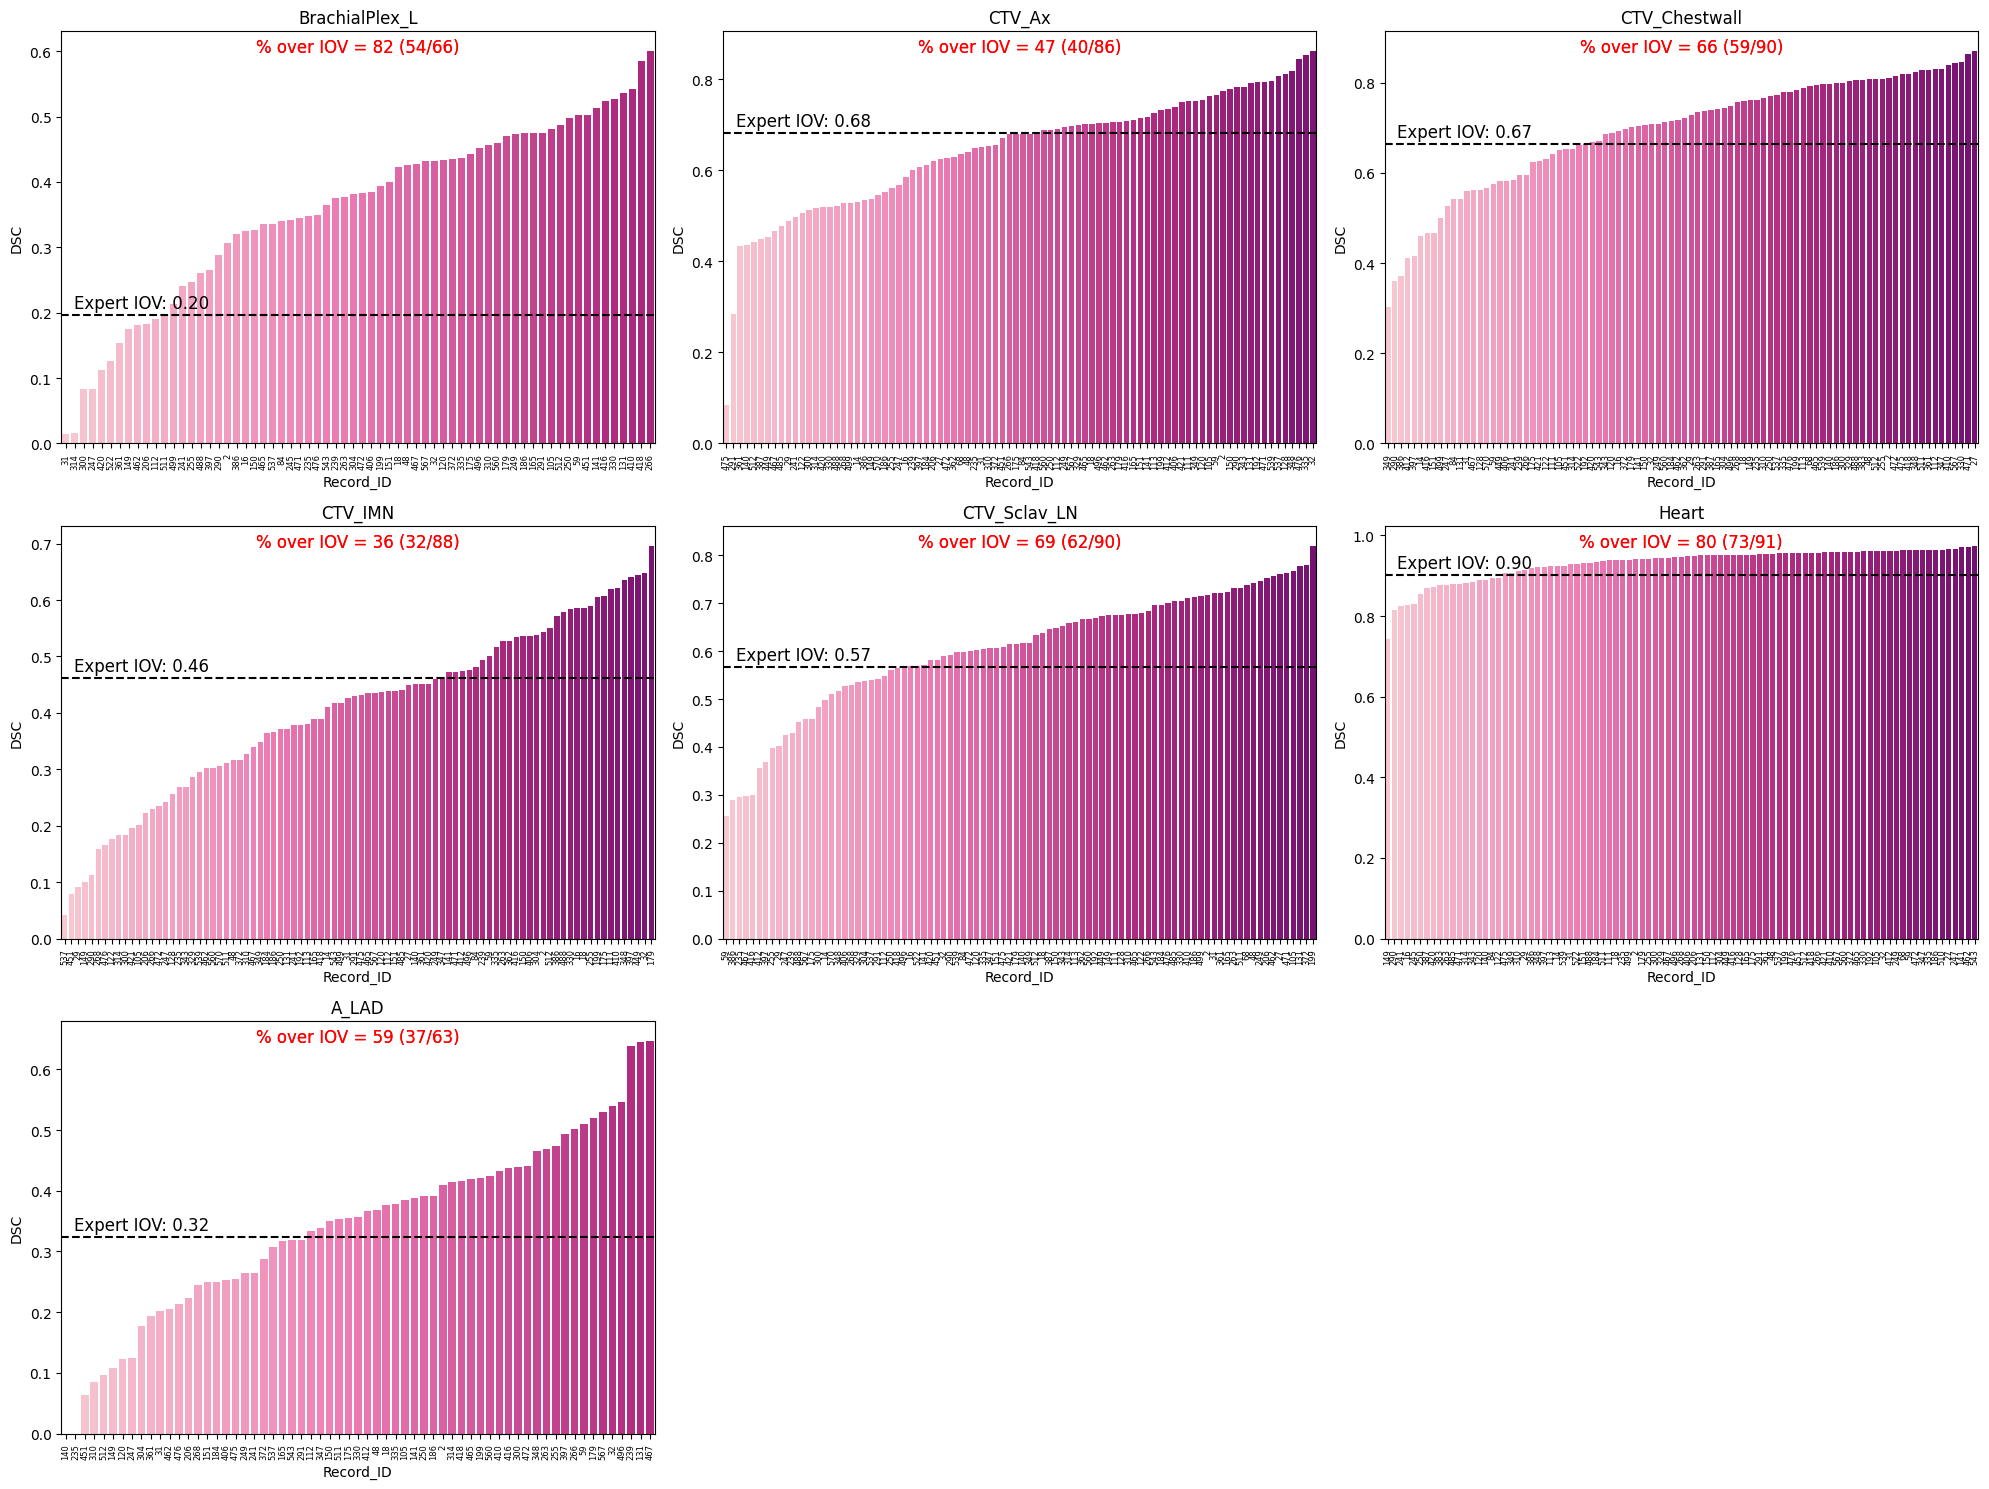

Processing for site: Sarcoma


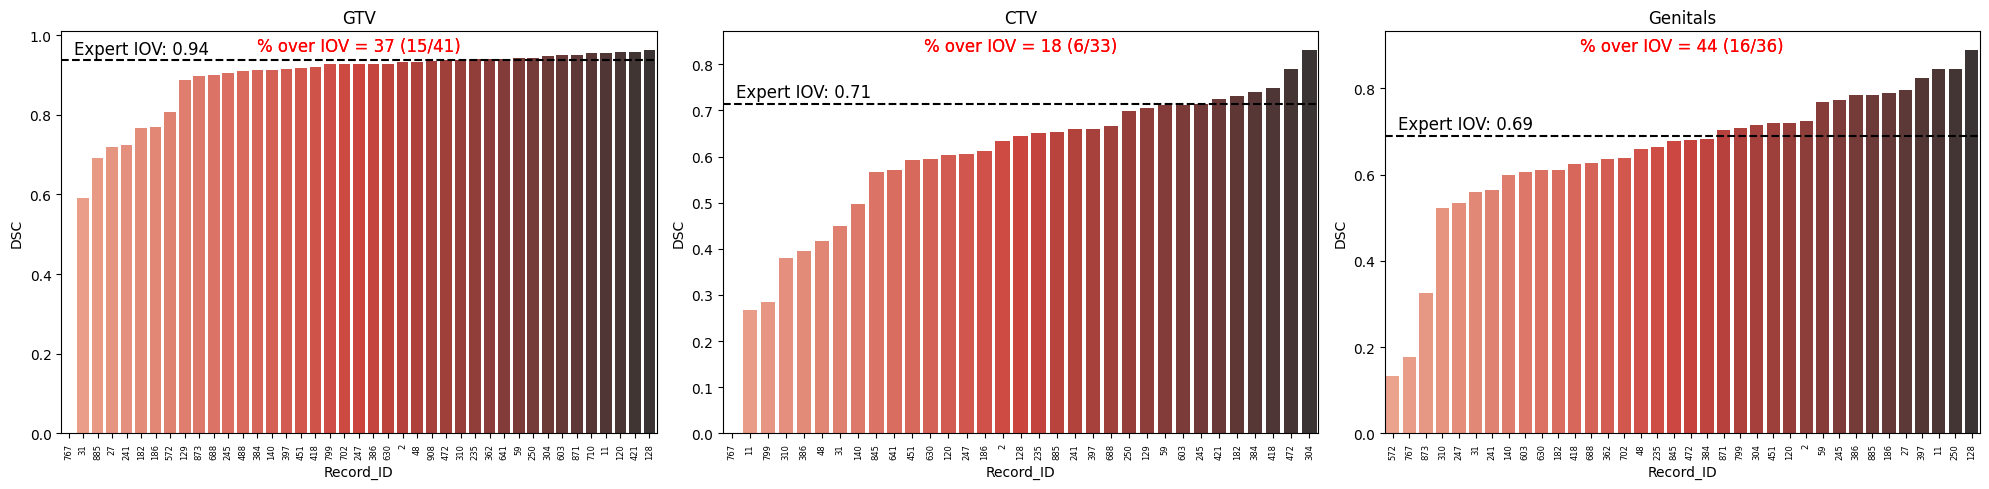

Processing for site: H&N


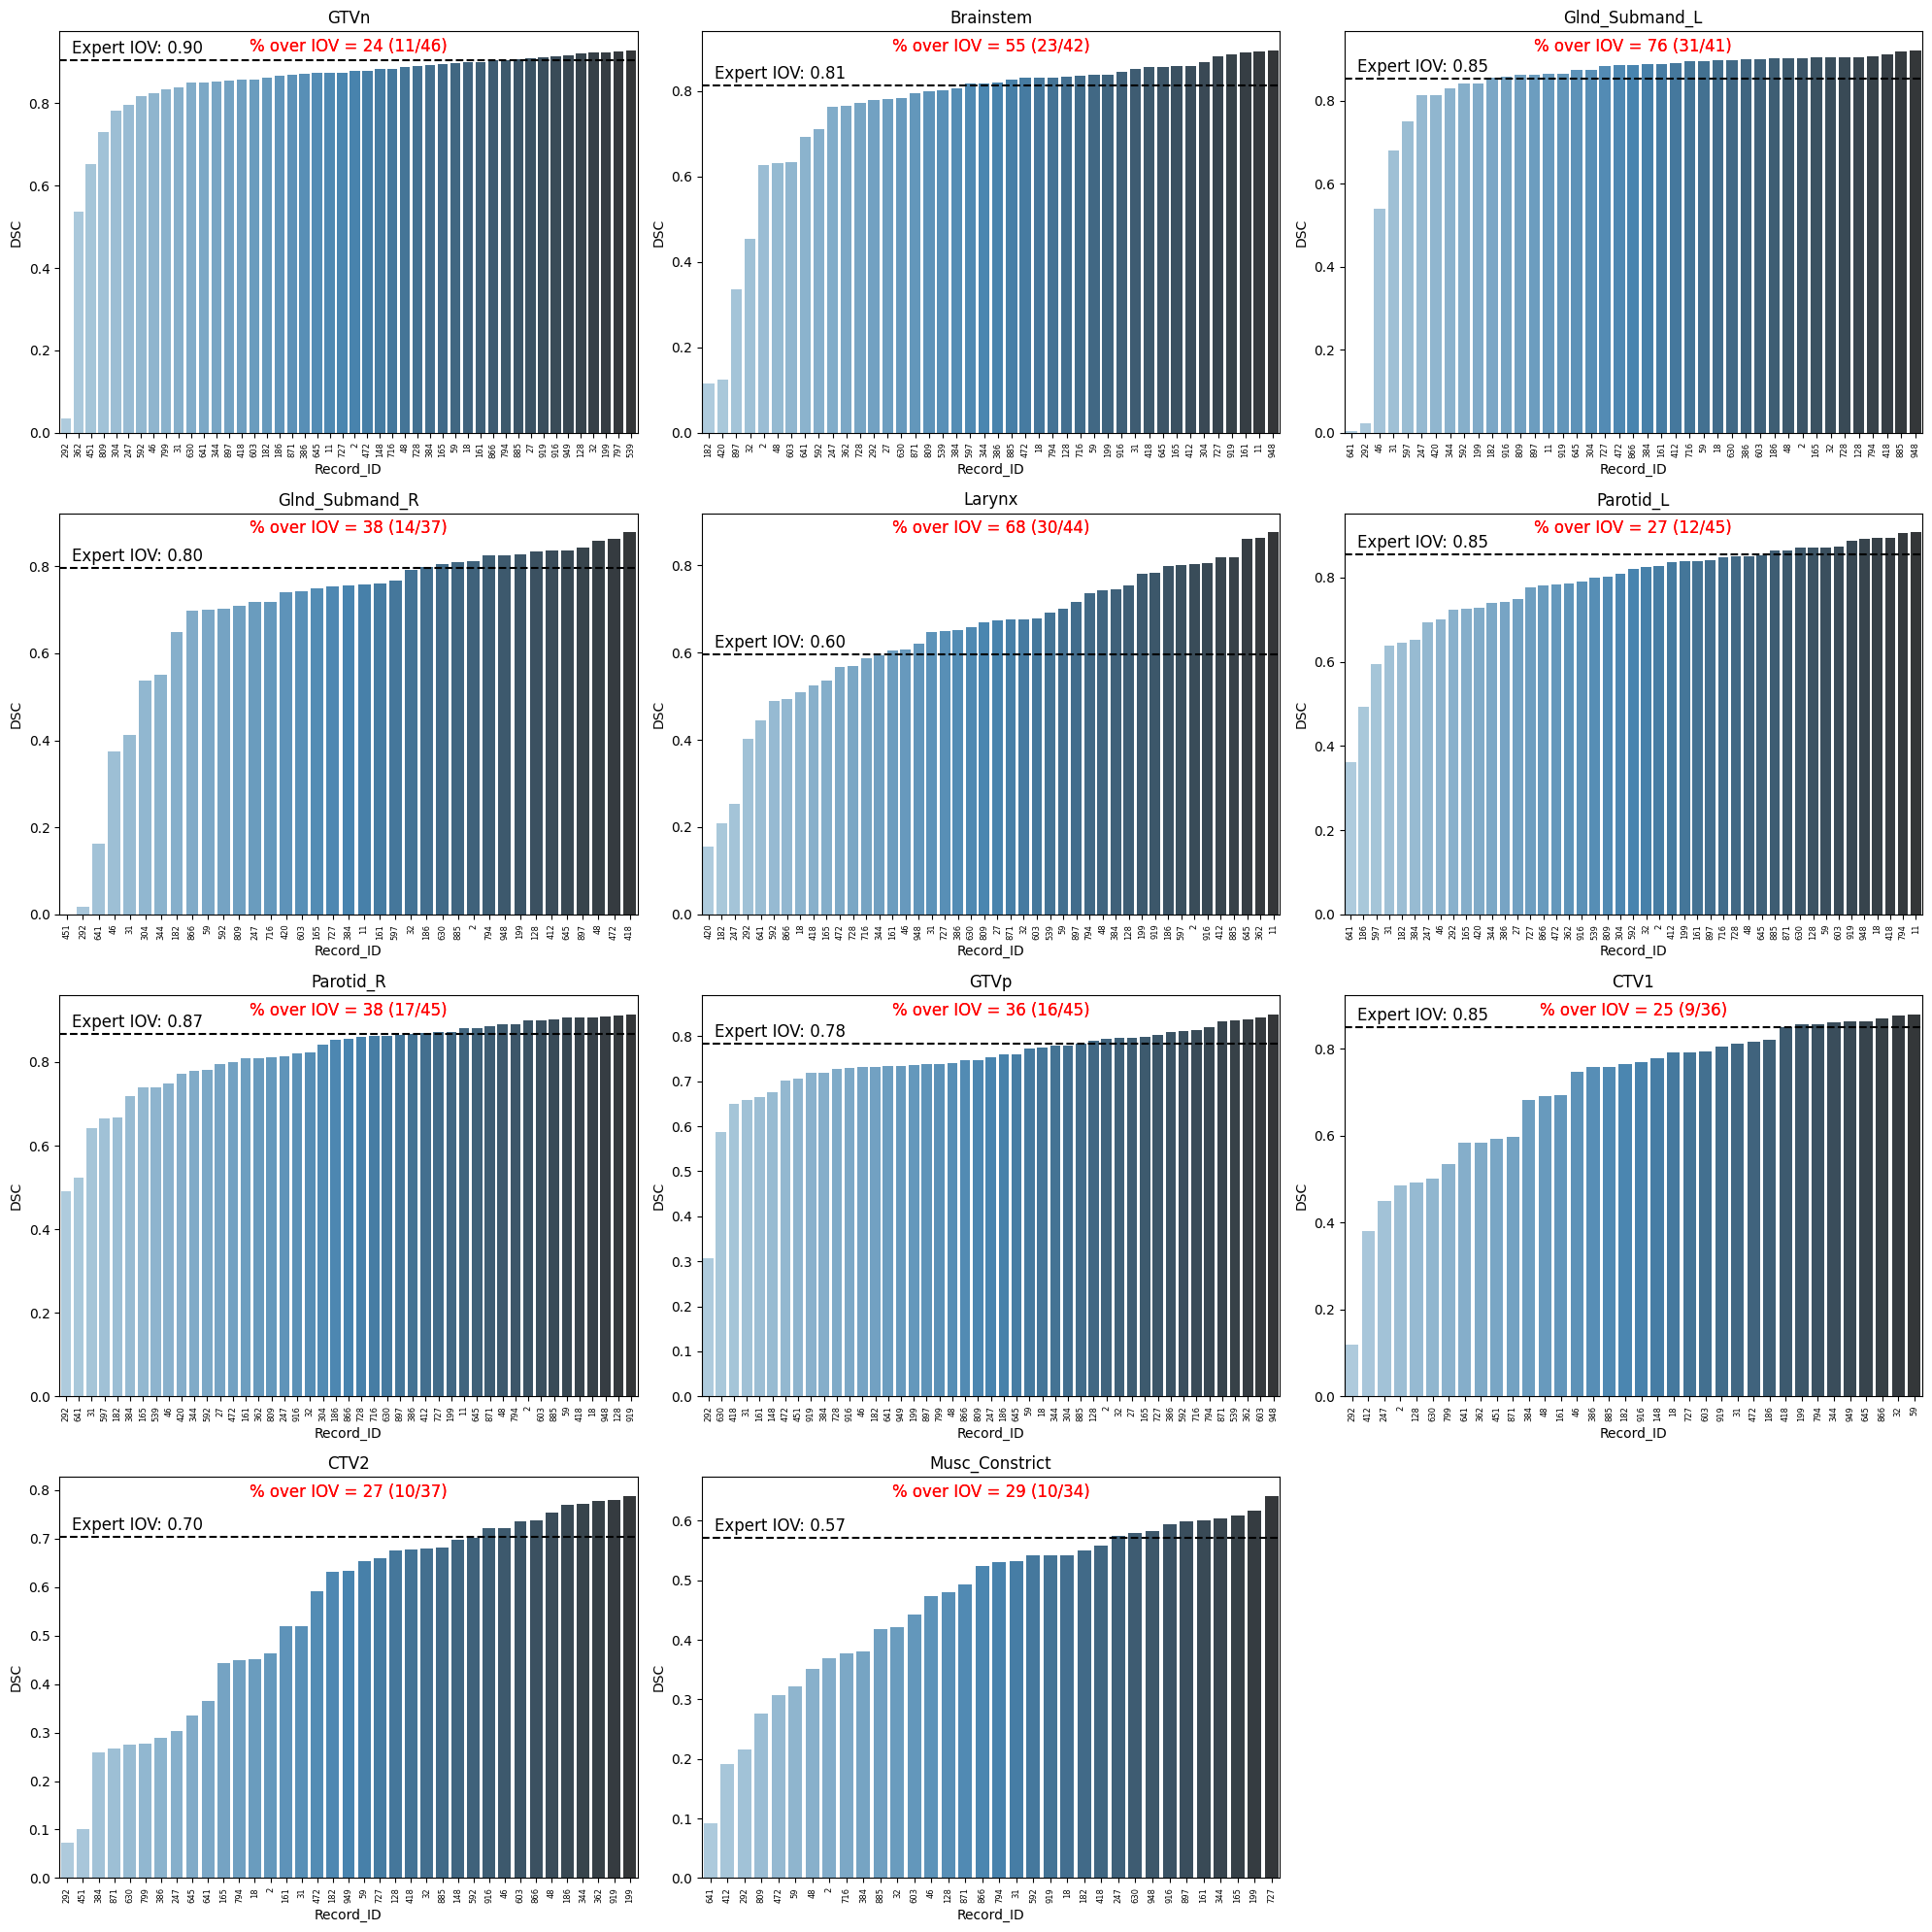

Processing for site: GYN


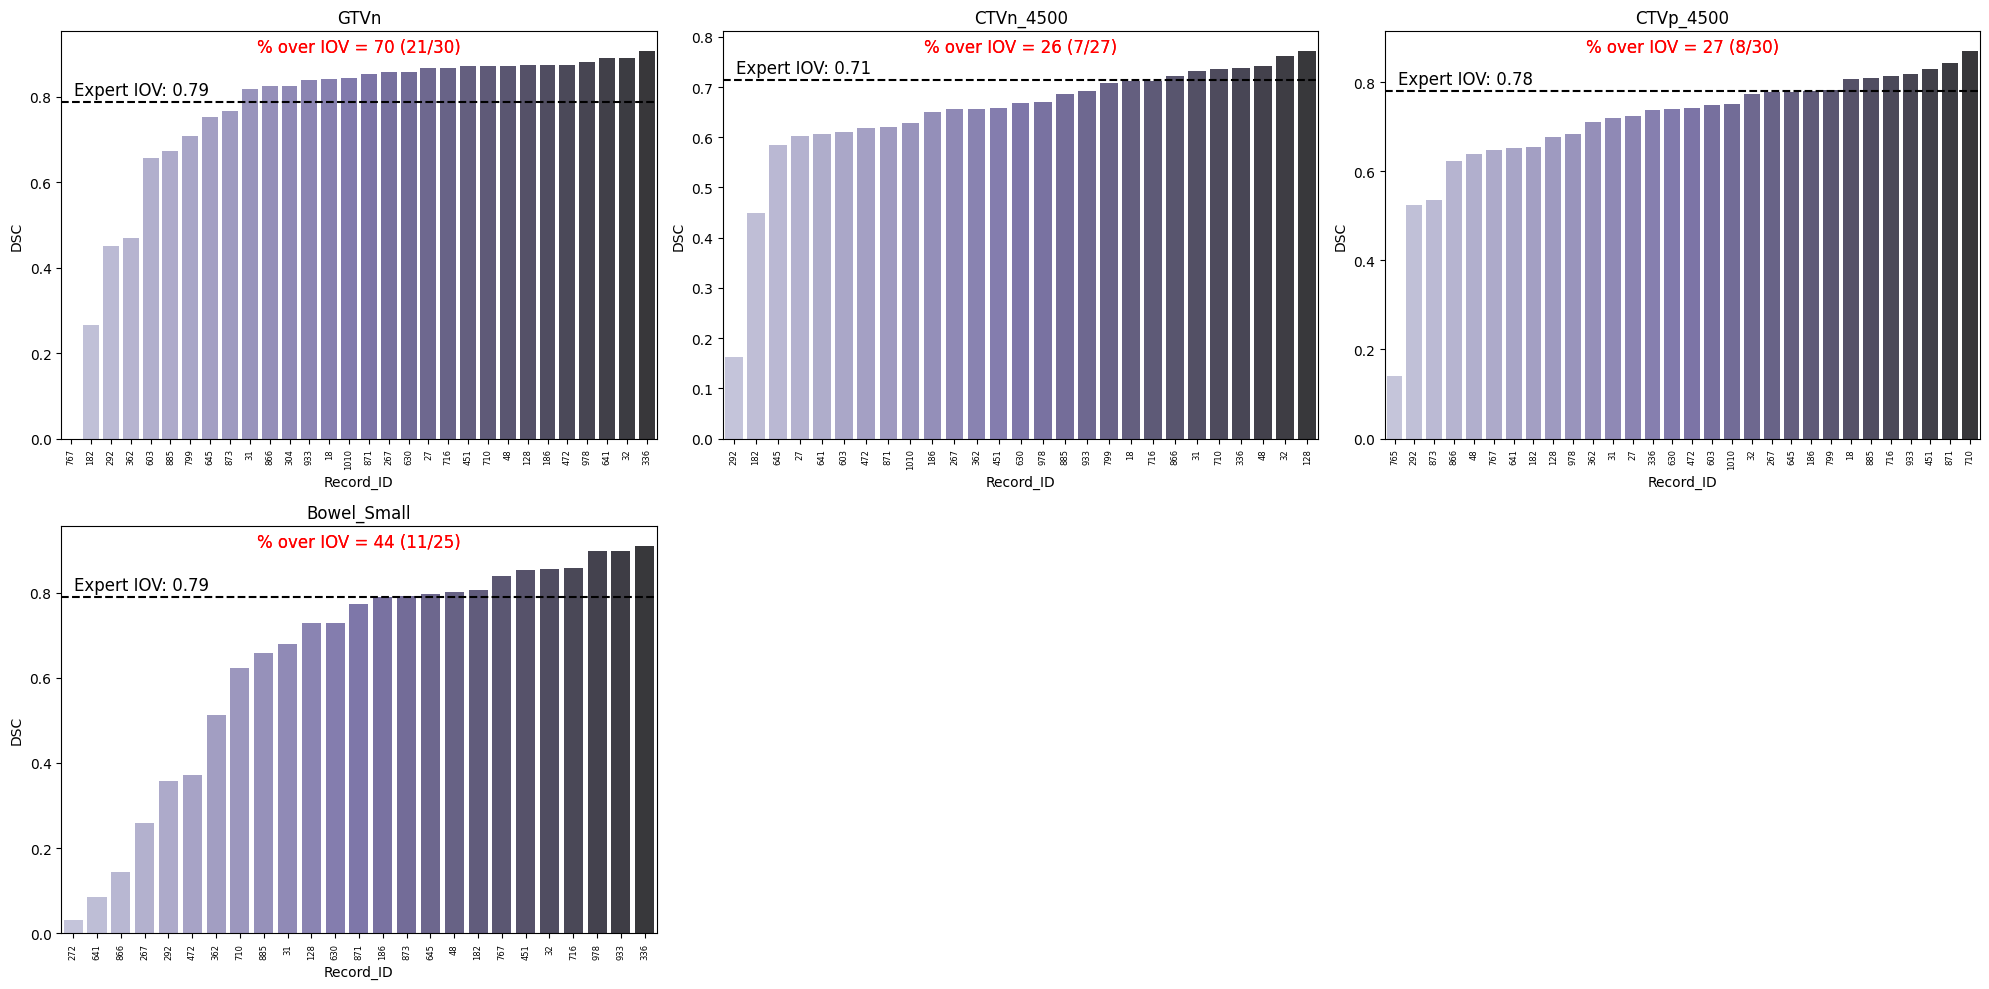

Processing for site: GI


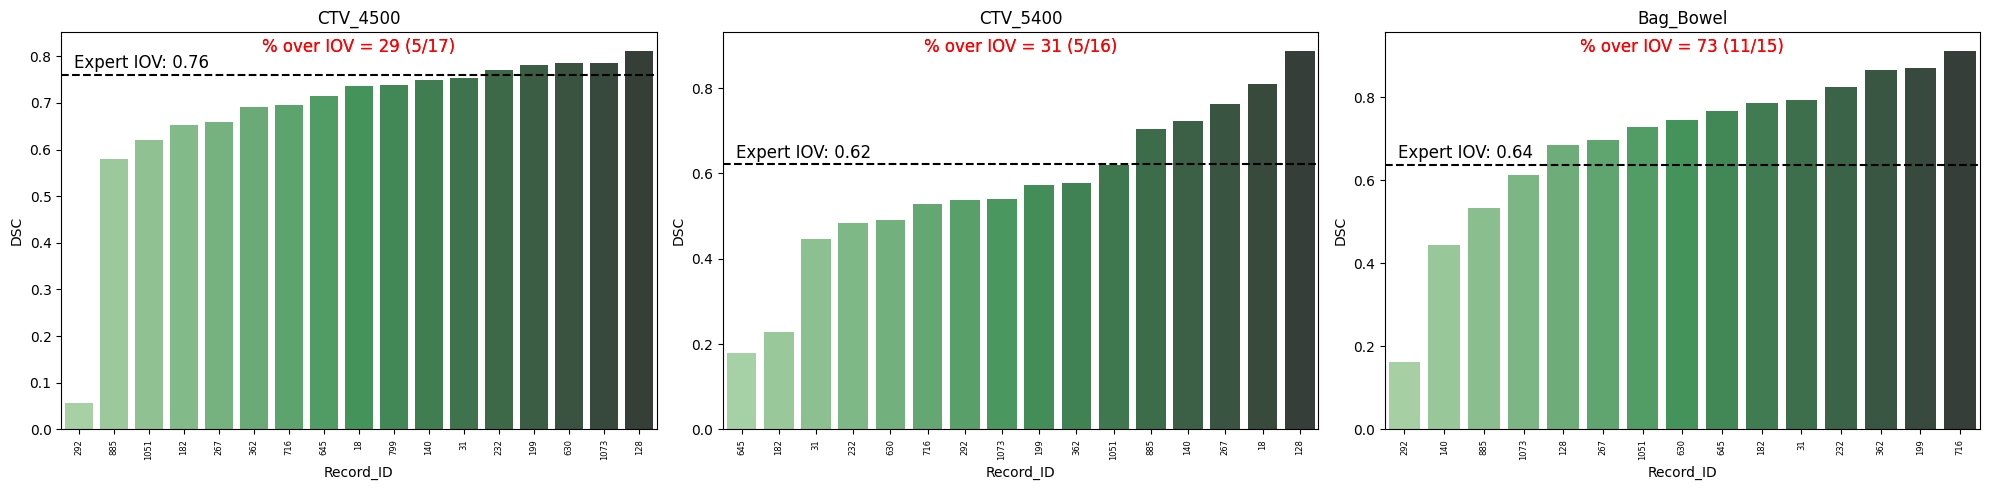

Processing for metric: SDSC
Processing for site: Breast


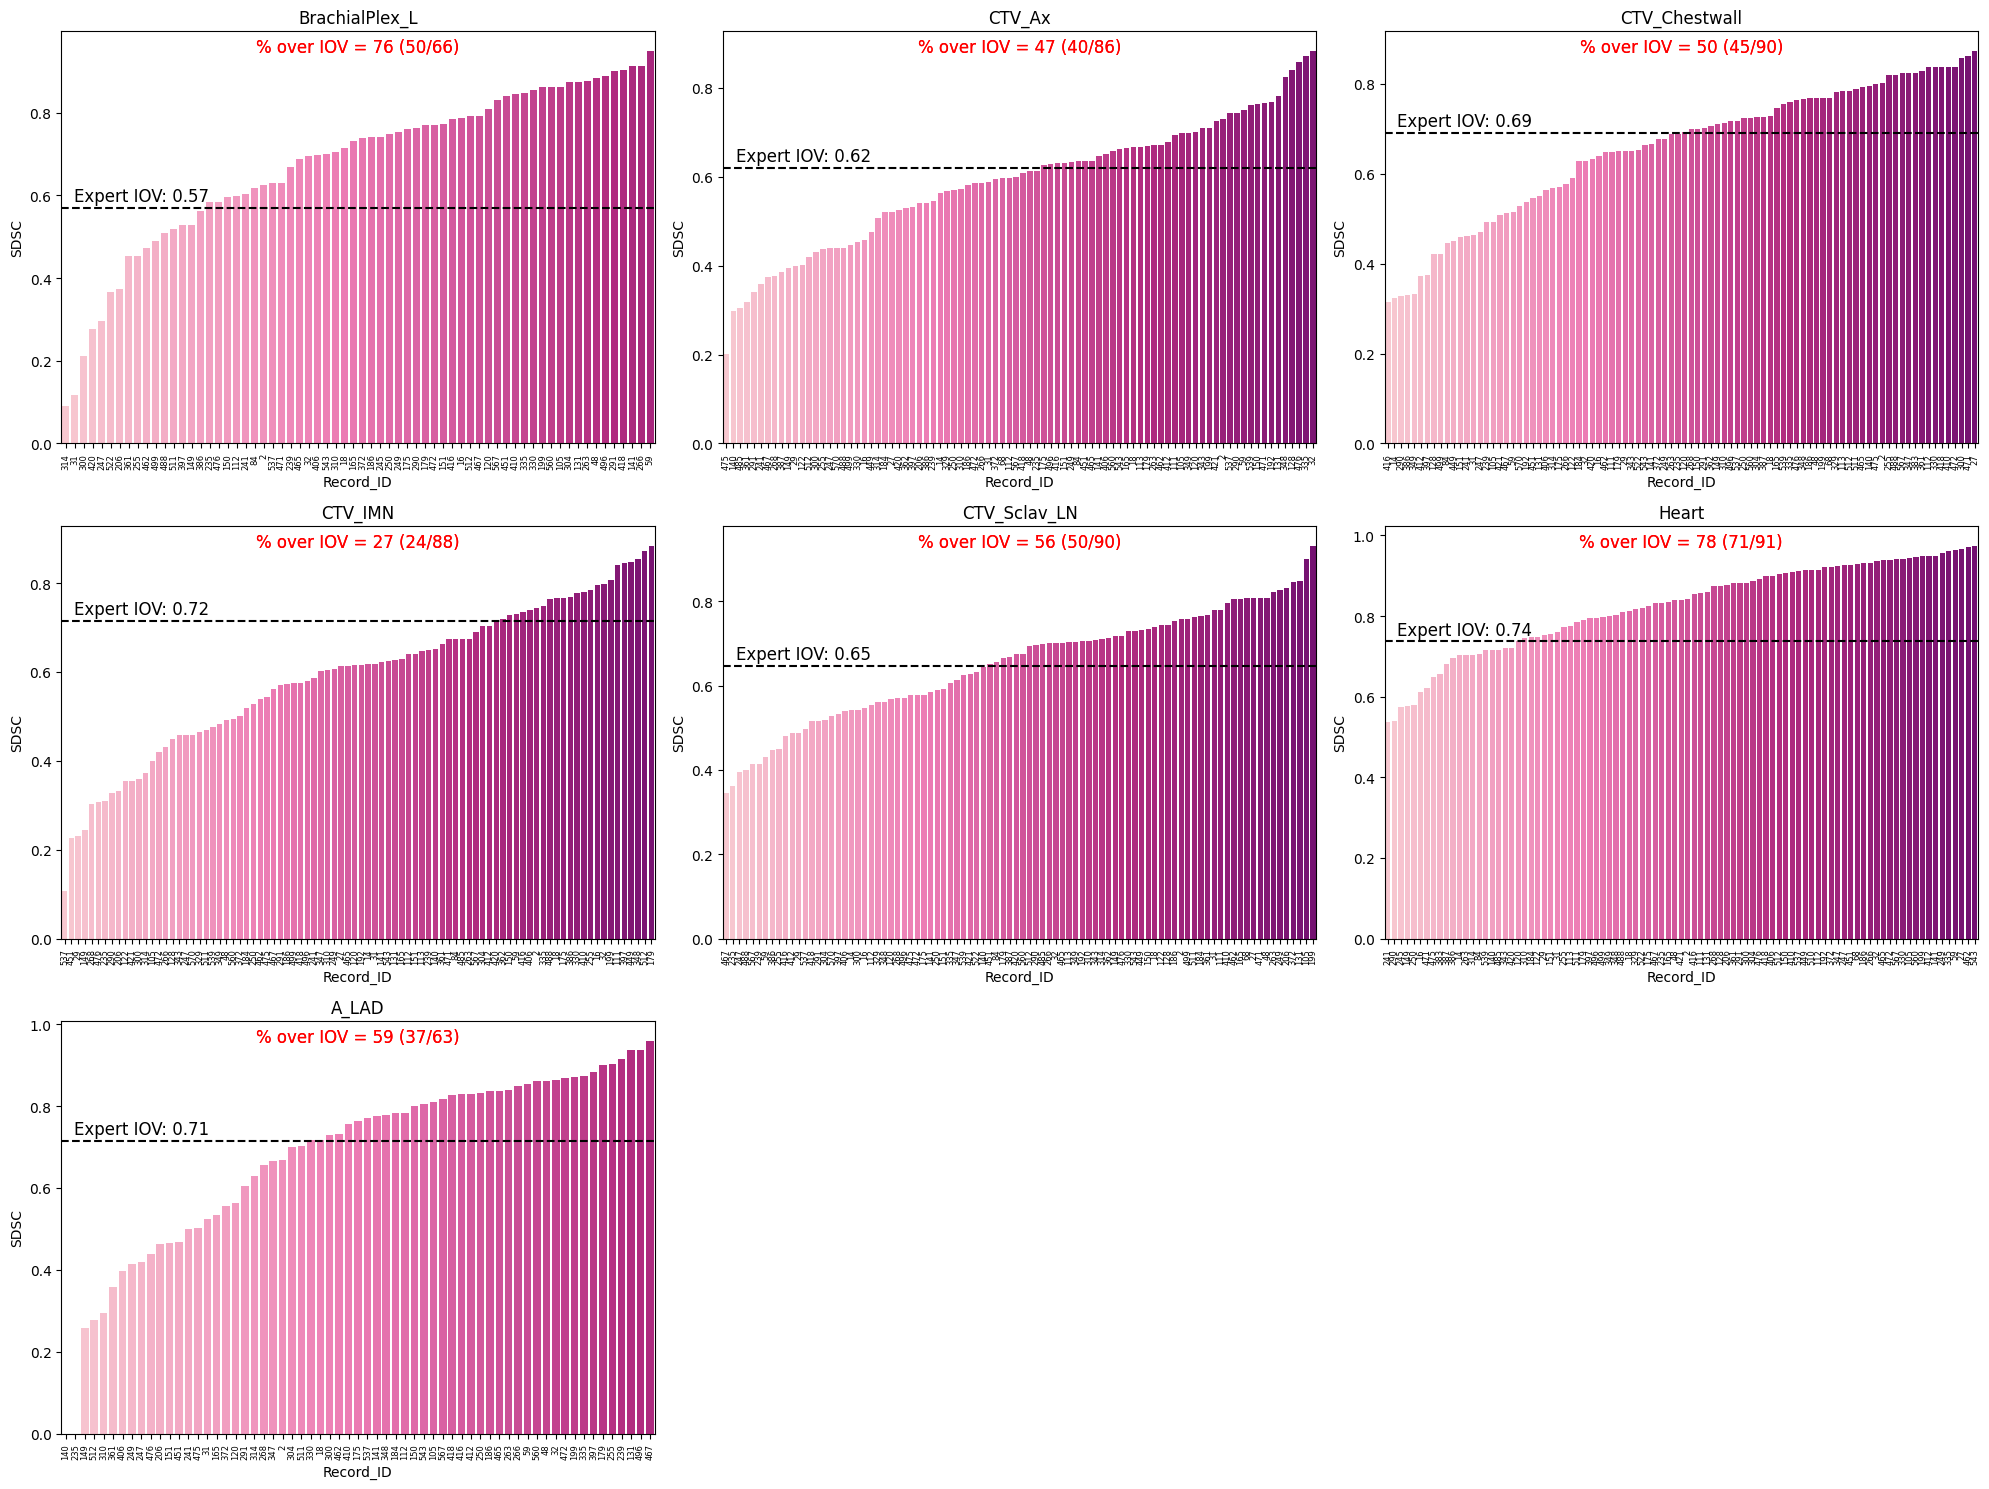

Processing for site: Sarcoma


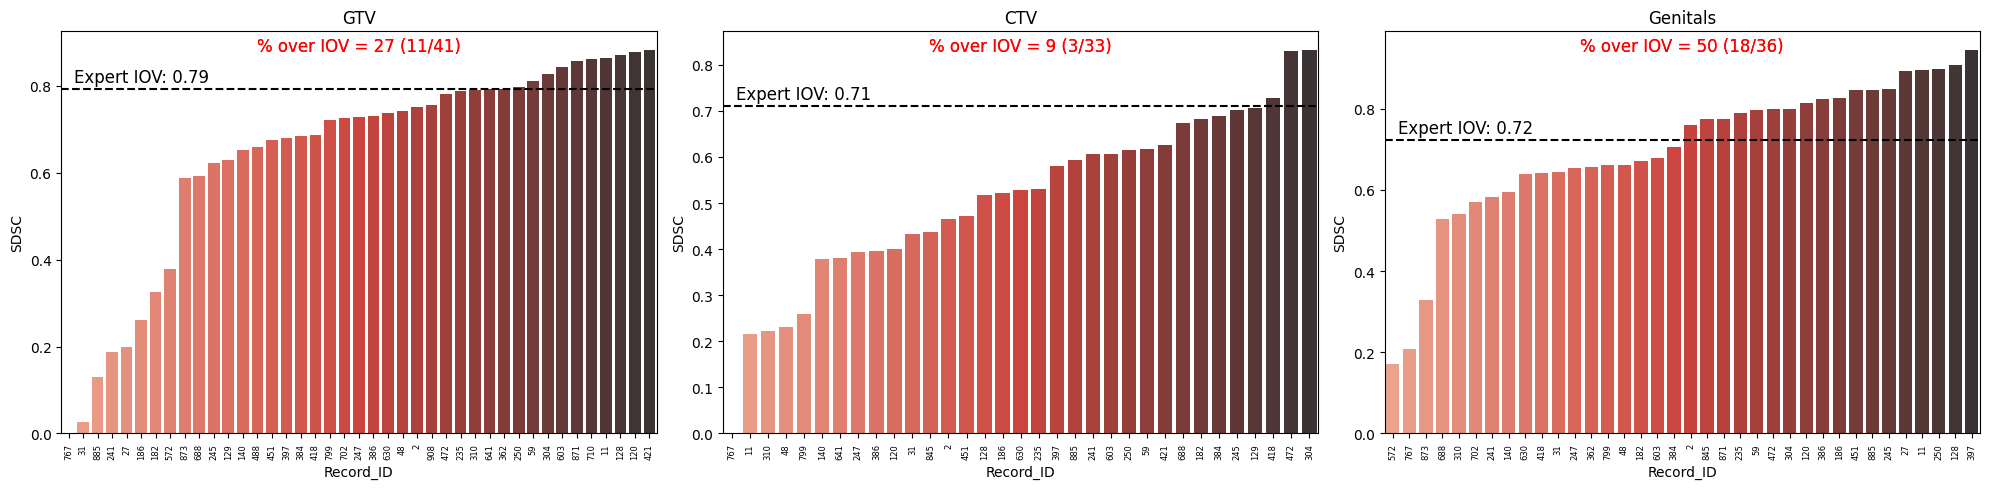

Processing for site: H&N


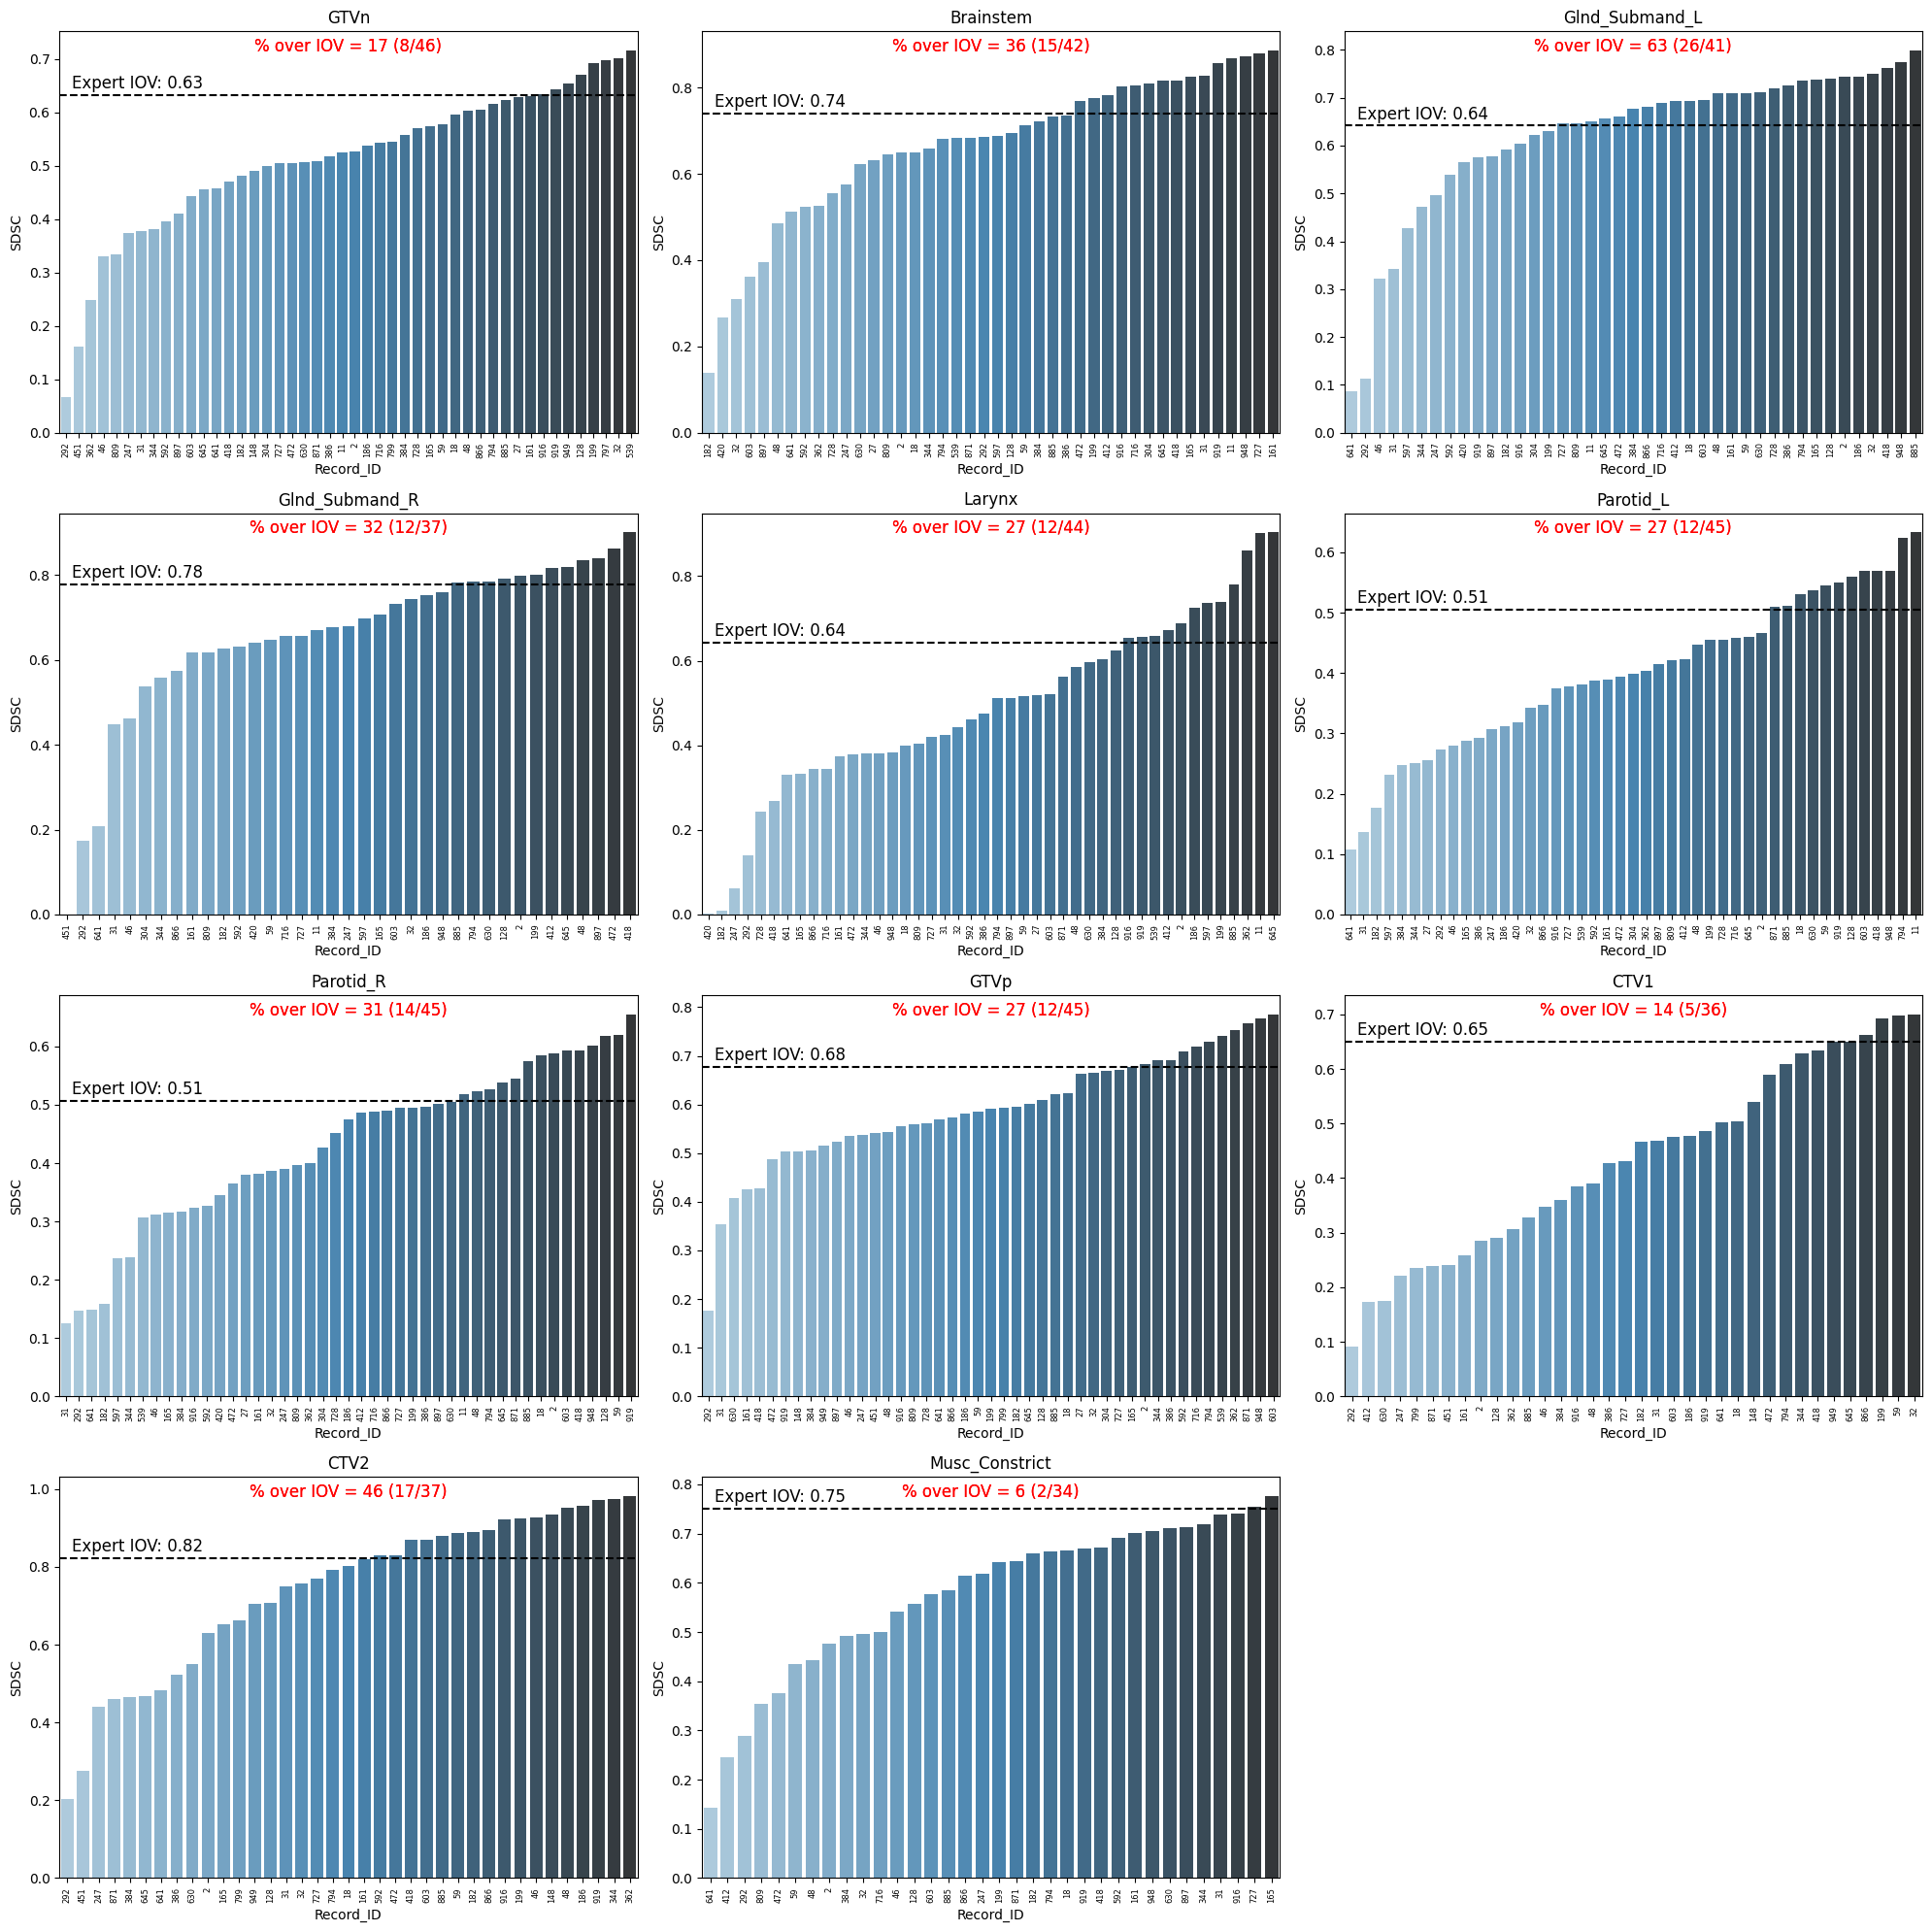

Processing for site: GYN


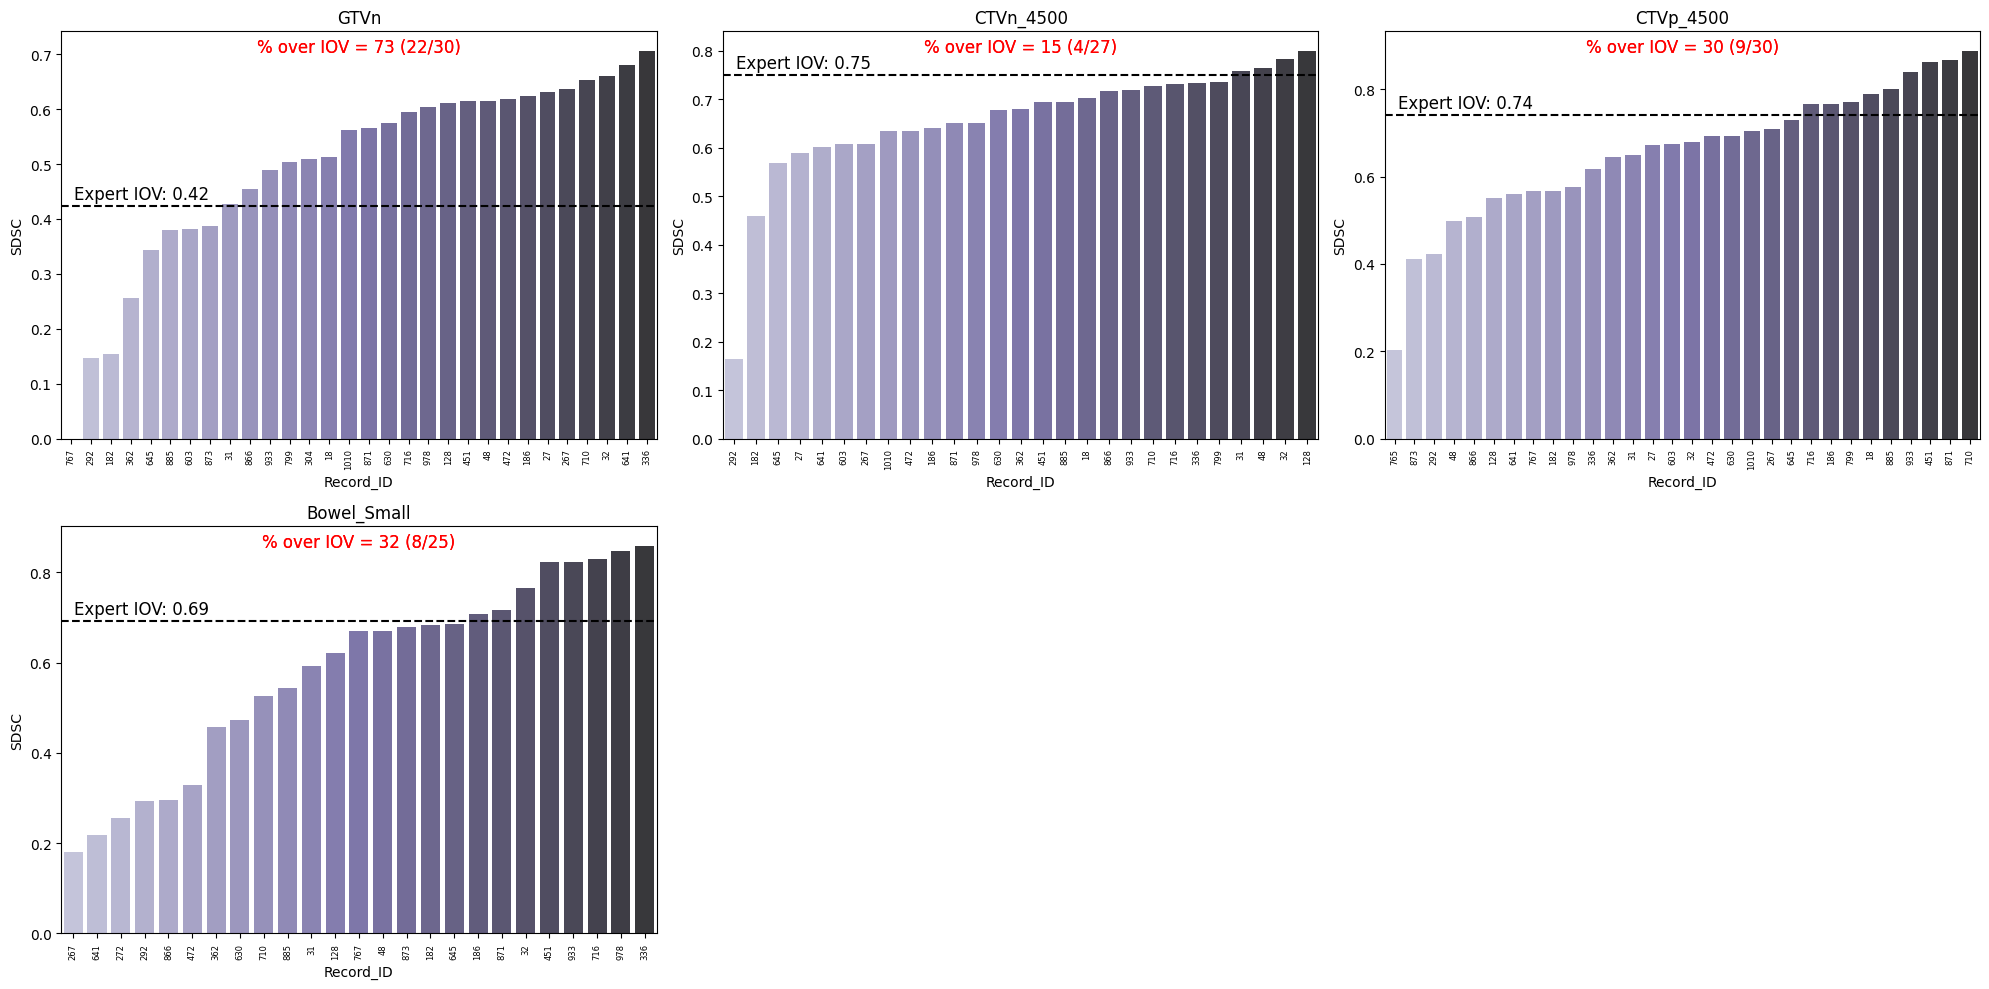

Processing for site: GI


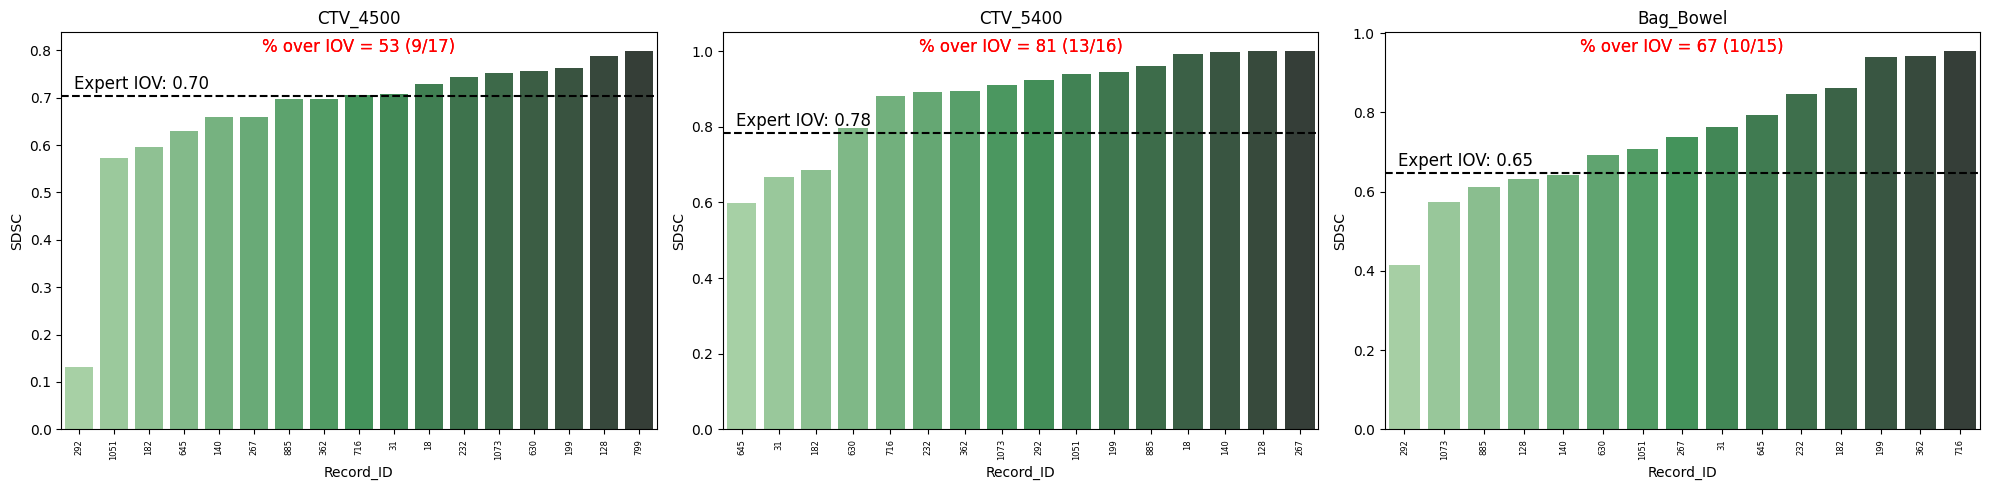

Processing for metric: HD95
Processing for site: Breast


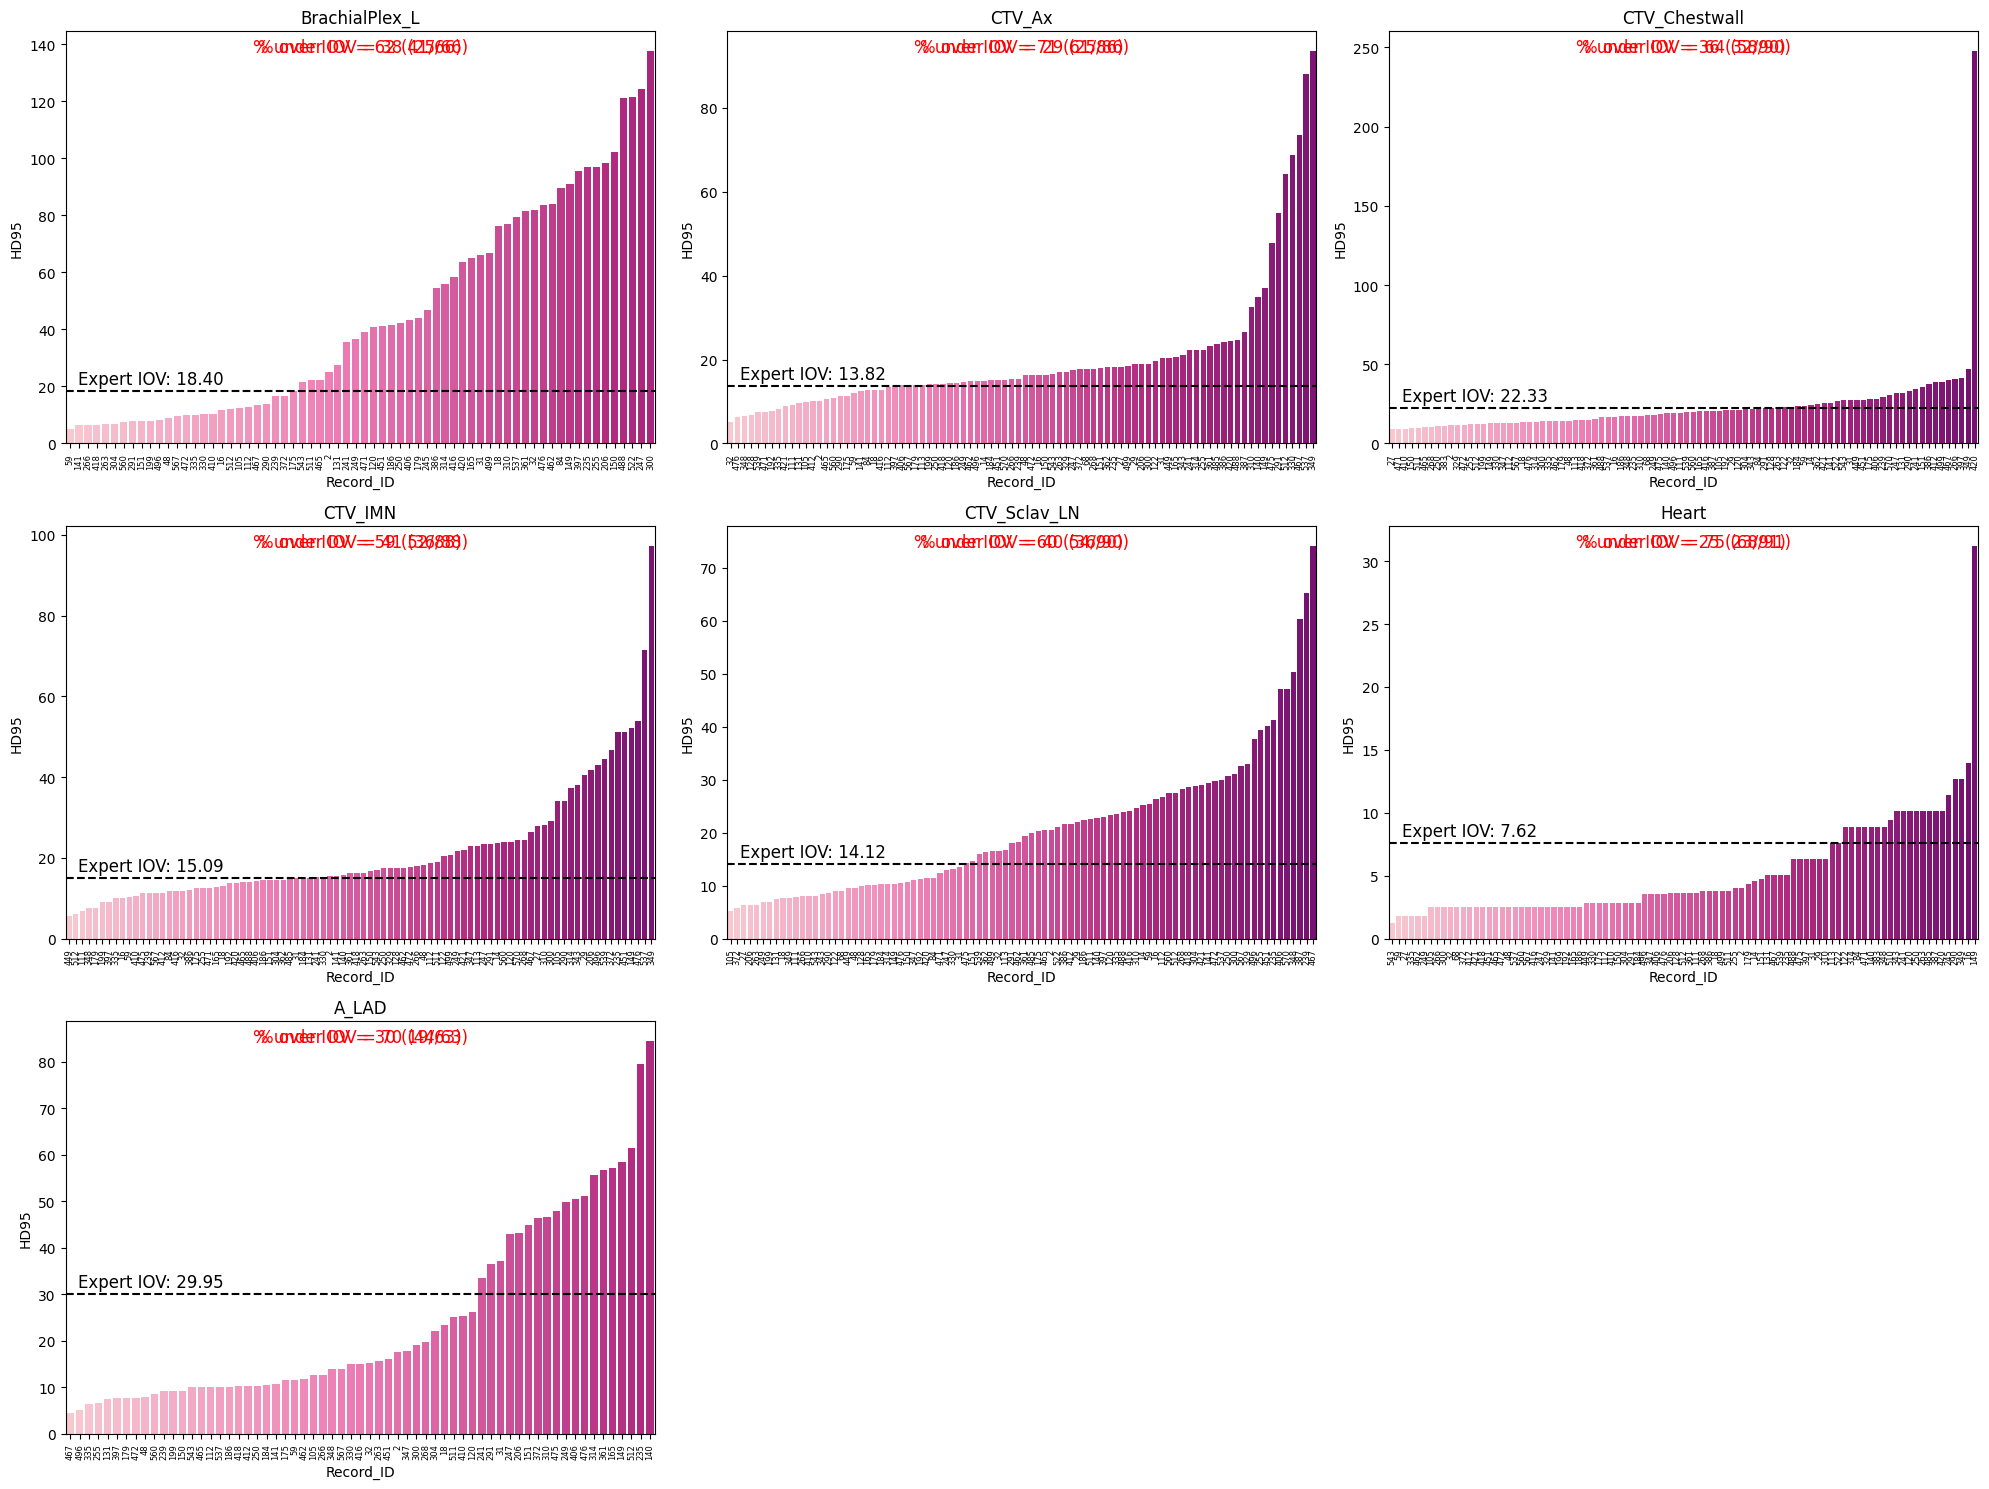

Processing for site: Sarcoma


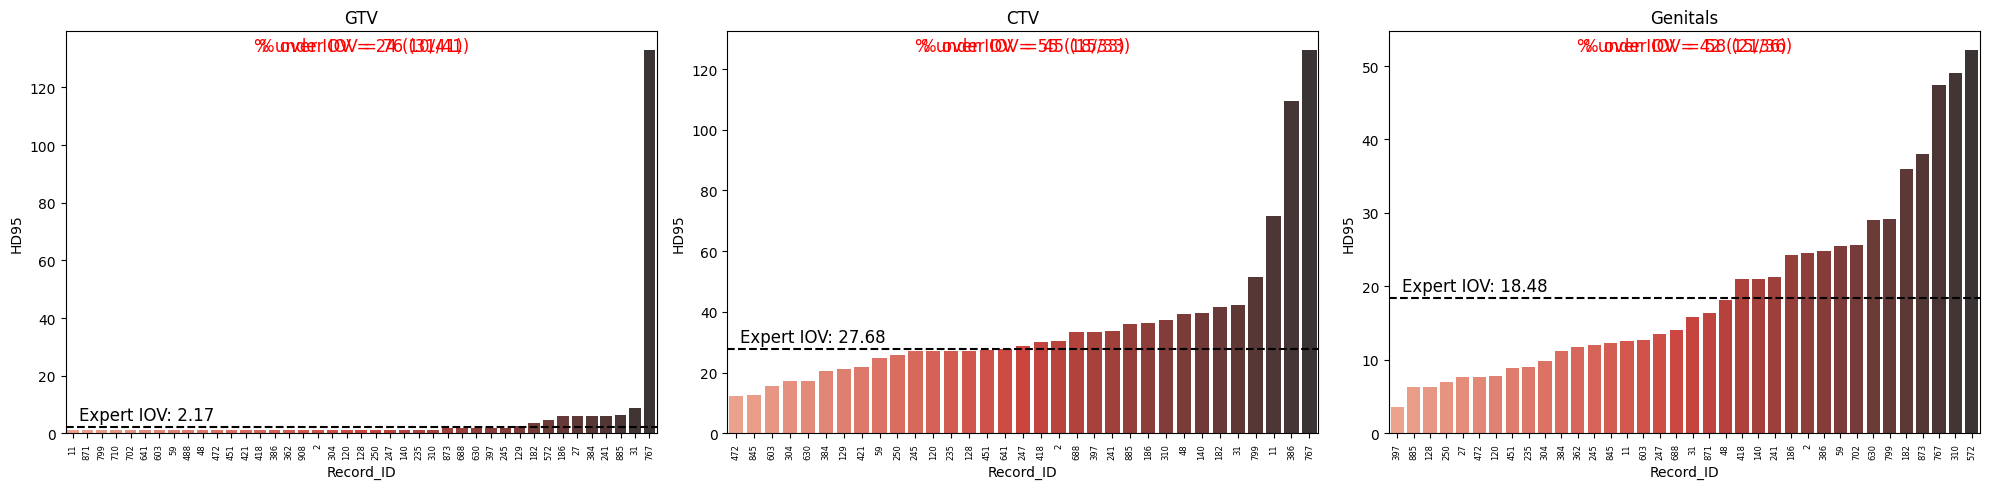

Processing for site: H&N


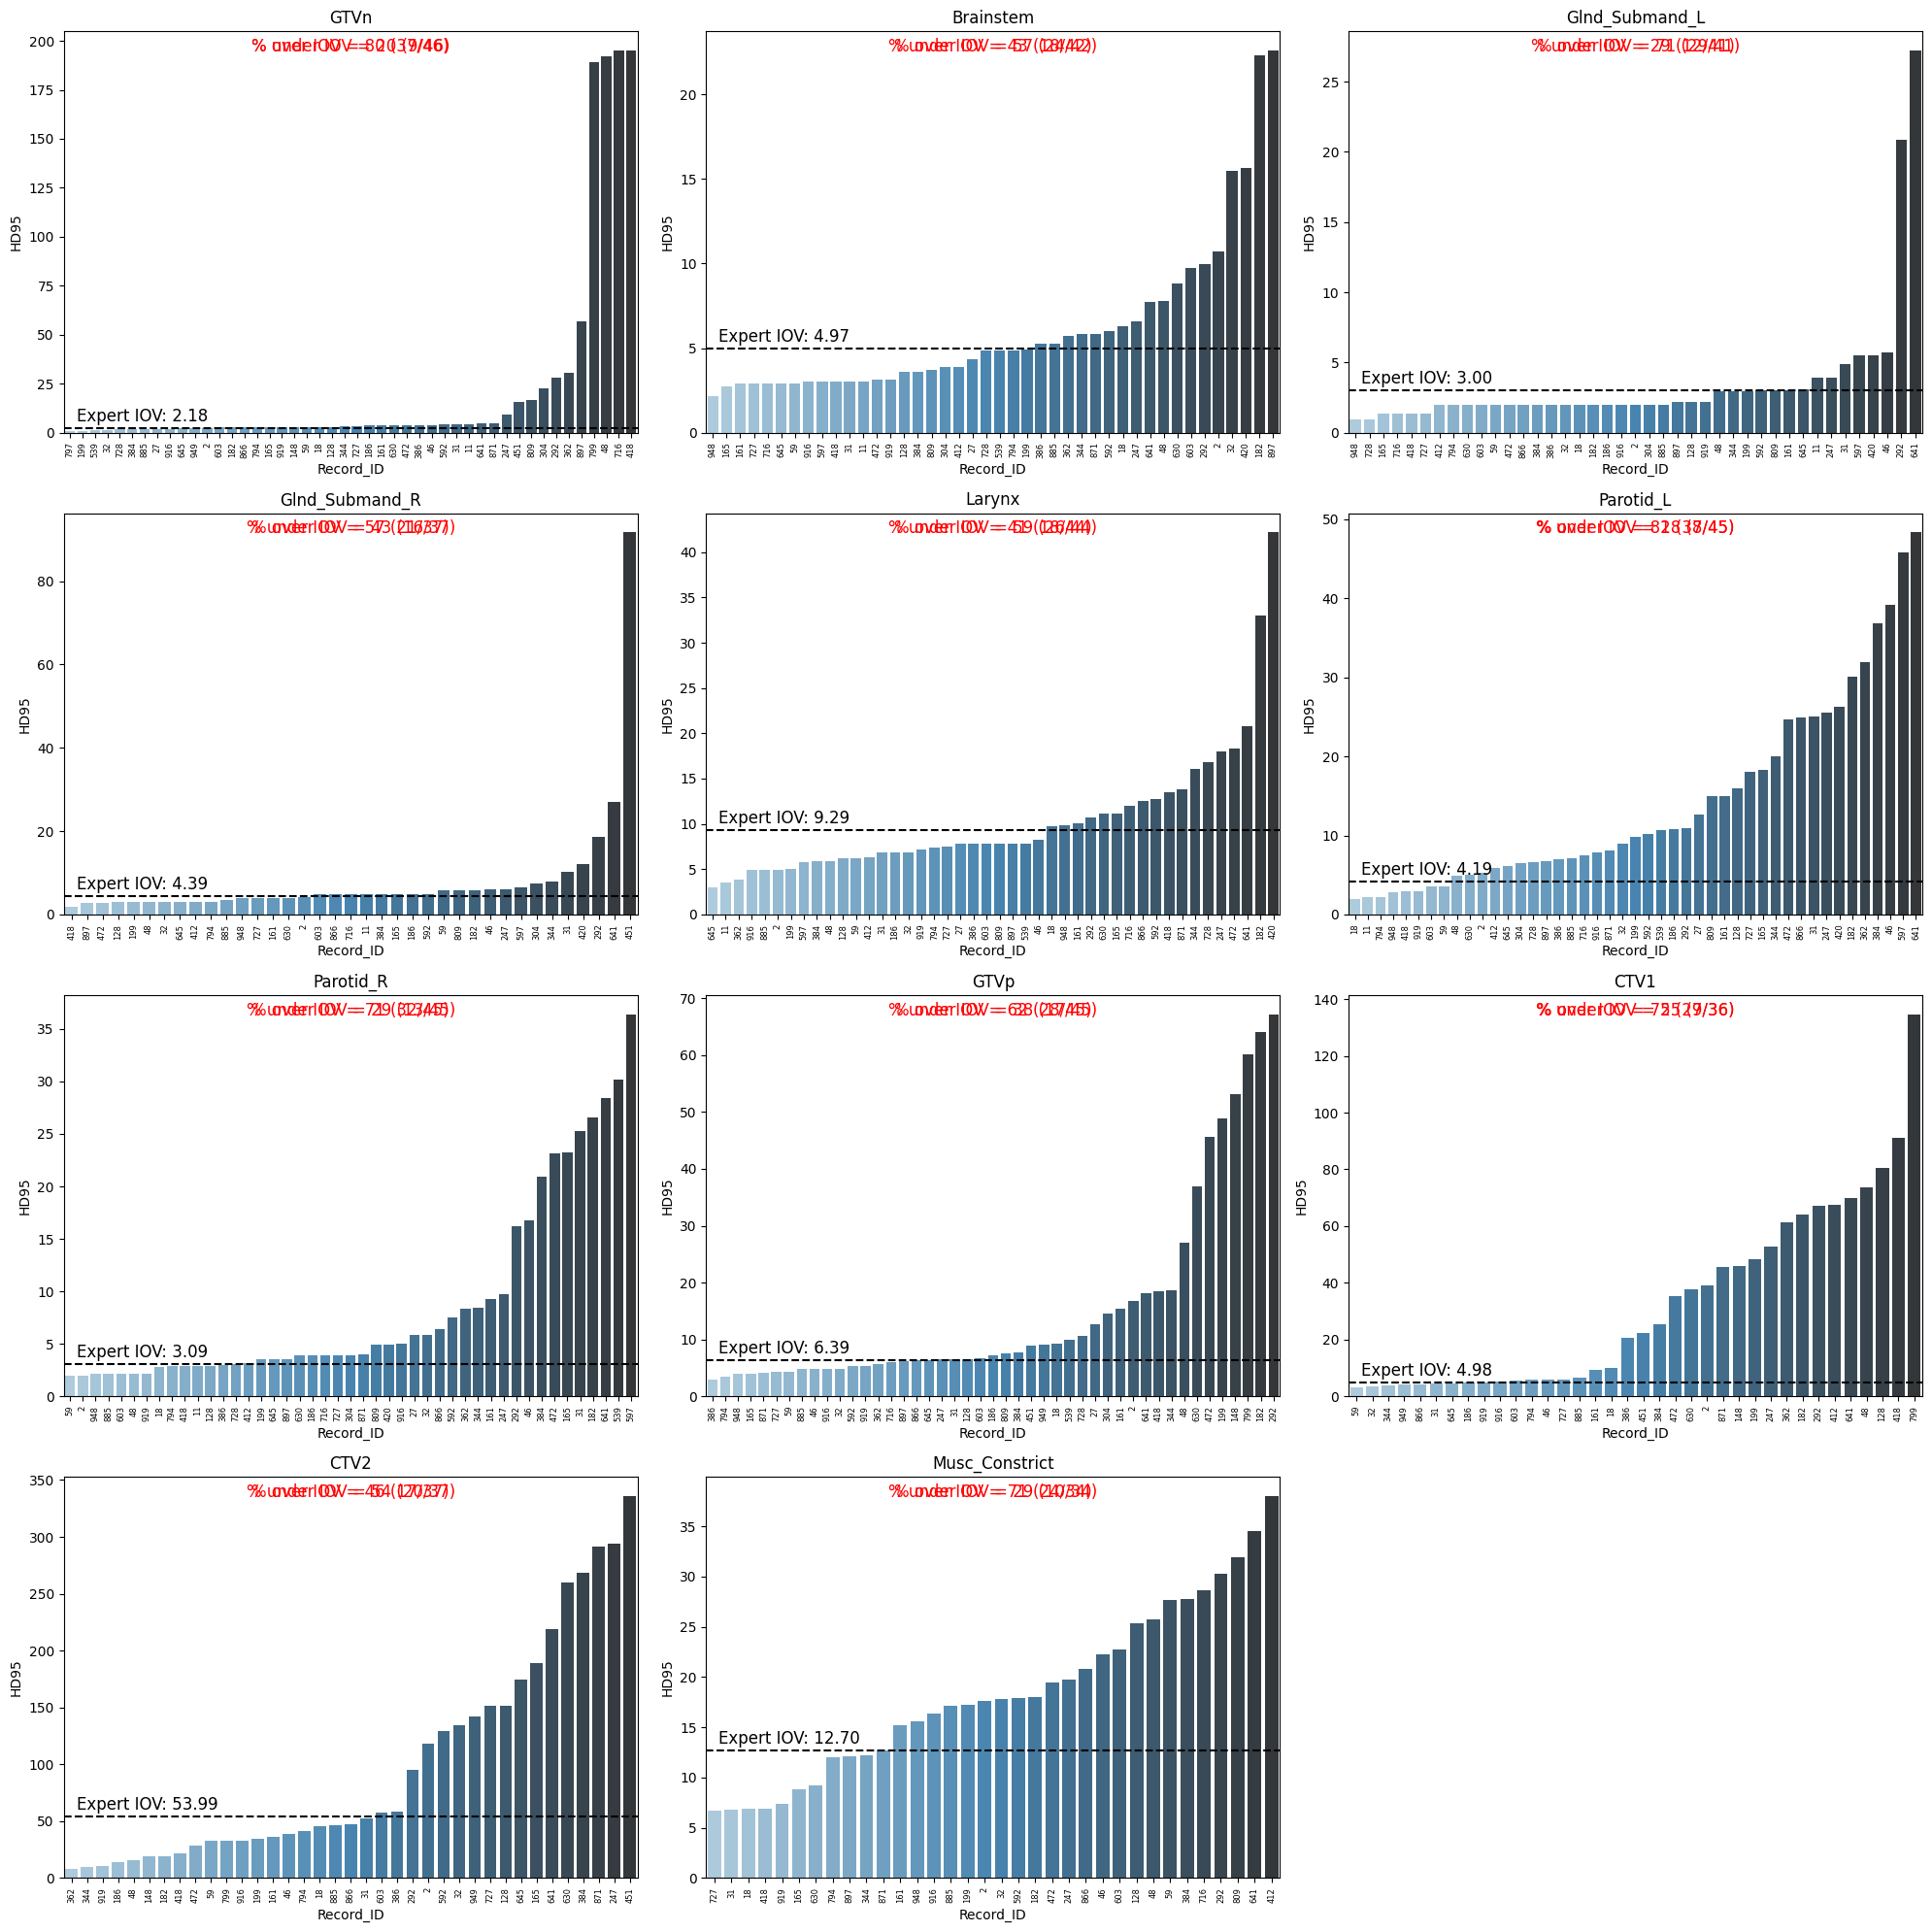

Processing for site: GYN


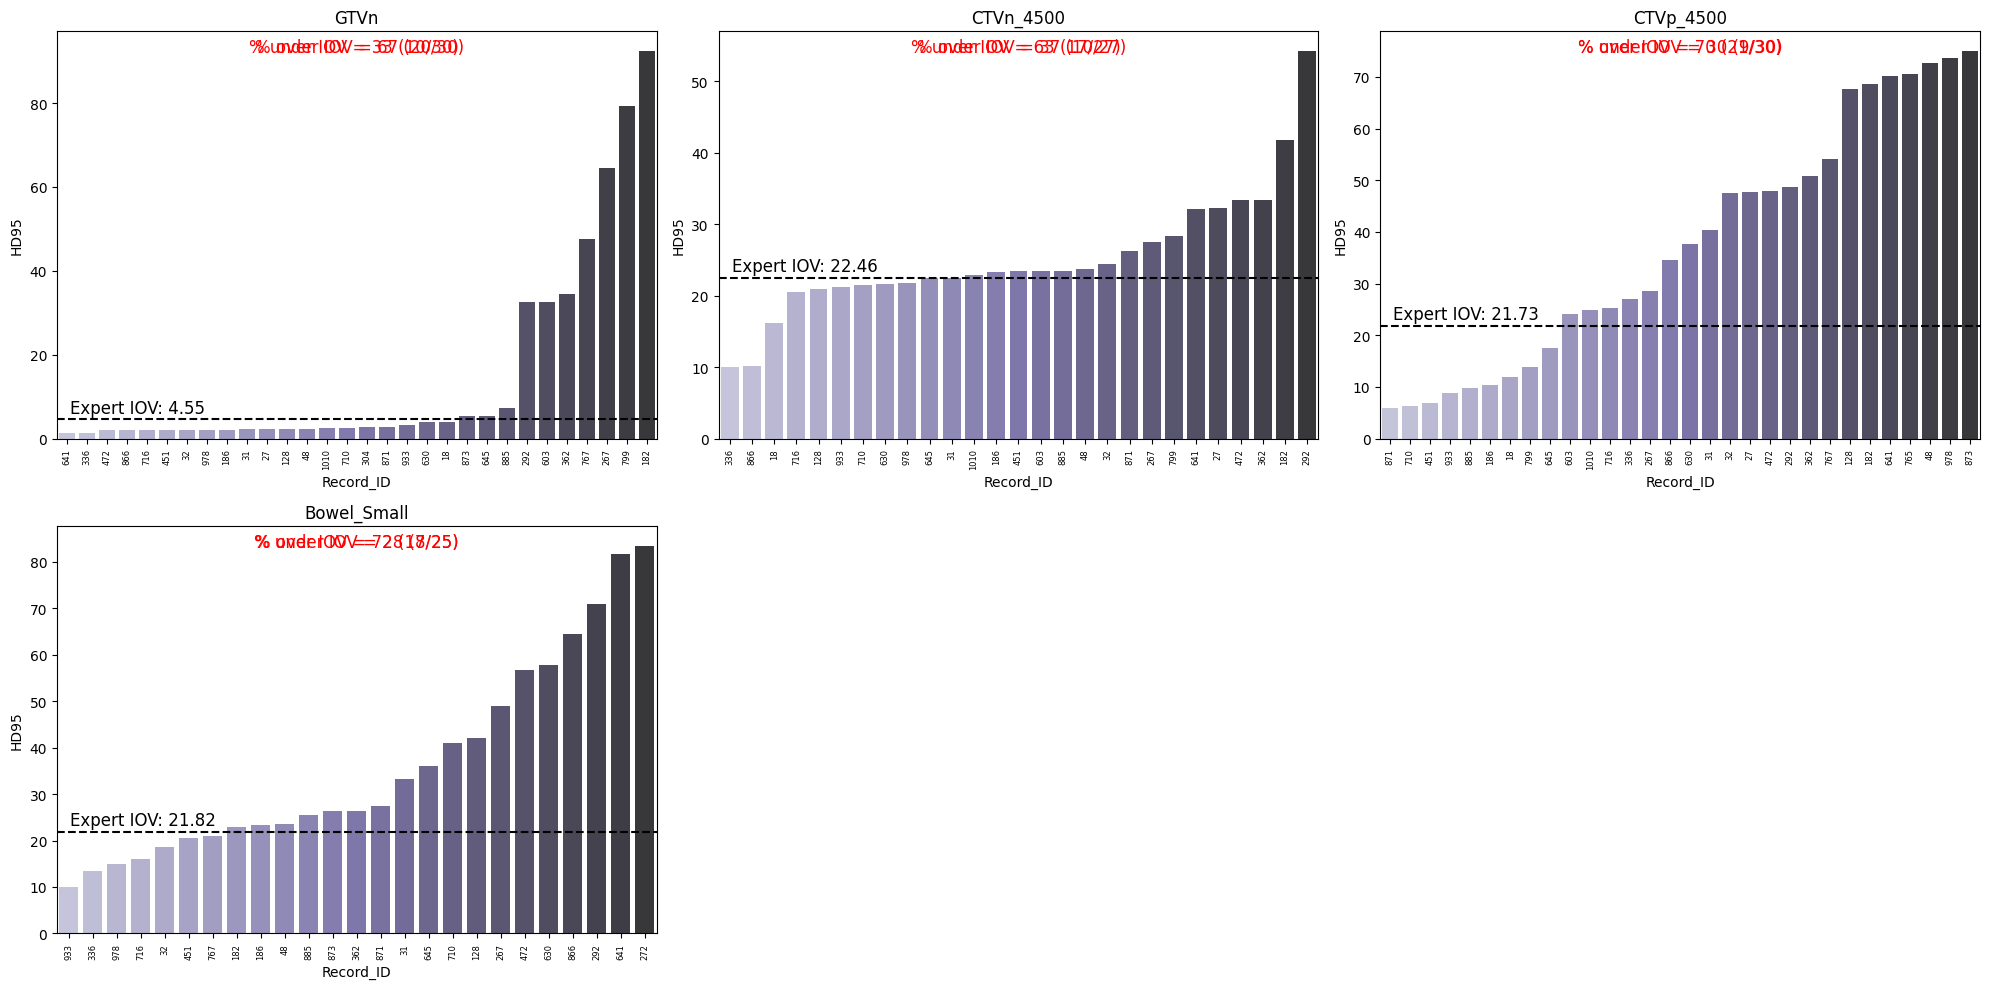

Processing for site: GI


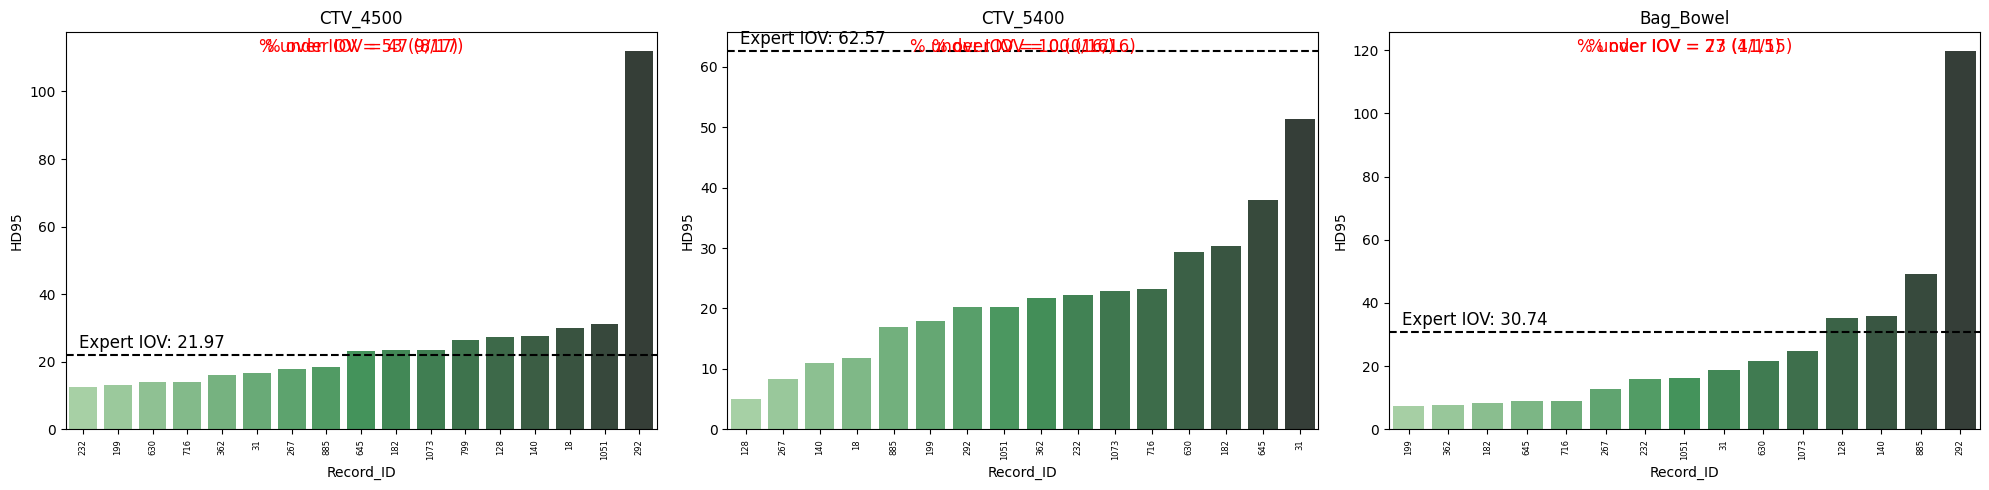

In [4]:
# Constants and configurations for plotting
# Initialize the dataframe which will store ratio values
ratio_df = pd.DataFrame(columns=['Case', 'ROI', 'Ratio', 'Metric', 'Subtype'])

DATA_PATH = 'csv_files'
OUTPUT_PATH = 'plot_outputs'
NUM_COLS = 3 
METRICS = ["DSC", "SDSC", "HD95"]

# Define a colormap similar to the "Blues_d" map but in pink, for use in plotting later
cmap = mcolors.LinearSegmentedColormap.from_list("", ["#FFC0CB", "#FF69B4", "#C71585", "#800080"])
colors = cmap(np.linspace(0, 1, 92)) # Generate a list of colors from the colormap
colors_hex = [mcolors.to_hex(c) for c in colors] # Convert colors from RGBA to HEX

# Mapping disease sites to different color palettes for plotting
SITE_LIST = {
    'Breast': colors_hex,
    'Sarcoma': 'Reds_d',
    'H&N': 'Blues_d',
    'GYN': 'Purples_d',  
    'GI': 'Greens_d'
}

# Load all datasets once and store in a dictionary for efficient access
dataframes = {}
for site in SITE_LIST:
    file_path = os.path.join(DATA_PATH, f"{site}.csv")
    if os.path.exists(file_path):
        dataframes[site] = pd.read_csv(file_path)
    else:
        print(f"Error: {file_path} does not exist!")

def preprocess_data(df):
    """Function to preprocess data for consistency across metrics and sites."""
    df['Practice_type'] = np.where(df['Practice_type'] == 'Academic/university', 'Academic', 'Non-academic')
    return df[df['What_is_your_profession'] == 'Radiation Oncologist/Clinical Oncologist']

# Iterate over metrics and sites for processing
for metric in METRICS:
    print(f"Processing for metric: {metric}")

    for site, color in SITE_LIST.items():
        print(f"Processing for site: {site}")

        # Access the pre-loaded data for the current site and preprocess
        site_df = preprocess_data(dataframes[site])

        # Informational prints
        #print(f"Shape of the data: {site_df.shape}")
        #print(f"Unique observers: {len(site_df['Record_ID'].unique())}")
        
        # Filter and rename values for consistency
        site_df['Practice_type'] = np.where(site_df['Practice_type'] == 'Academic/university', 'Academic', 'Non-academic')
        site_df = site_df[site_df['What_is_your_profession'] == 'Radiation Oncologist/Clinical Oncologist']

        # Setup for plotting
        rois = site_df['ROI'].unique()
        n_rows = math.ceil(len(rois) / NUM_COLS)
        fig, axs = plt.subplots(n_rows, NUM_COLS, figsize=(20, 5 * n_rows))
        axs = axs.ravel()
        
        # Plot each ROI
        for ax, roi in zip(axs, rois):
            data = site_df[site_df['ROI'] == roi]
            expert_iov_value = data[f"{metric}_expert_IOV"].values[0]
            
            # Count the number of cases above and below the threshold
            num_above = len(data[data[metric] >= expert_iov_value])
            num_below = len(data[data[metric] < expert_iov_value])
            
            # Calculate the ratio of cases equal to or above the threshold
            ratio_above = num_above / (num_above + num_below) # this is for DSC
            ratio_below = num_below / (num_above + num_below) # this is for HD95

            # Use gradient color palette from site_list dictionary
            palette = SITE_LIST[site]
            
            # Bar plot
            sns.barplot(x='Record_ID', y=metric, data=data, ax=ax, palette=palette, order=data.sort_values(metric)['Record_ID'])
            
            # Annotations and styling
            ax.axhline(y=expert_iov_value, color='black', linestyle='dashed')
            ax.annotate(f"Expert IOV: {expert_iov_value:.2f}", xy=(0.01, expert_iov_value), xycoords=('axes fraction', 'data'), xytext=(5, 5), textcoords='offset points', fontsize=12, color='black')
            ax.set_title(roi)
            ax.tick_params(axis='x', rotation=90, labelsize=6)
            
            if metric == "HD95":
                ax.annotate(f'% under IOV = {int(round(ratio_below*100))} ({num_below}/{num_above + num_below})', xy=(0.5, 0.95), xycoords='axes fraction', xytext=(0, 0), textcoords='offset points', fontsize=12, color='red', ha='center')
                ratio_to_use = ratio_below
            else: # for DSC stuff
                ax.annotate(f'% over IOV = {int(round(ratio_above*100))} ({num_above}/{num_above + num_below})', xy=(0.5, 0.95), xycoords='axes fraction', xytext=(0, 0), textcoords='offset points', fontsize=12, color='red', ha='center')
                ratio_to_use = ratio_above
            
            ax.annotate(f"% over IOV = {int(round(ratio_above*100))} ({len(data[data[metric] >= expert_iov_value])}/{len(data)})", xy=(0.5, 0.95), xycoords='axes fraction', xytext=(0, 0), textcoords='offset points', fontsize=12, color='red', ha='center')

            # Add data to ratio_df
            roi_category = 'Tumor' if 'TV' in roi else 'OAR'
            ratio_df = ratio_df.append({'Case': site, 'ROI': roi, 'Ratio': ratio_to_use, 'Metric': metric, 'Subtype': roi_category}, ignore_index=True)

        # Remove extra axes
        for i in range(len(rois), n_rows * NUM_COLS):
            fig.delaxes(axs[i])
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_PATH, f"{site}_{metric}.pdf"))
        plt.show()


In [5]:
# Display ratios dataframe
ratio_df

Case             ROI     Ratio Metric Subtype
0   Breast  BrachialPlex_L  0.818182    DSC     OAR
1   Breast          CTV_Ax  0.465116    DSC   Tumor
2   Breast   CTV_Chestwall  0.655556    DSC   Tumor
3   Breast         CTV_IMN  0.363636    DSC   Tumor
4   Breast    CTV_Sclav_LN  0.688889    DSC   Tumor
..     ...             ...       ...    ...     ...
79     GYN       CTVp_4500       0.3   HD95   Tumor
80     GYN     Bowel_Small      0.28   HD95     OAR
81      GI        CTV_4500  0.470588   HD95   Tumor
82      GI        CTV_5400       1.0   HD95   Tumor
83      GI       Bag_Bowel  0.733333   HD95     OAR

[84 rows x 5 columns]

## Grouped Data Analyses <a class="anchor" id="group"></a>
### Description
- Aggregates data by 'Case', 'Subtype' and 'Metric' then calculates summary statistics.
- Structures the results in a DataFrame for easier access and interpretation.

In [6]:
# Convert columns to numeric if necessary
ratio_df['Ratio'] = pd.to_numeric(ratio_df['Ratio'], errors='coerce')

In [7]:
# Grouping the data by 'Case' and 'Metric' for efficient calculations
grouped_by_case_metric = ratio_df.groupby(['Case', 'Metric'])['Ratio']

# Calculate the median, stratified by Case and Metric
median_by_case = grouped_by_case_metric.median()

# Calculate the interquartile range (IQR), stratified by Case and Metric
iqr_by_case = grouped_by_case_metric.quantile(0.75) - grouped_by_case_metric.quantile(0.25)

# Display the calculated median and IQR values
print("Median by Case and Metric:\n", median_by_case)
print("\nIQR by Case and Metric:\n", iqr_by_case)


Median by Case and Metric:
 Case     Metric
Breast   DSC       0.655556
         HD95      0.409091
         SDSC      0.555556
GI       DSC       0.312500
         HD95      0.733333
         SDSC      0.666667
GYN      DSC       0.353333
         HD95      0.335185
         SDSC      0.310000
H&N      DSC       0.355556
         HD95      0.377778
         SDSC      0.272727
Sarcoma  DSC       0.365854
         HD95      0.583333
         SDSC      0.268293
Name: Ratio, dtype: float64

IQR by Case and Metric:
 Case     Metric
Breast   DSC       0.219334
         HD95      0.282035
         SDSC      0.189881
GI       DSC       0.219608
         HD95      0.264706
         SDSC      0.141544
GYN      DSC       0.240185
         HD95      0.149444
         SDSC      0.161296
H&N      DSC       0.194530
         HD95      0.286540
         SDSC      0.120444
Sarcoma  DSC       0.131313
         HD95      0.150776
         SDSC      0.204545
Name: Ratio, dtype: float64


In [8]:
# Grouping the data by 'Subtype' and 'Metric' 
grouped_by_subtype_metric = ratio_df.groupby(['Subtype', 'Metric'])

# Calculate the count, median, and interquartile range (IQR), stratified by Subtype and Metric
count_by_subtype_metric = grouped_by_subtype_metric.size()
median_by_subtype_metric = grouped_by_subtype_metric['Ratio'].median()
iqr_by_subtype_metric = grouped_by_subtype_metric['Ratio'].quantile(0.75) - grouped_by_subtype_metric['Ratio'].quantile(0.25)

# Consolidate the results into a DataFrame for better presentation
df_median_iqr_count = pd.DataFrame({
    'Count': count_by_subtype_metric,
    'Median': median_by_subtype_metric,
    'IQR': iqr_by_subtype_metric
})


In [9]:
# Display the summary statistics dataframe
df_median_iqr_count 

Count    Median       IQR
Subtype Metric                           
OAR     DSC        13  0.547619  0.354955
        HD95       13  0.571429  0.404295
        SDSC       13  0.357143  0.323035
Tumor   DSC        15  0.312500  0.152522
        HD95       15  0.409091  0.257307
        SDSC       15  0.300000  0.294416

## Bayesian Regression Analysis <a class="anchor" id="bayes"></a>
### Description
- Executes linear regression with Bayesian uncertainty estimation using the bambi package.
- Defines utility functions for data preprocessing and Bayesian regression.
- Loads and preprocesses datasets for each site.
- Performs Bayesian regression on the preprocessed data.
- Saves and visualizes the results.
- Note: If running full Bayesian analysis this cell will take about a full day to run on standard CPUs.

Modeling the probability that DSC_binary==1


DSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Breast, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Breast, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 6612 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Breast, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


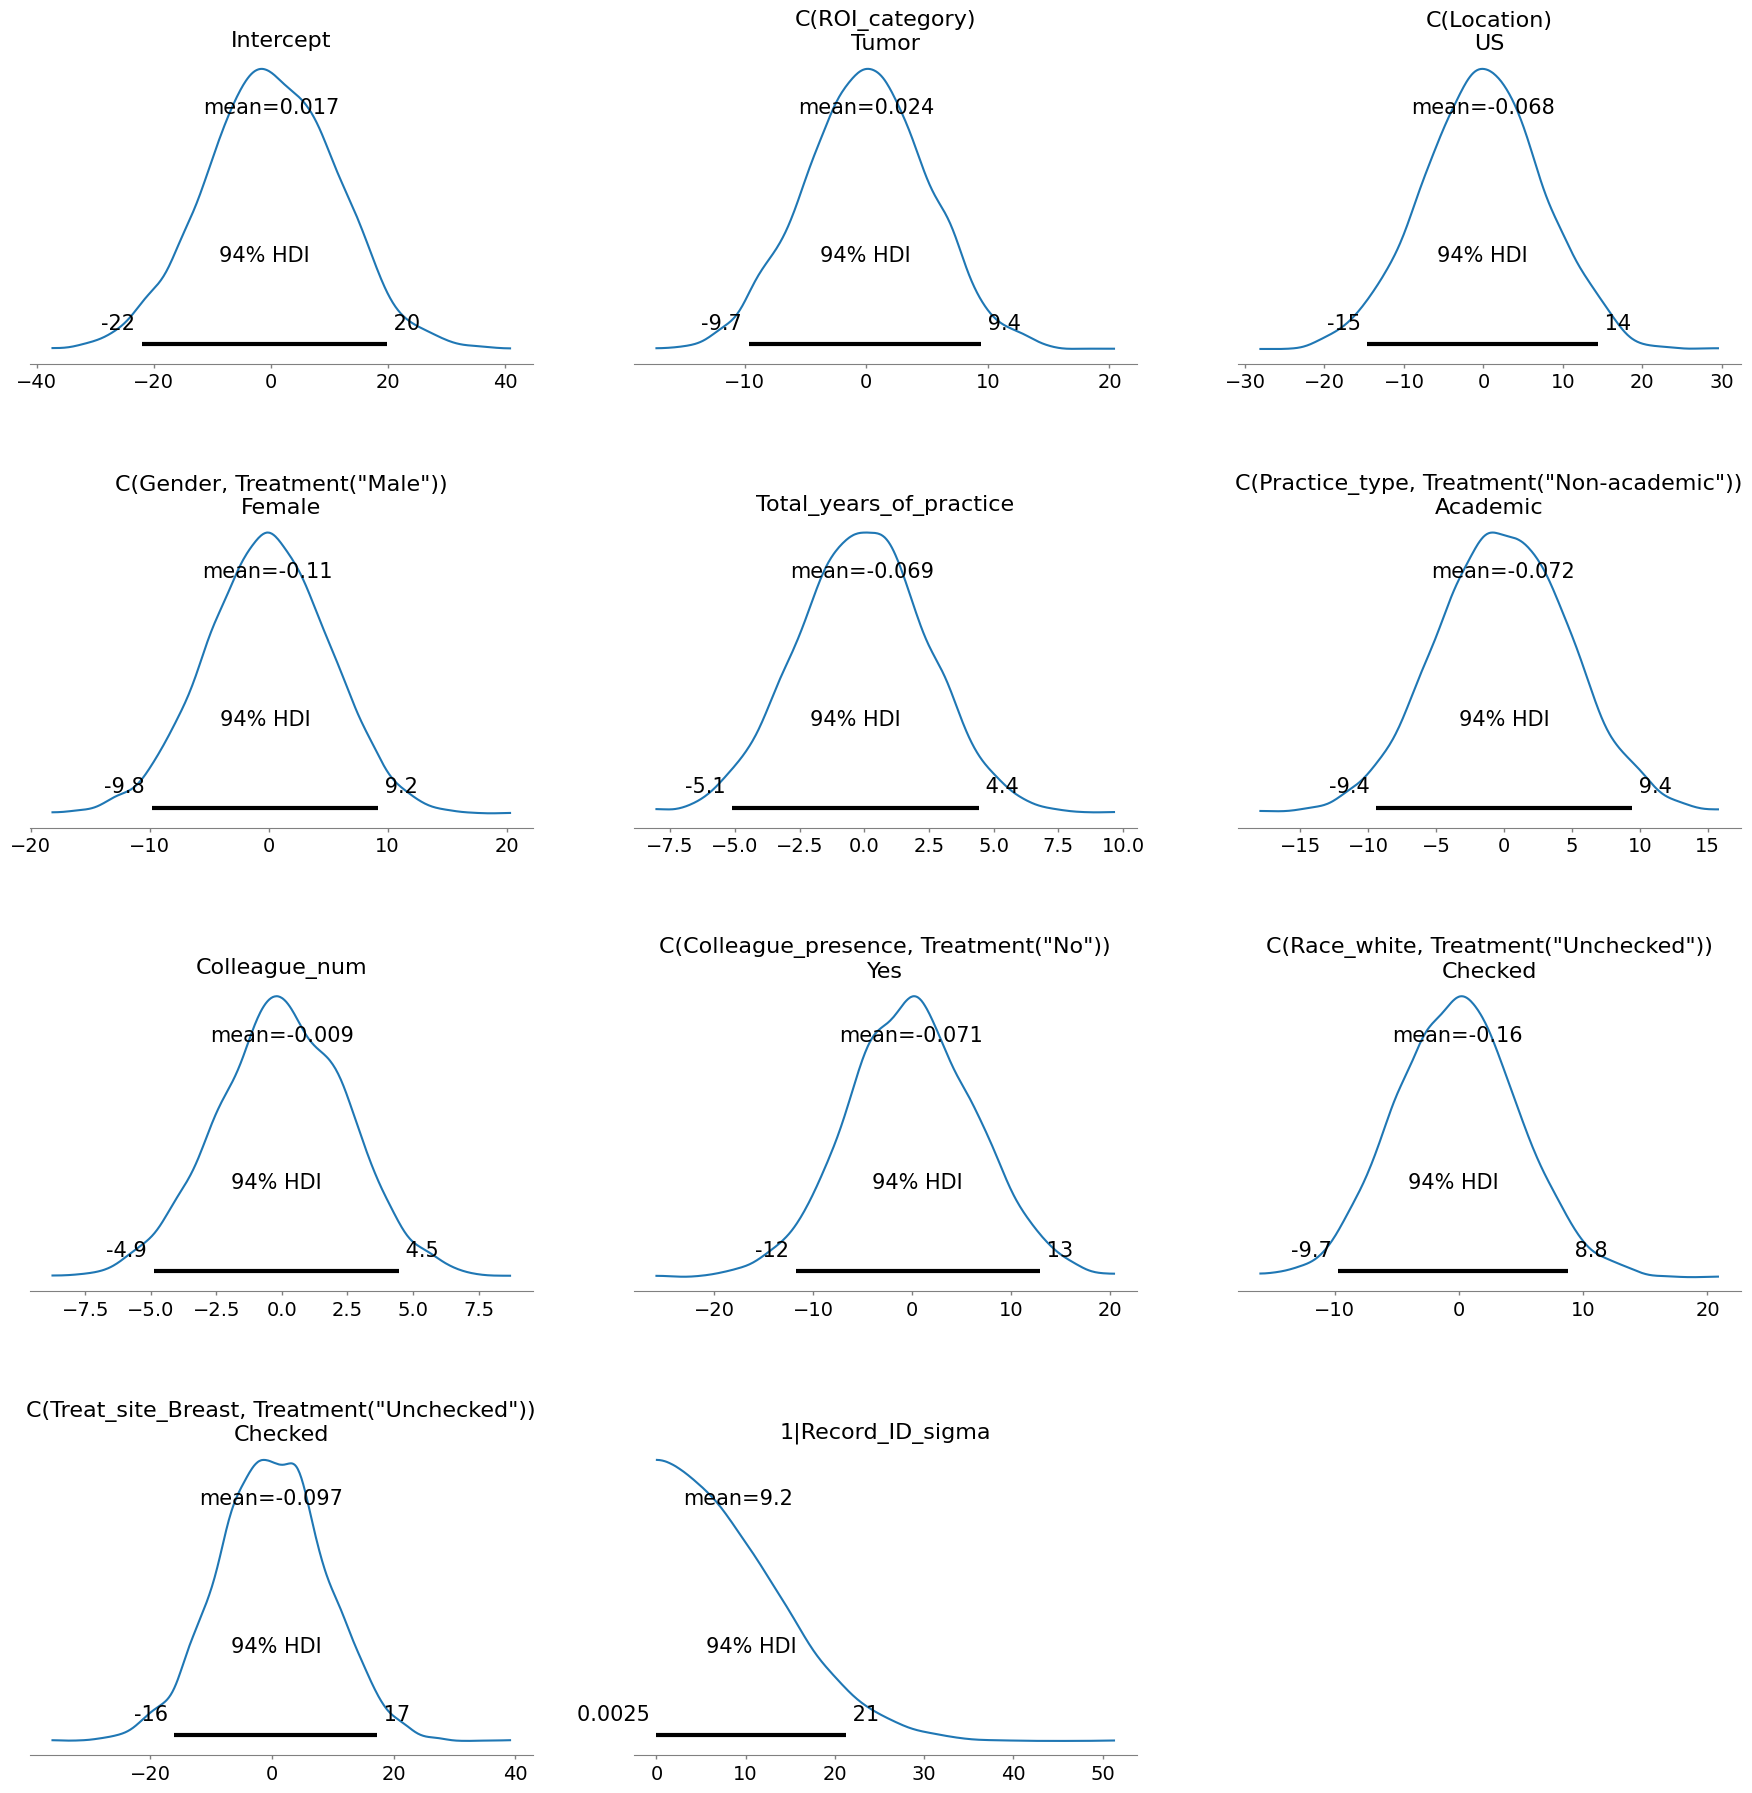

Modeling the probability that DSC_binary==1


DSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Sarcoma, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Sarcoma, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 1699 seconds.
There were 99 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Sarcoma, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


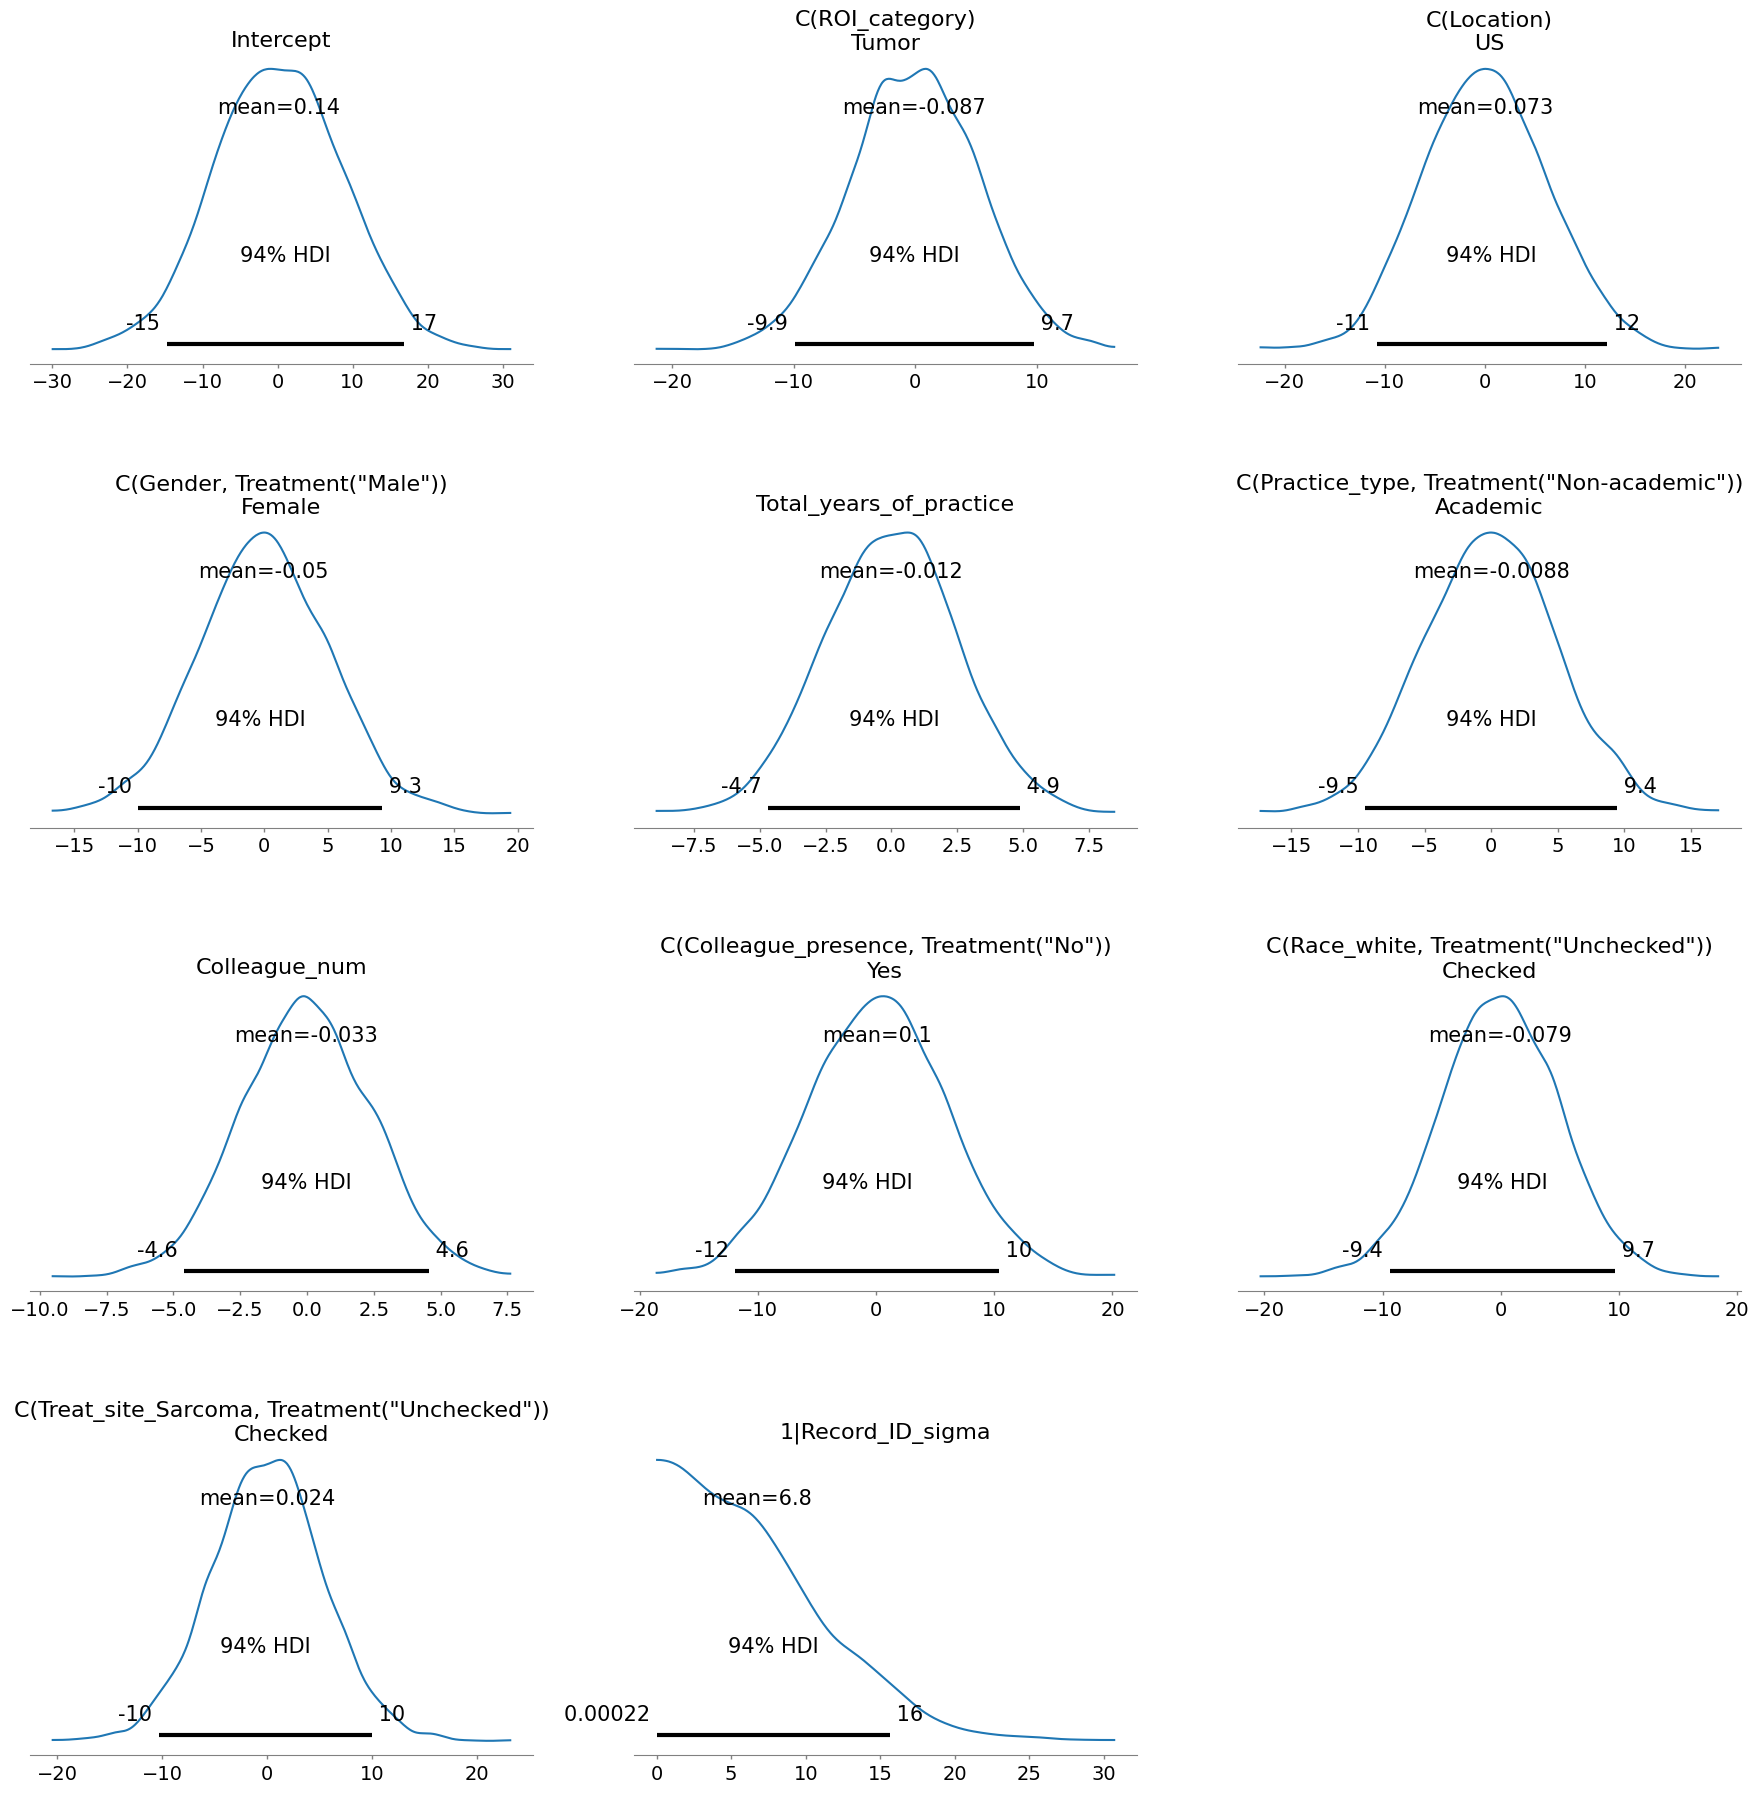

Modeling the probability that DSC_binary==1


DSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Head__Neck, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Head__Neck, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 6300 seconds.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Head__Neck, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


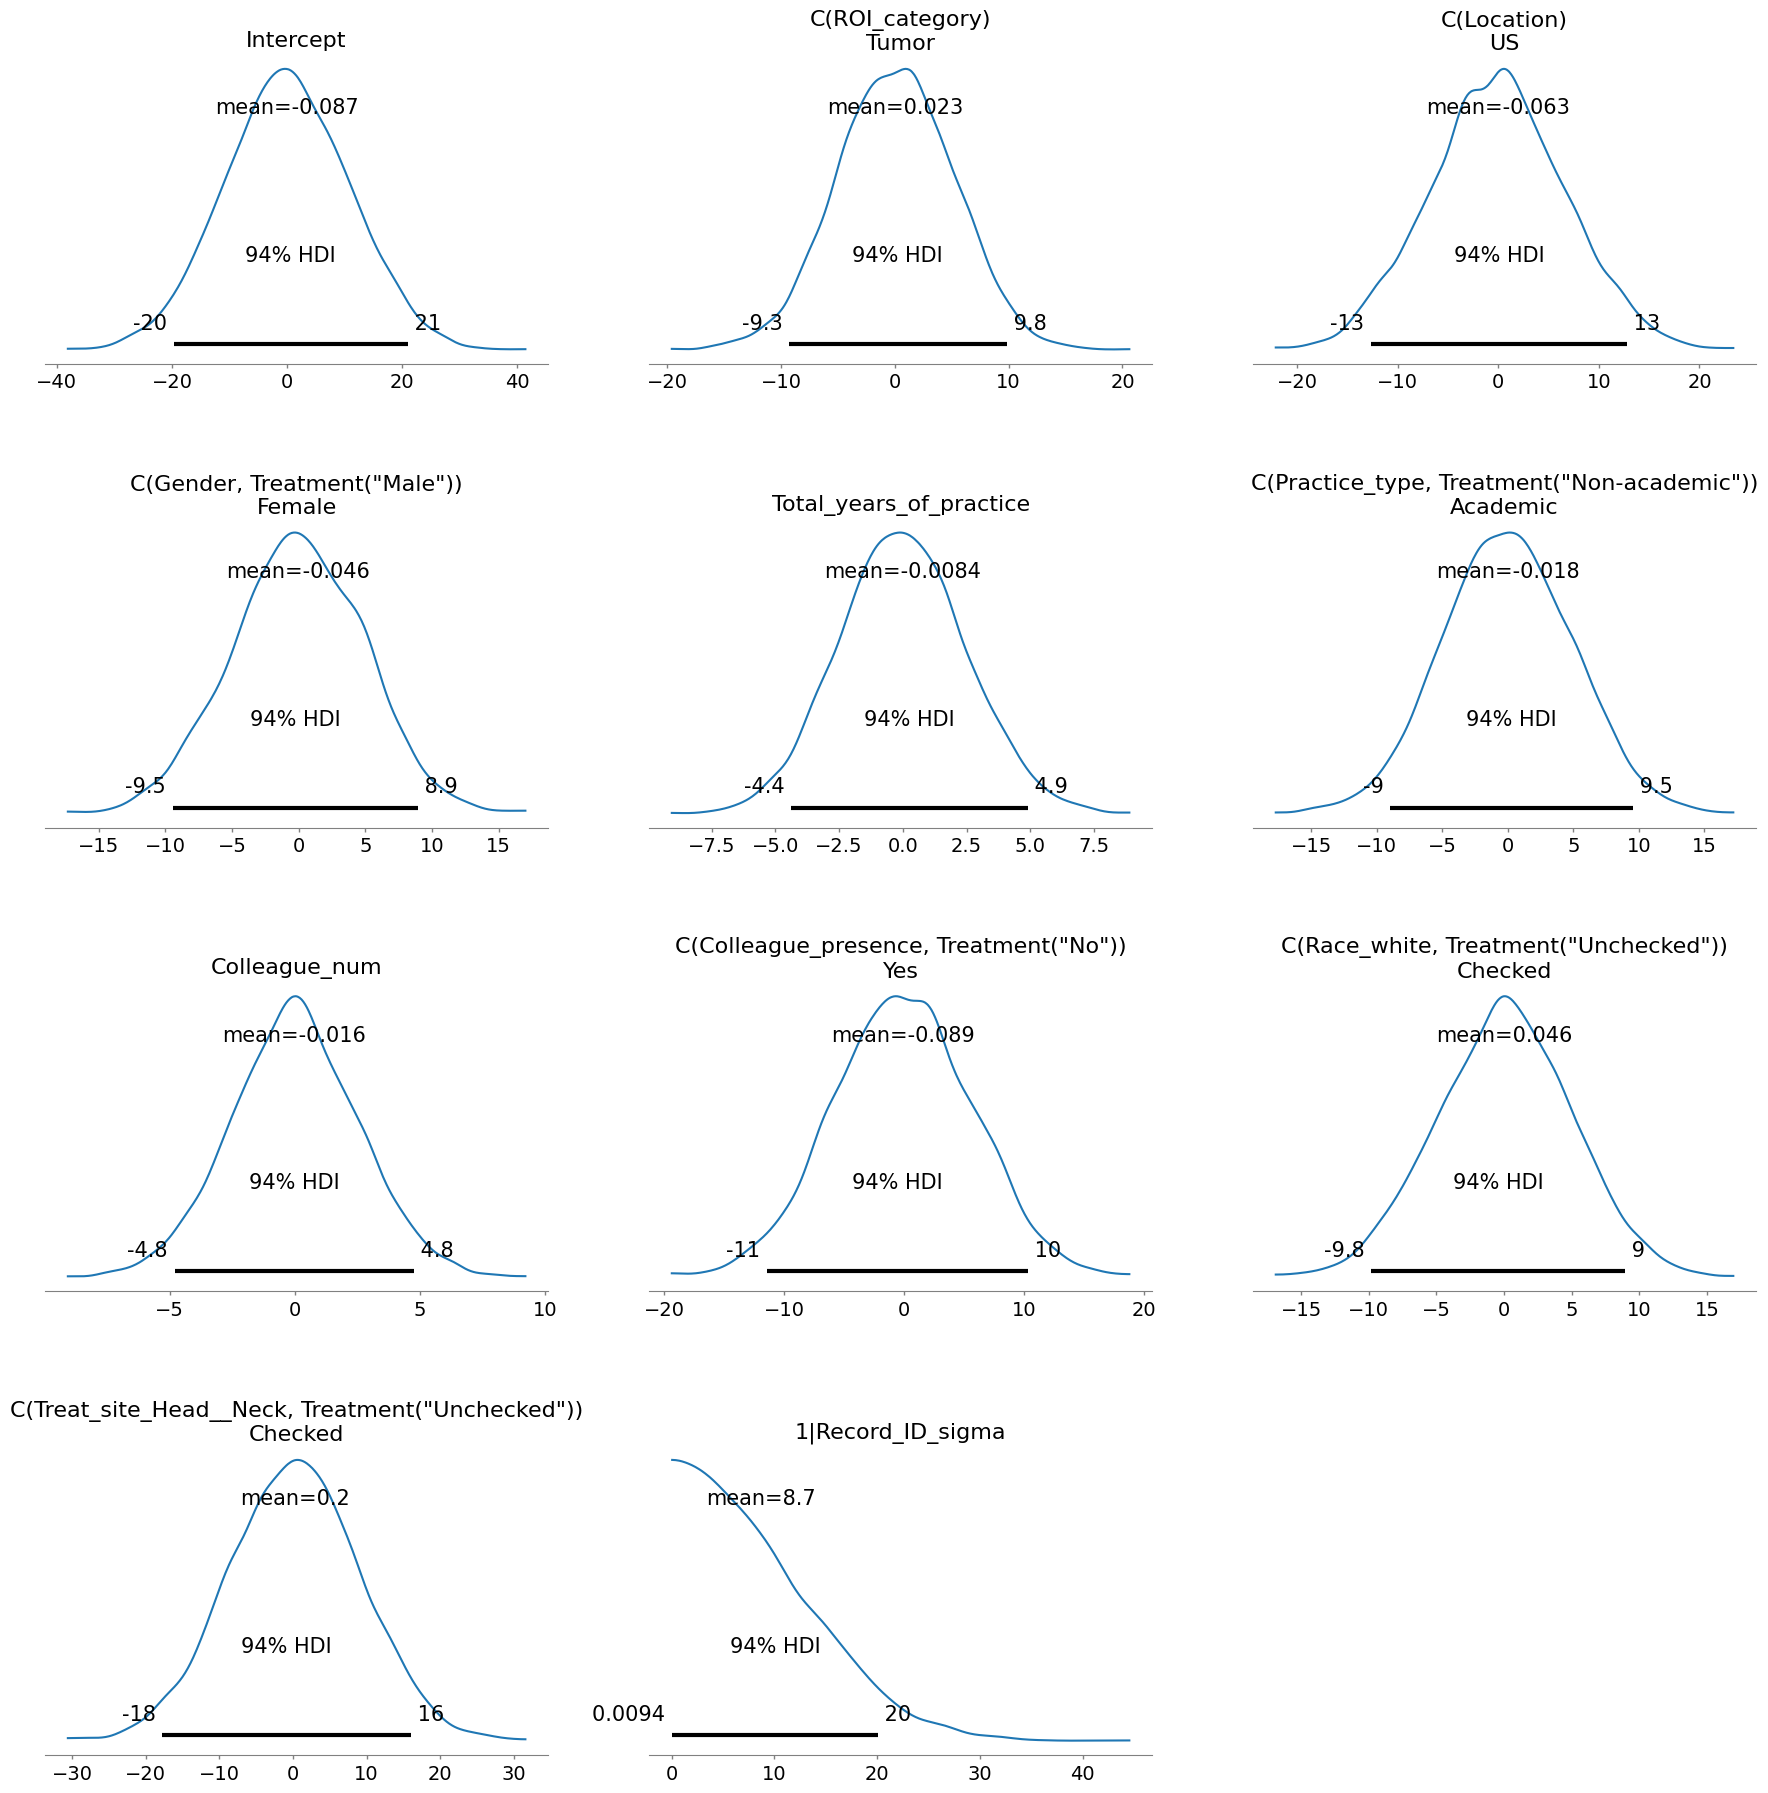

Modeling the probability that DSC_binary==1


DSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Gynecologic, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gynecologic, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 1620 seconds.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gynecologic, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


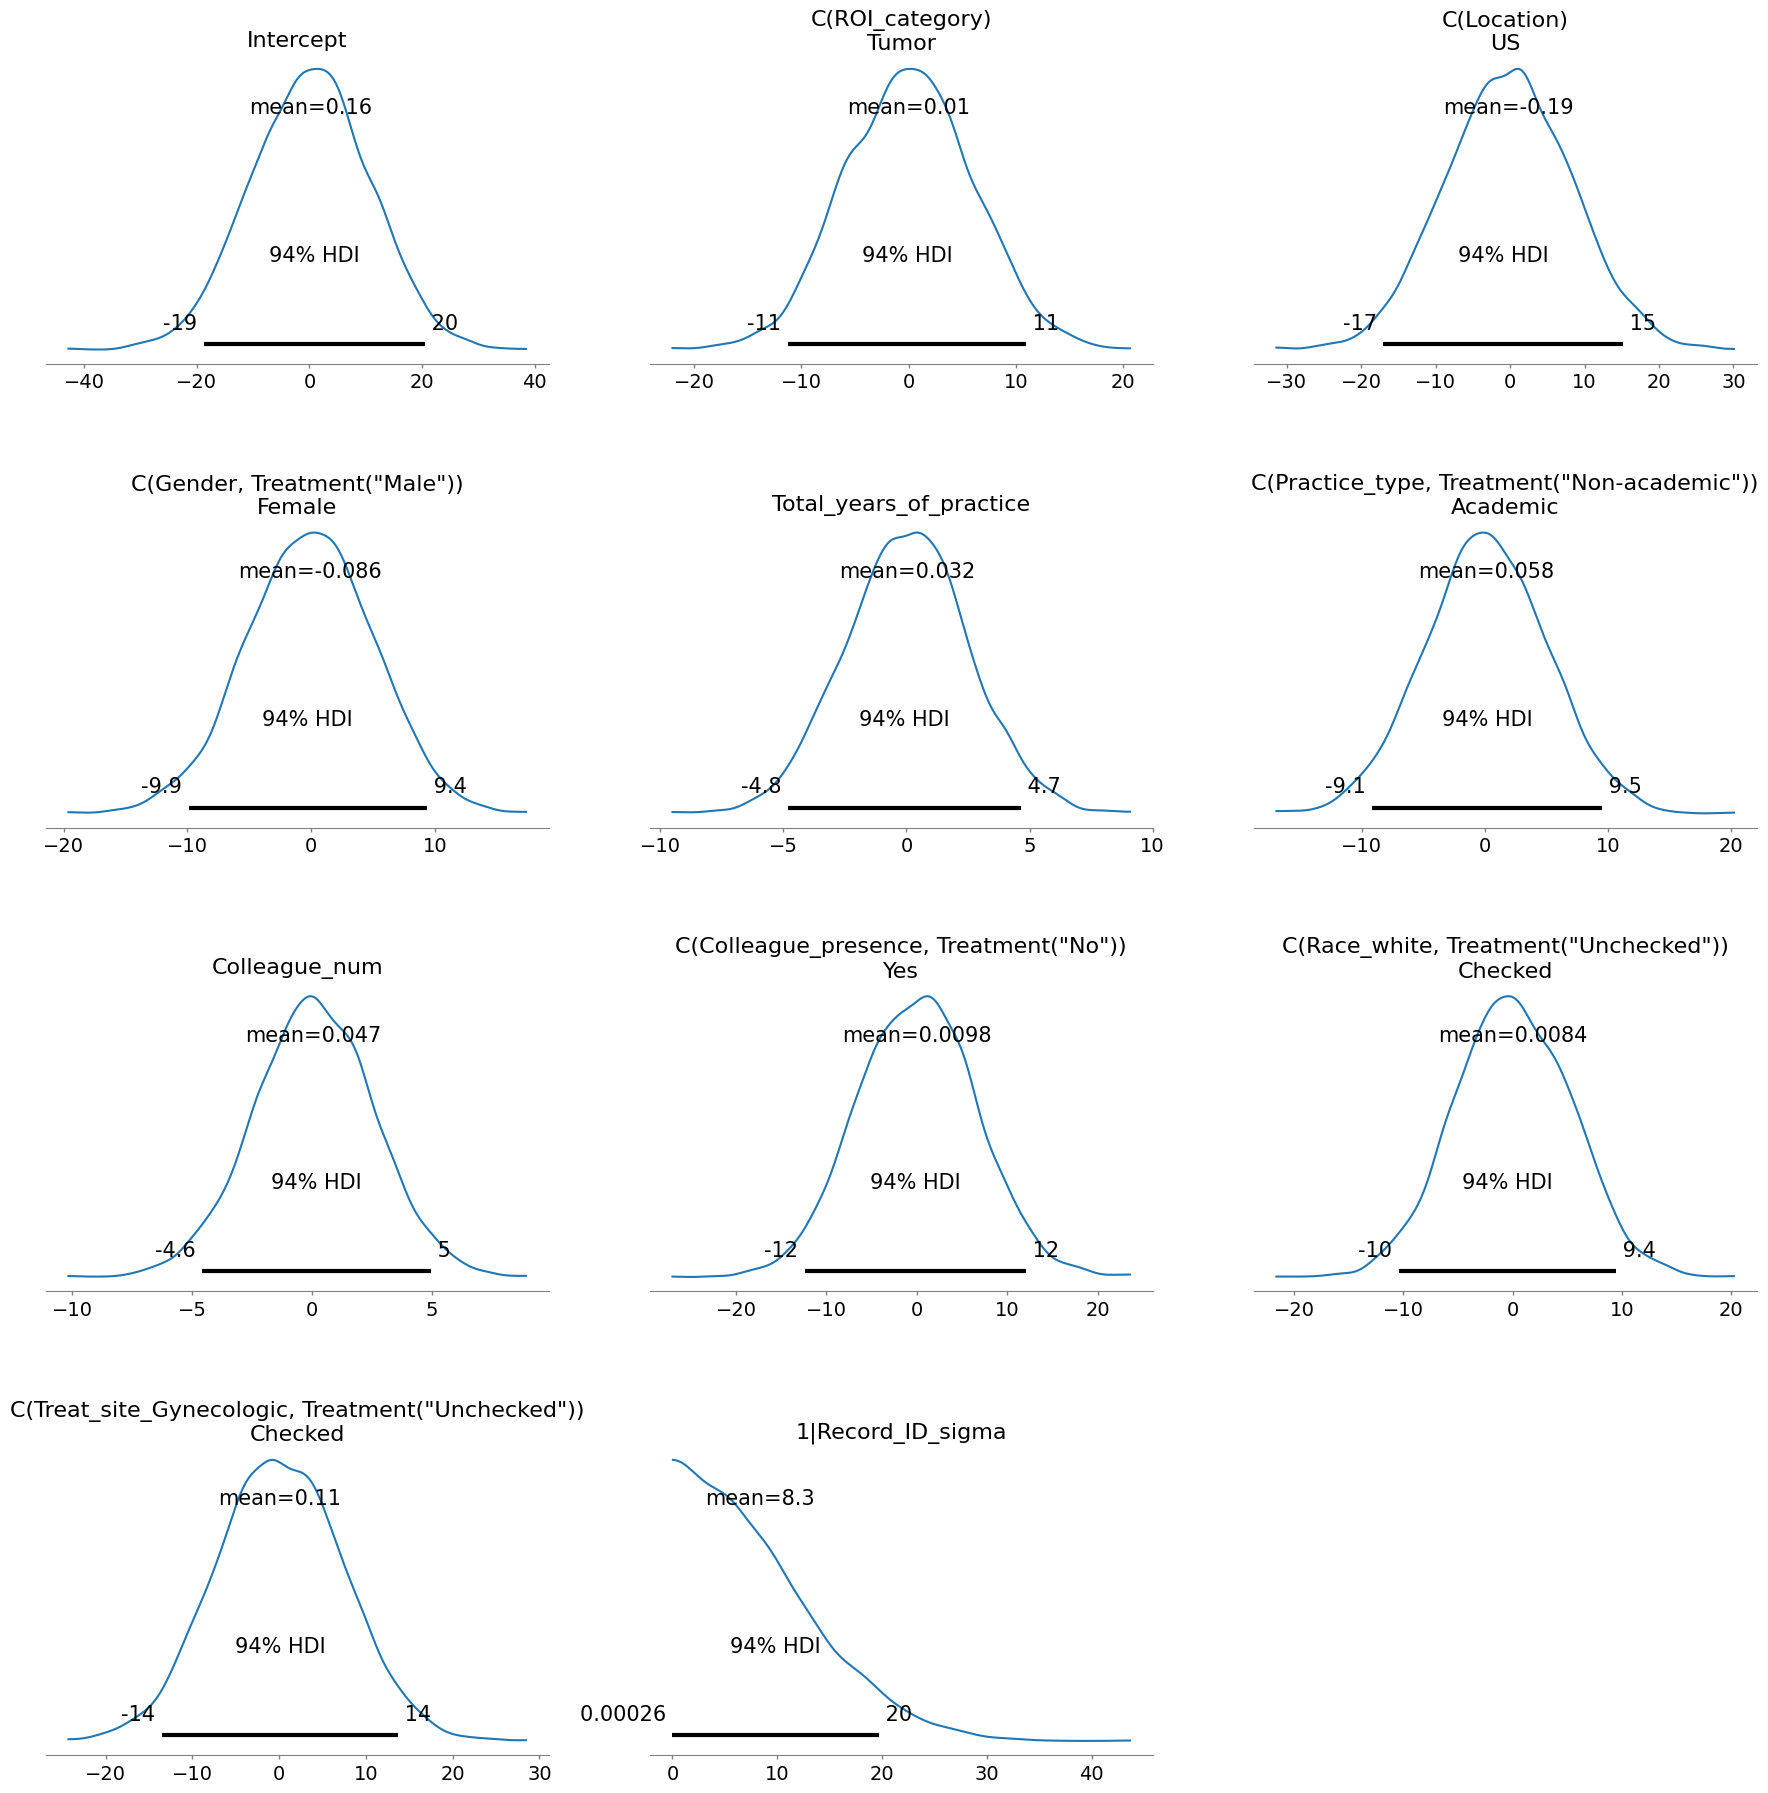

Modeling the probability that DSC_binary==1


DSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Gastrointestinal, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gastrointestinal, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 868 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gastrointestinal, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


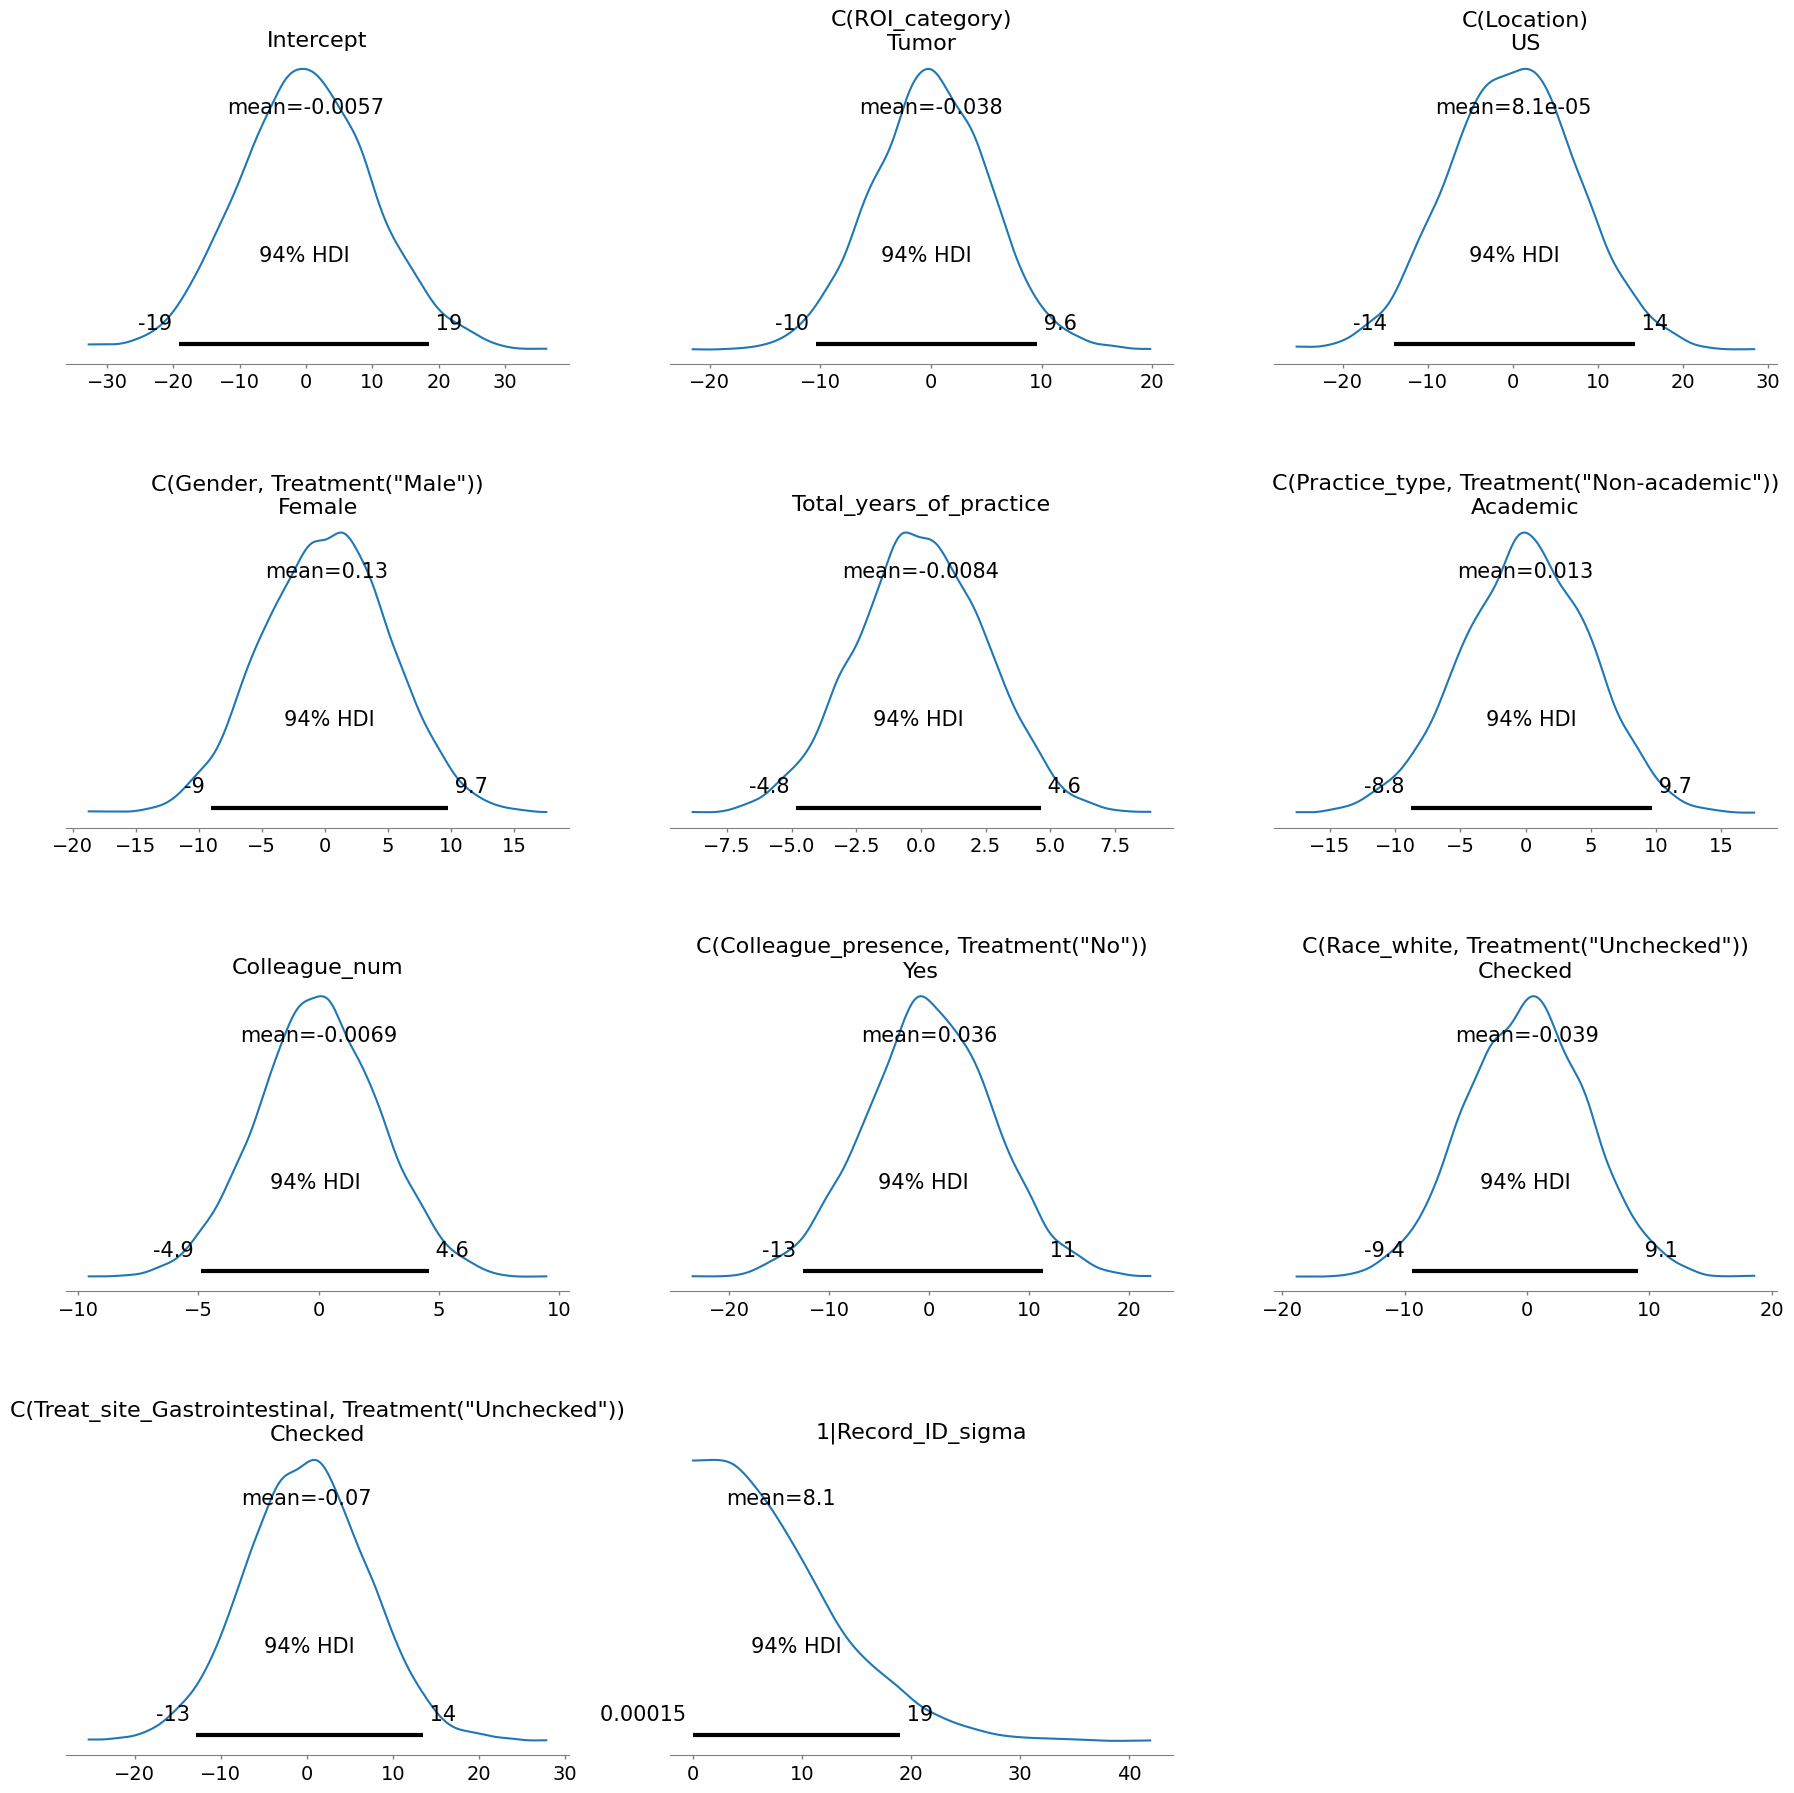

Modeling the probability that SDSC_binary==1


SDSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Breast, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Breast, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 6513 seconds.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Breast, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


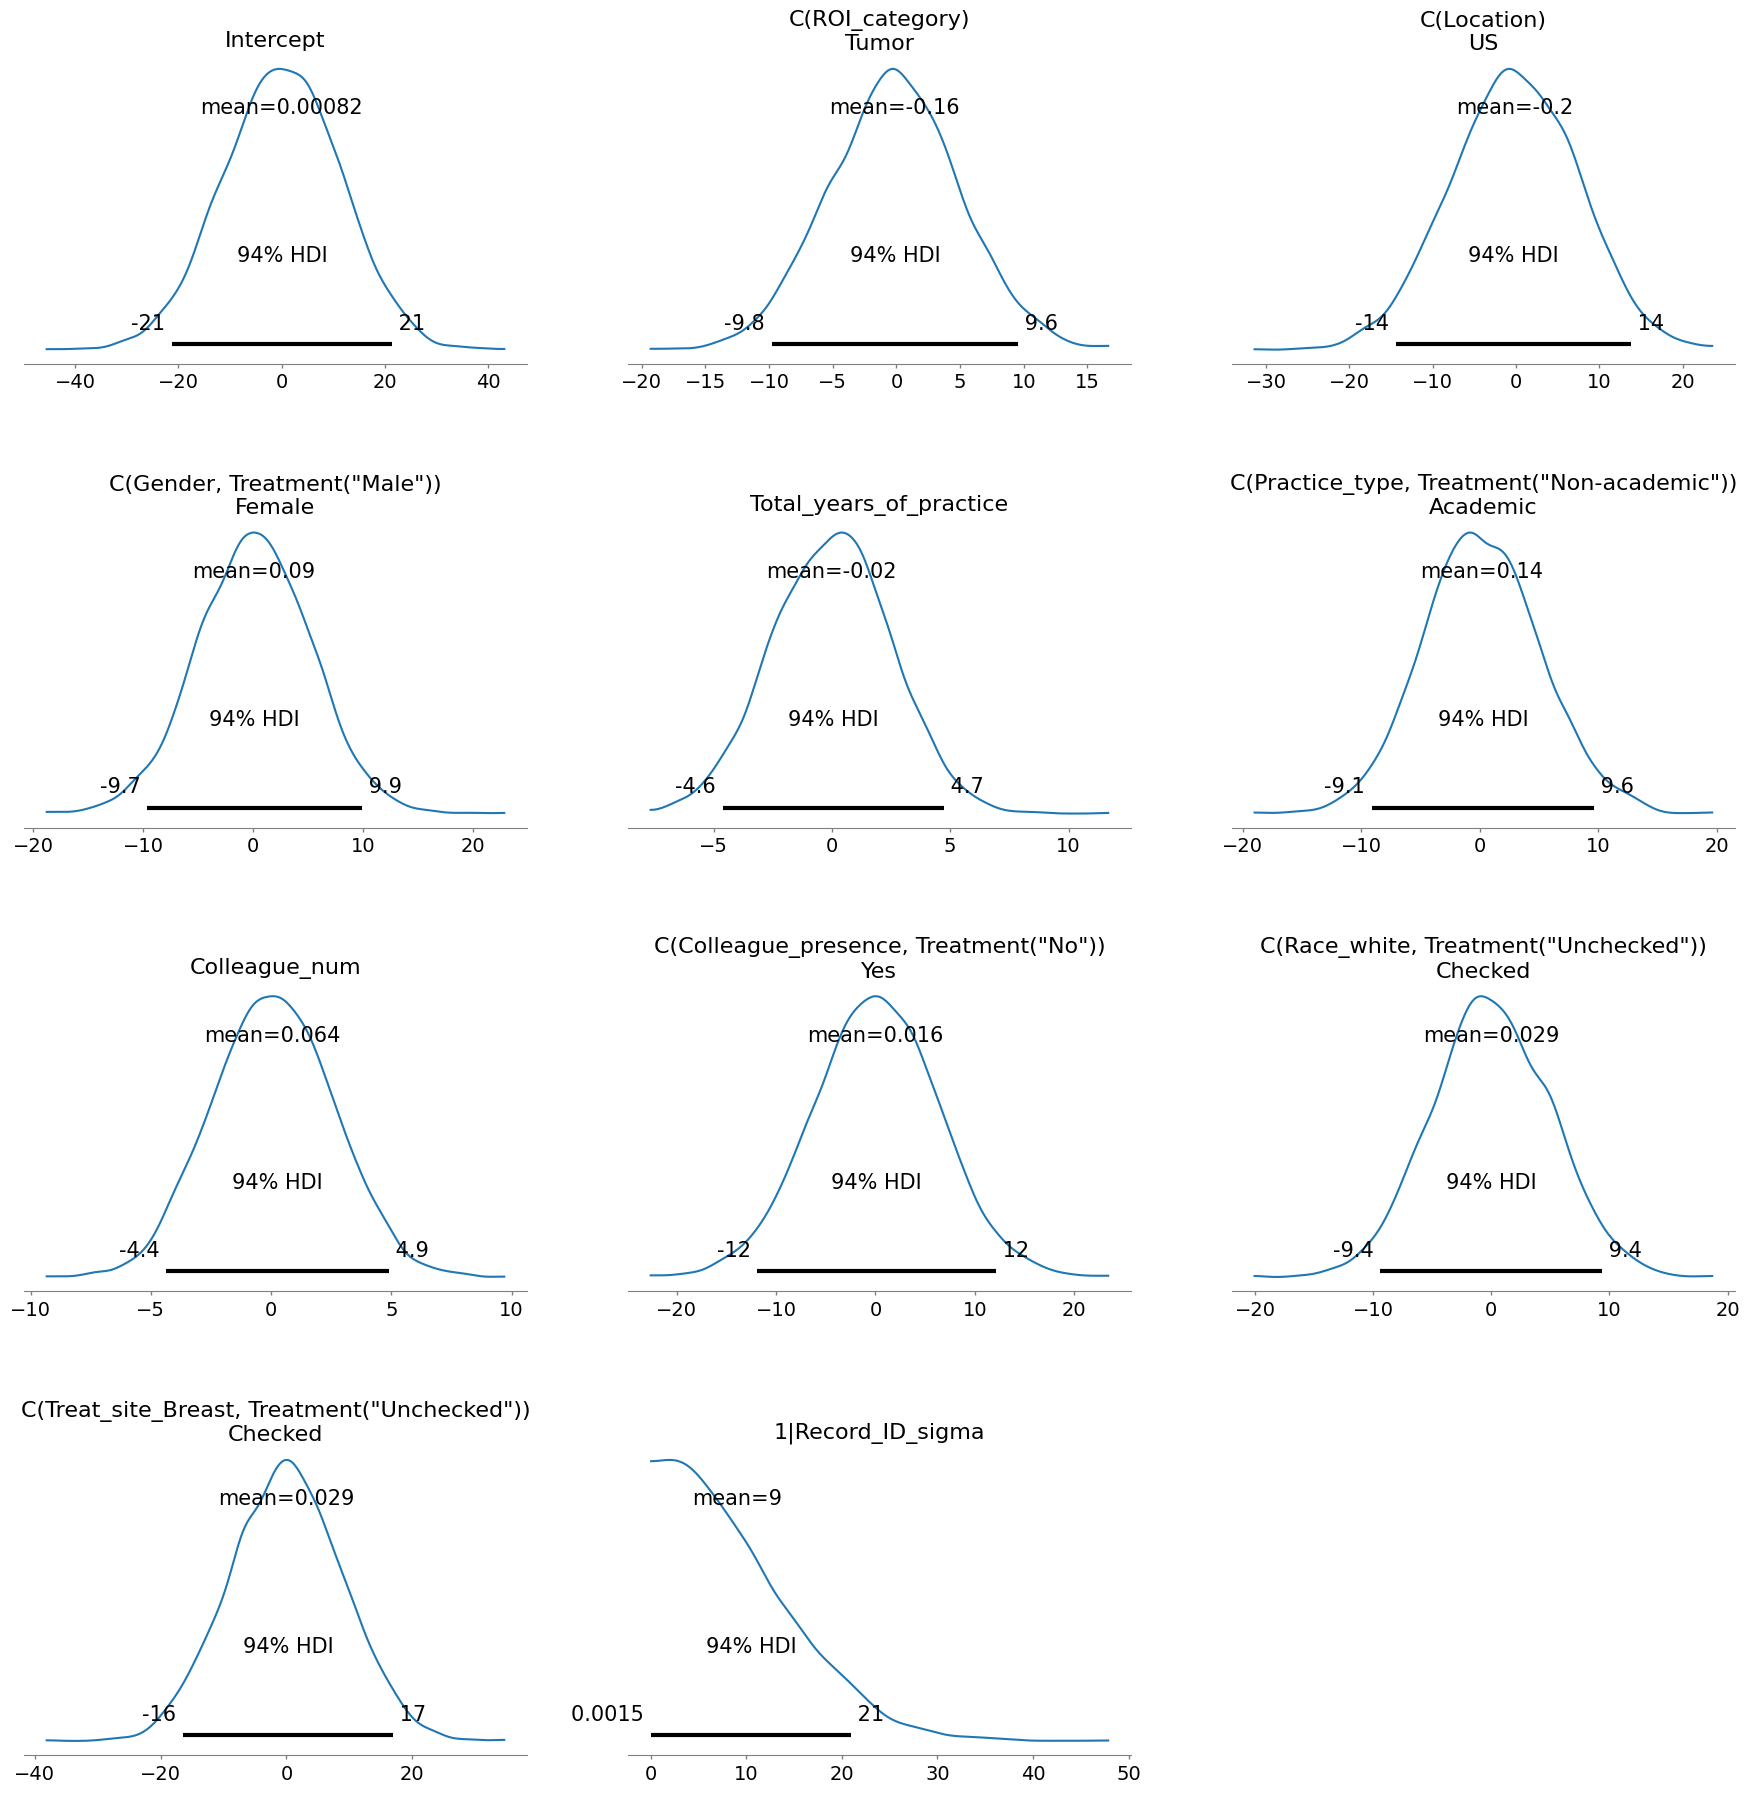

Modeling the probability that SDSC_binary==1


SDSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Sarcoma, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Sarcoma, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 1842 seconds.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Sarcoma, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


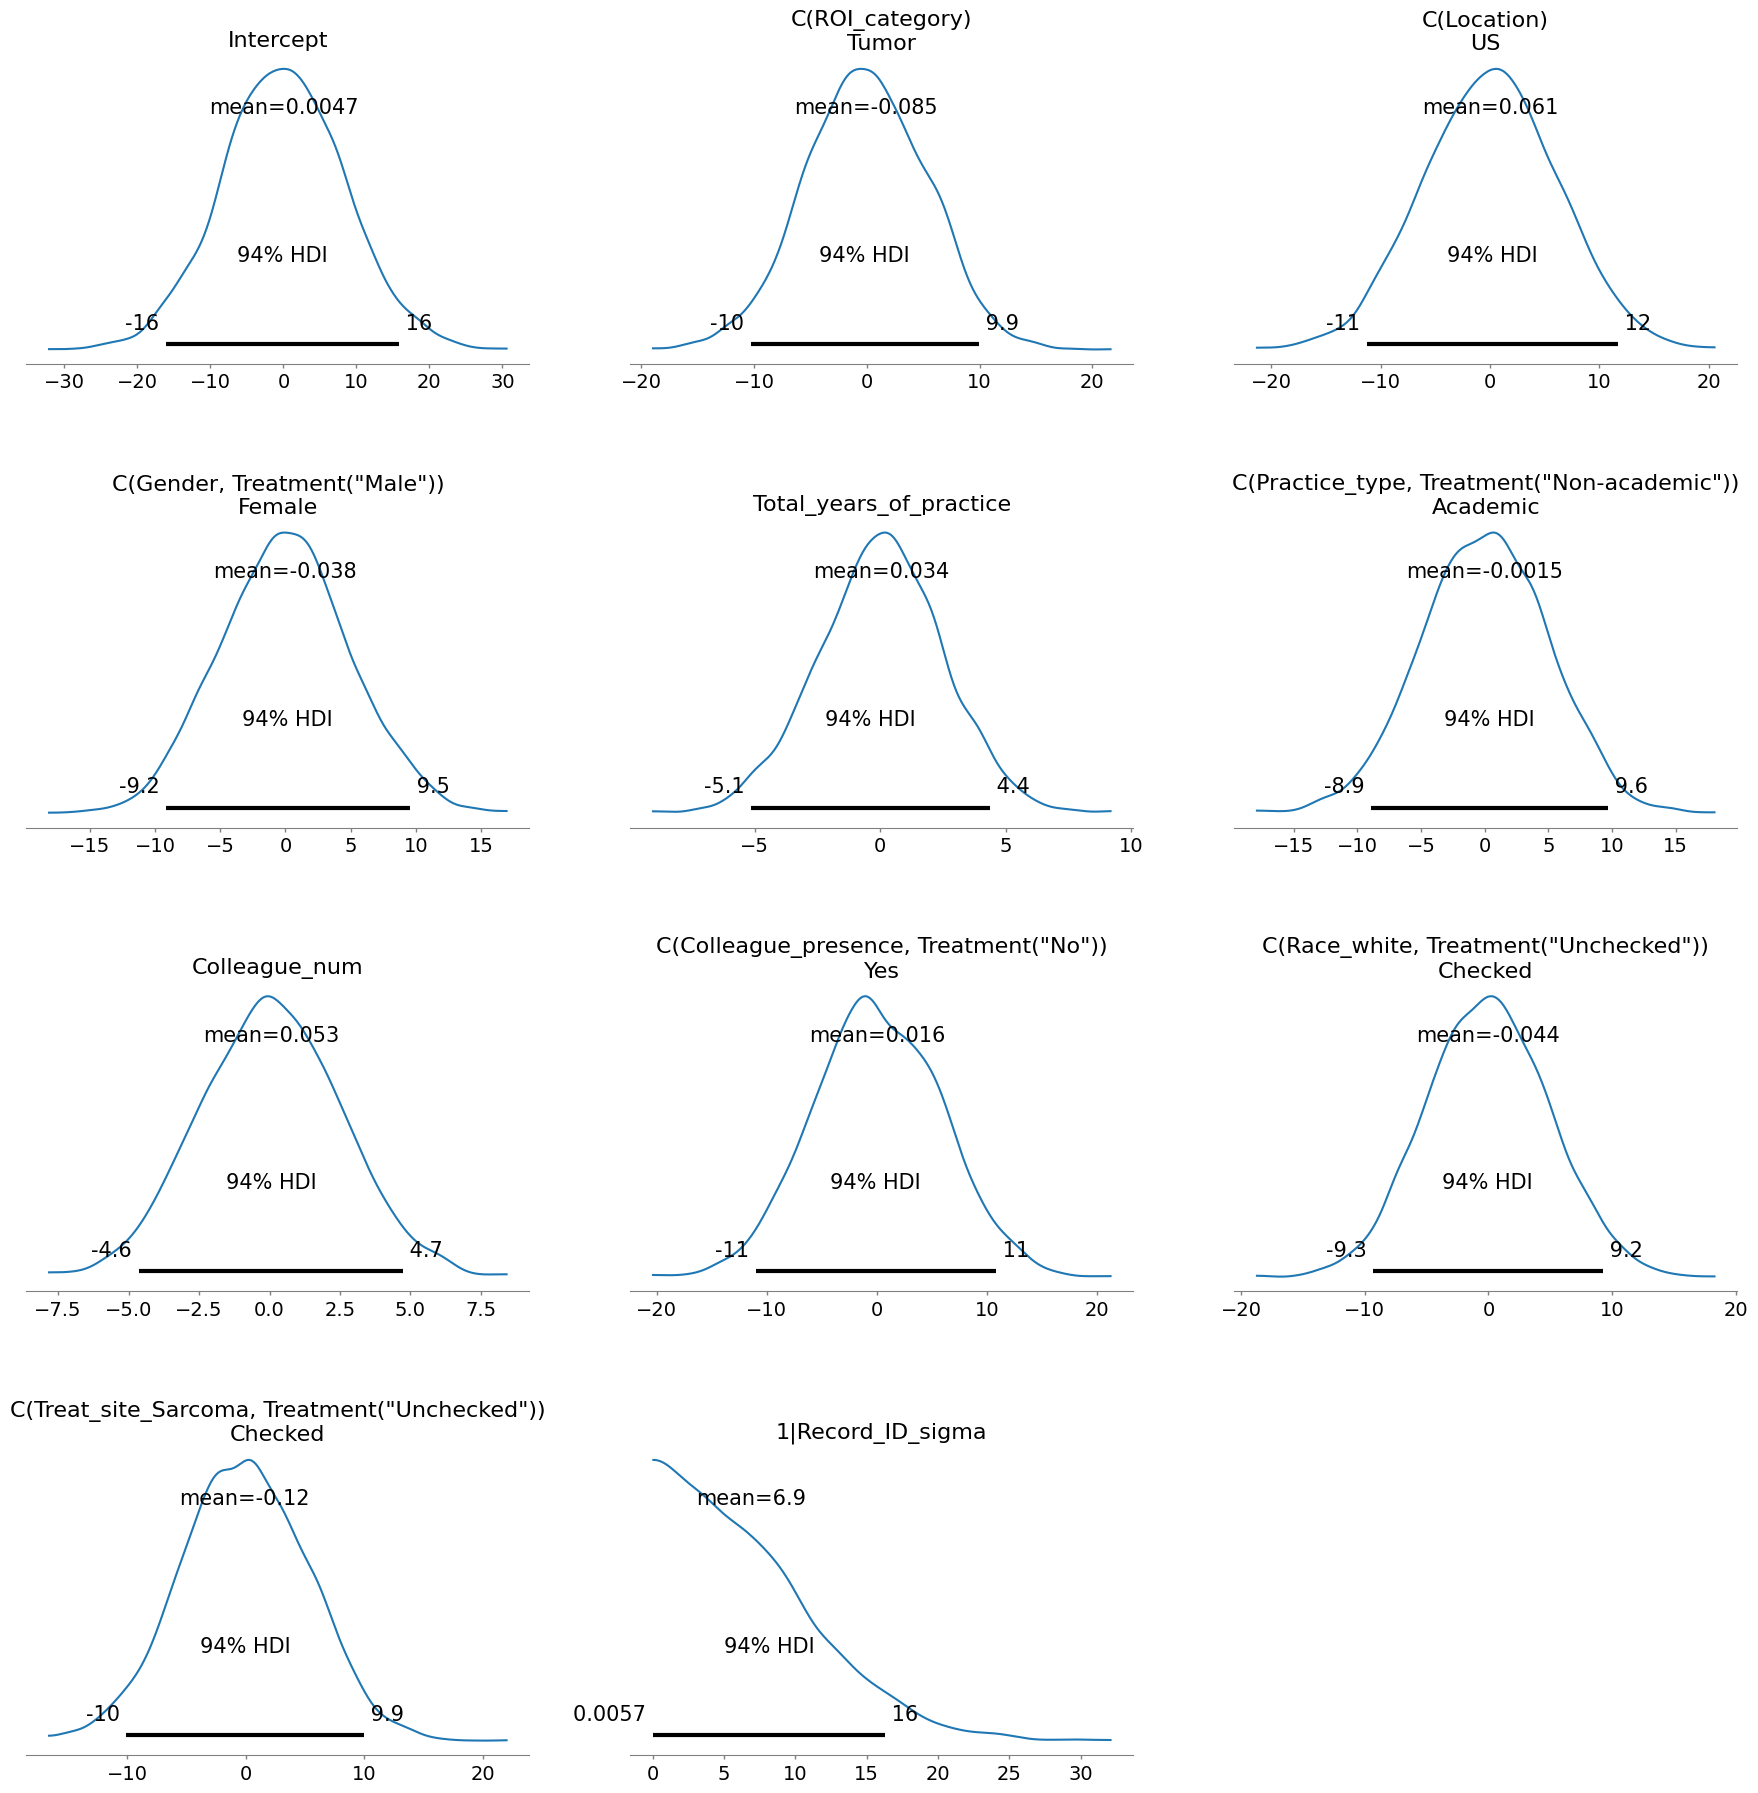

SDSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Head__Neck, Treatment("Unchecked"))


Modeling the probability that SDSC_binary==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Head__Neck, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 5456 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Head__Neck, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


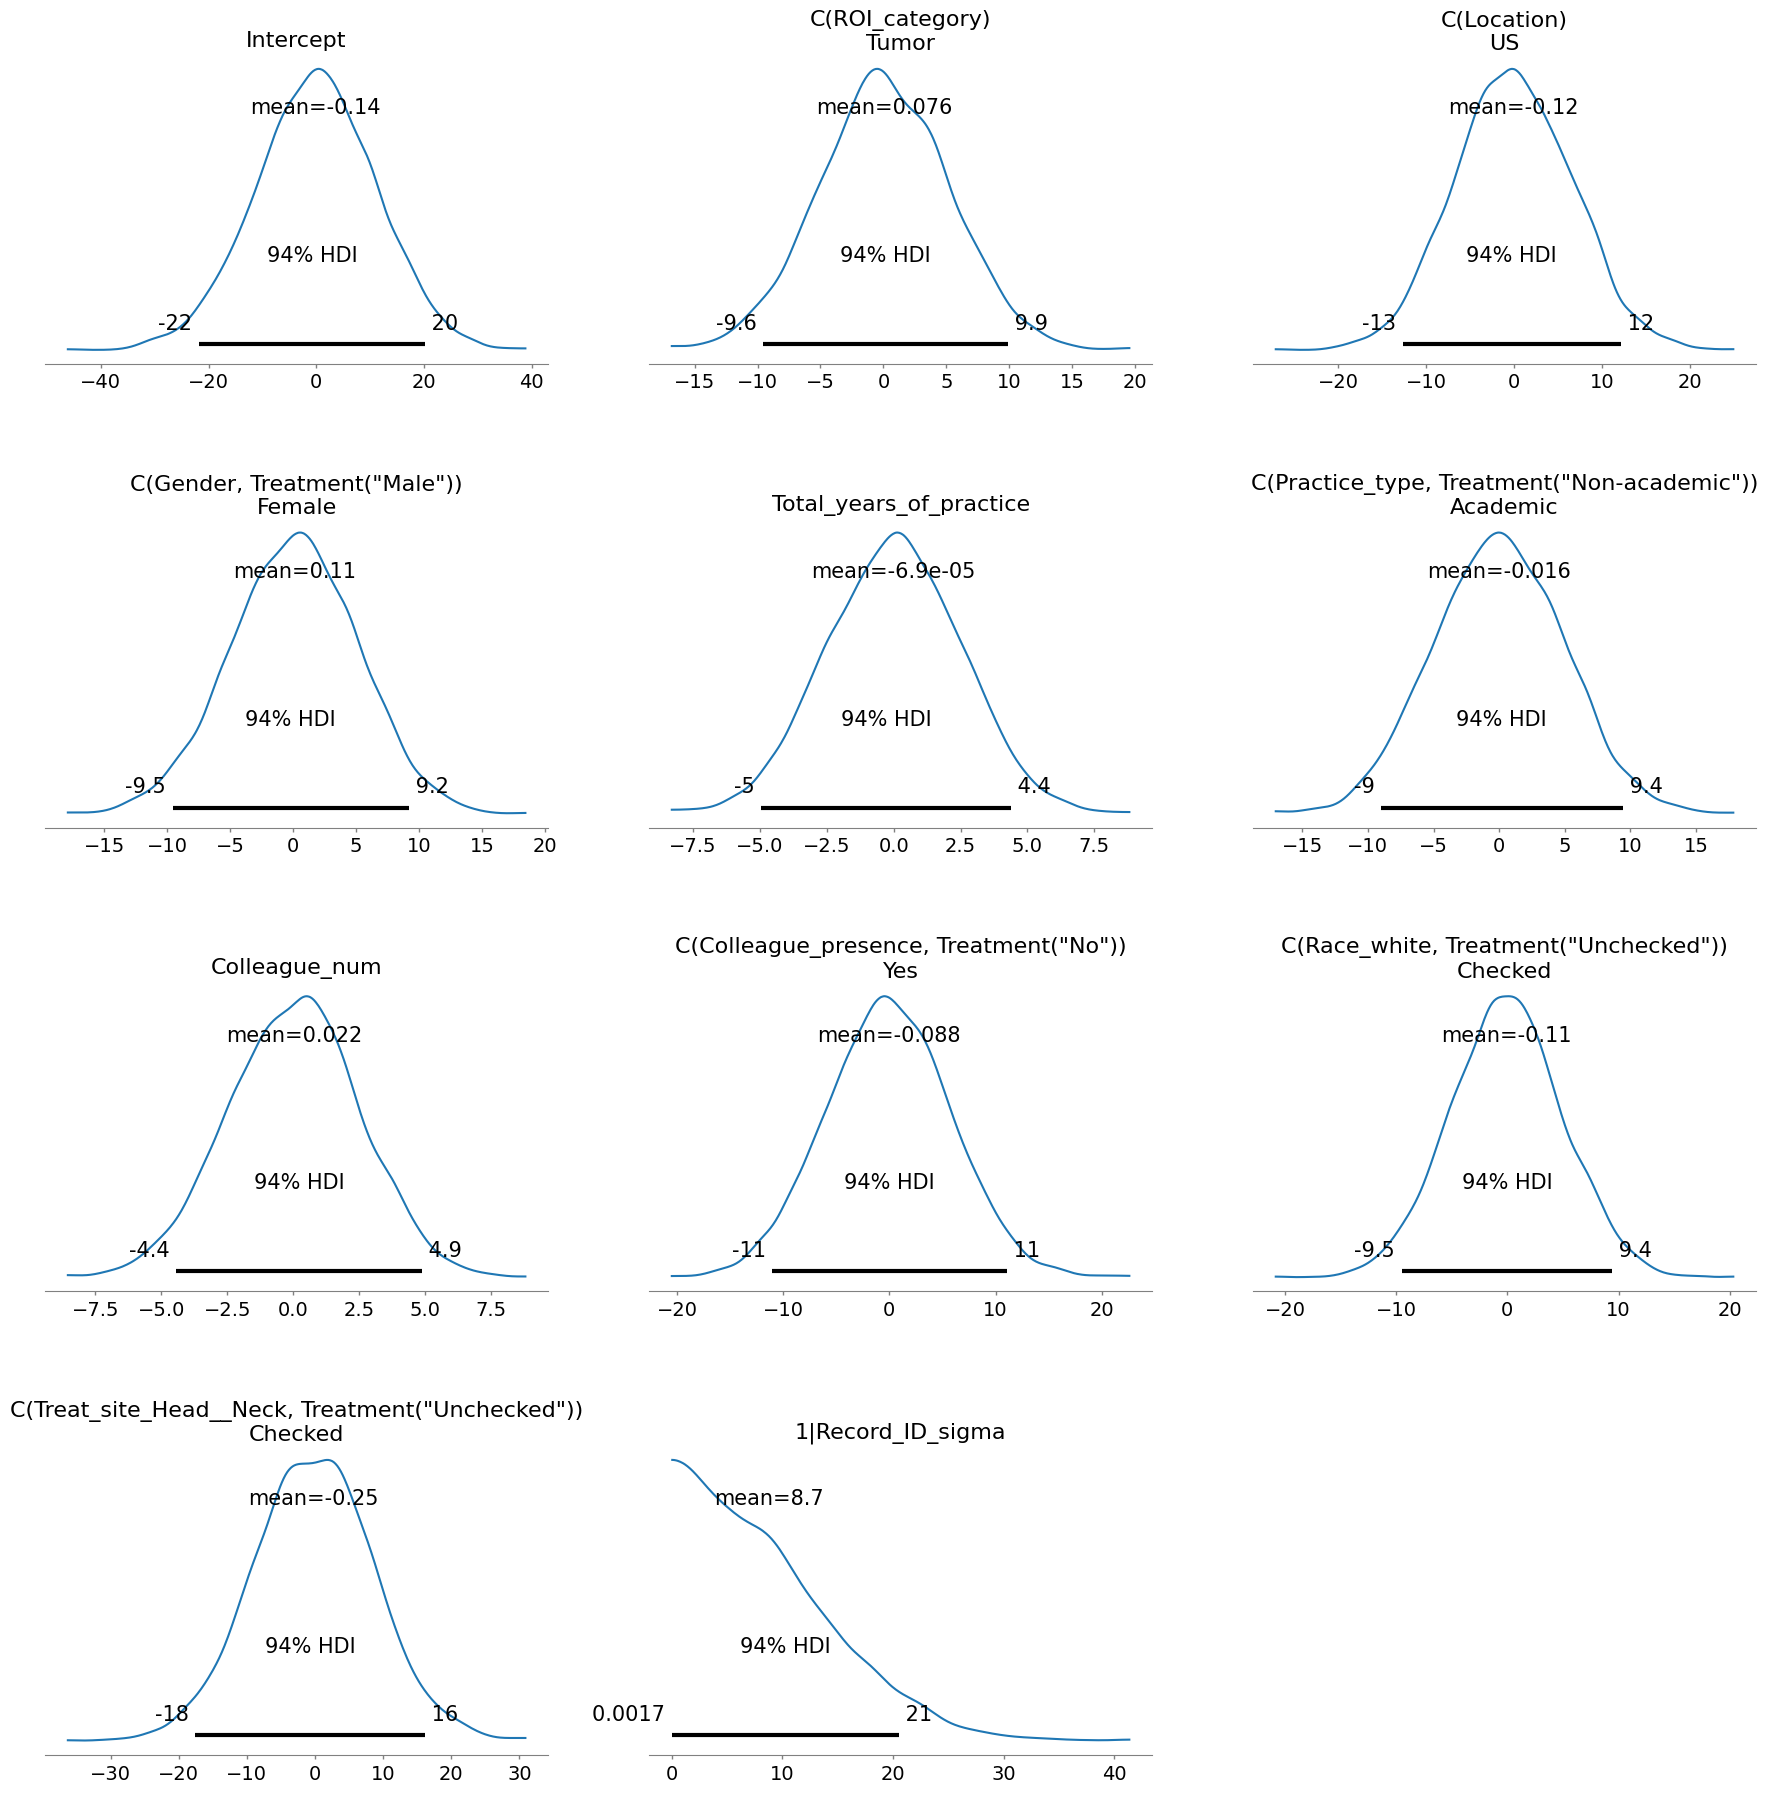

Modeling the probability that SDSC_binary==1


SDSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Gynecologic, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gynecologic, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 1763 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gynecologic, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


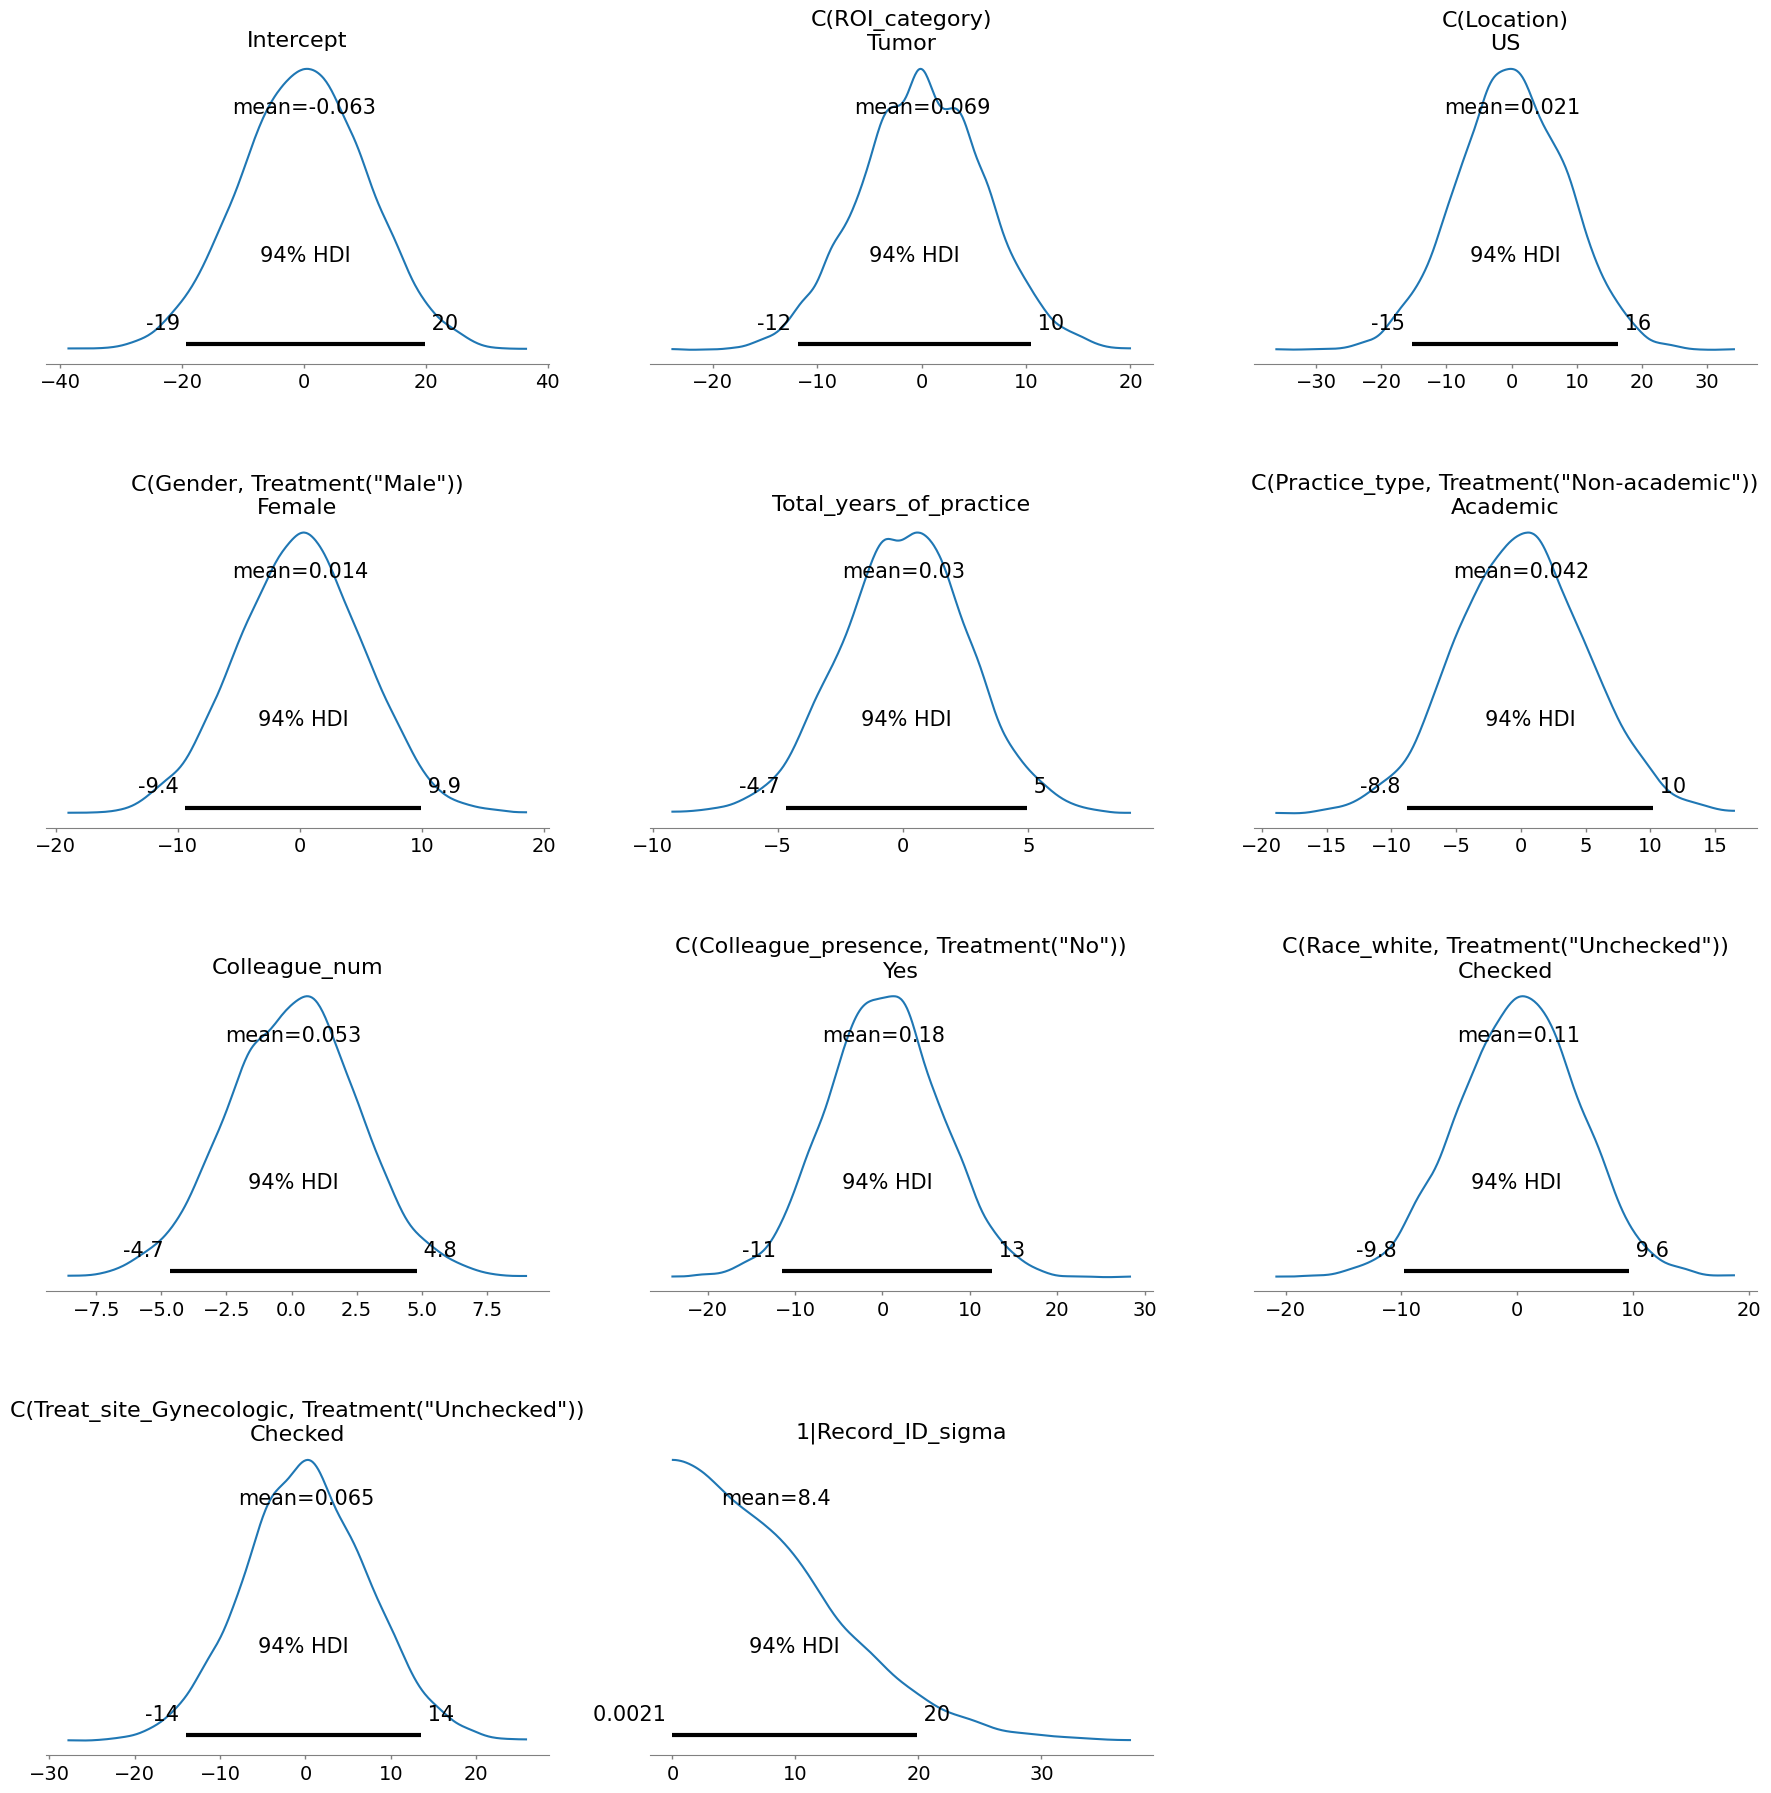

Modeling the probability that SDSC_binary==1


SDSC_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Gastrointestinal, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gastrointestinal, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 1004 seconds.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gastrointestinal, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


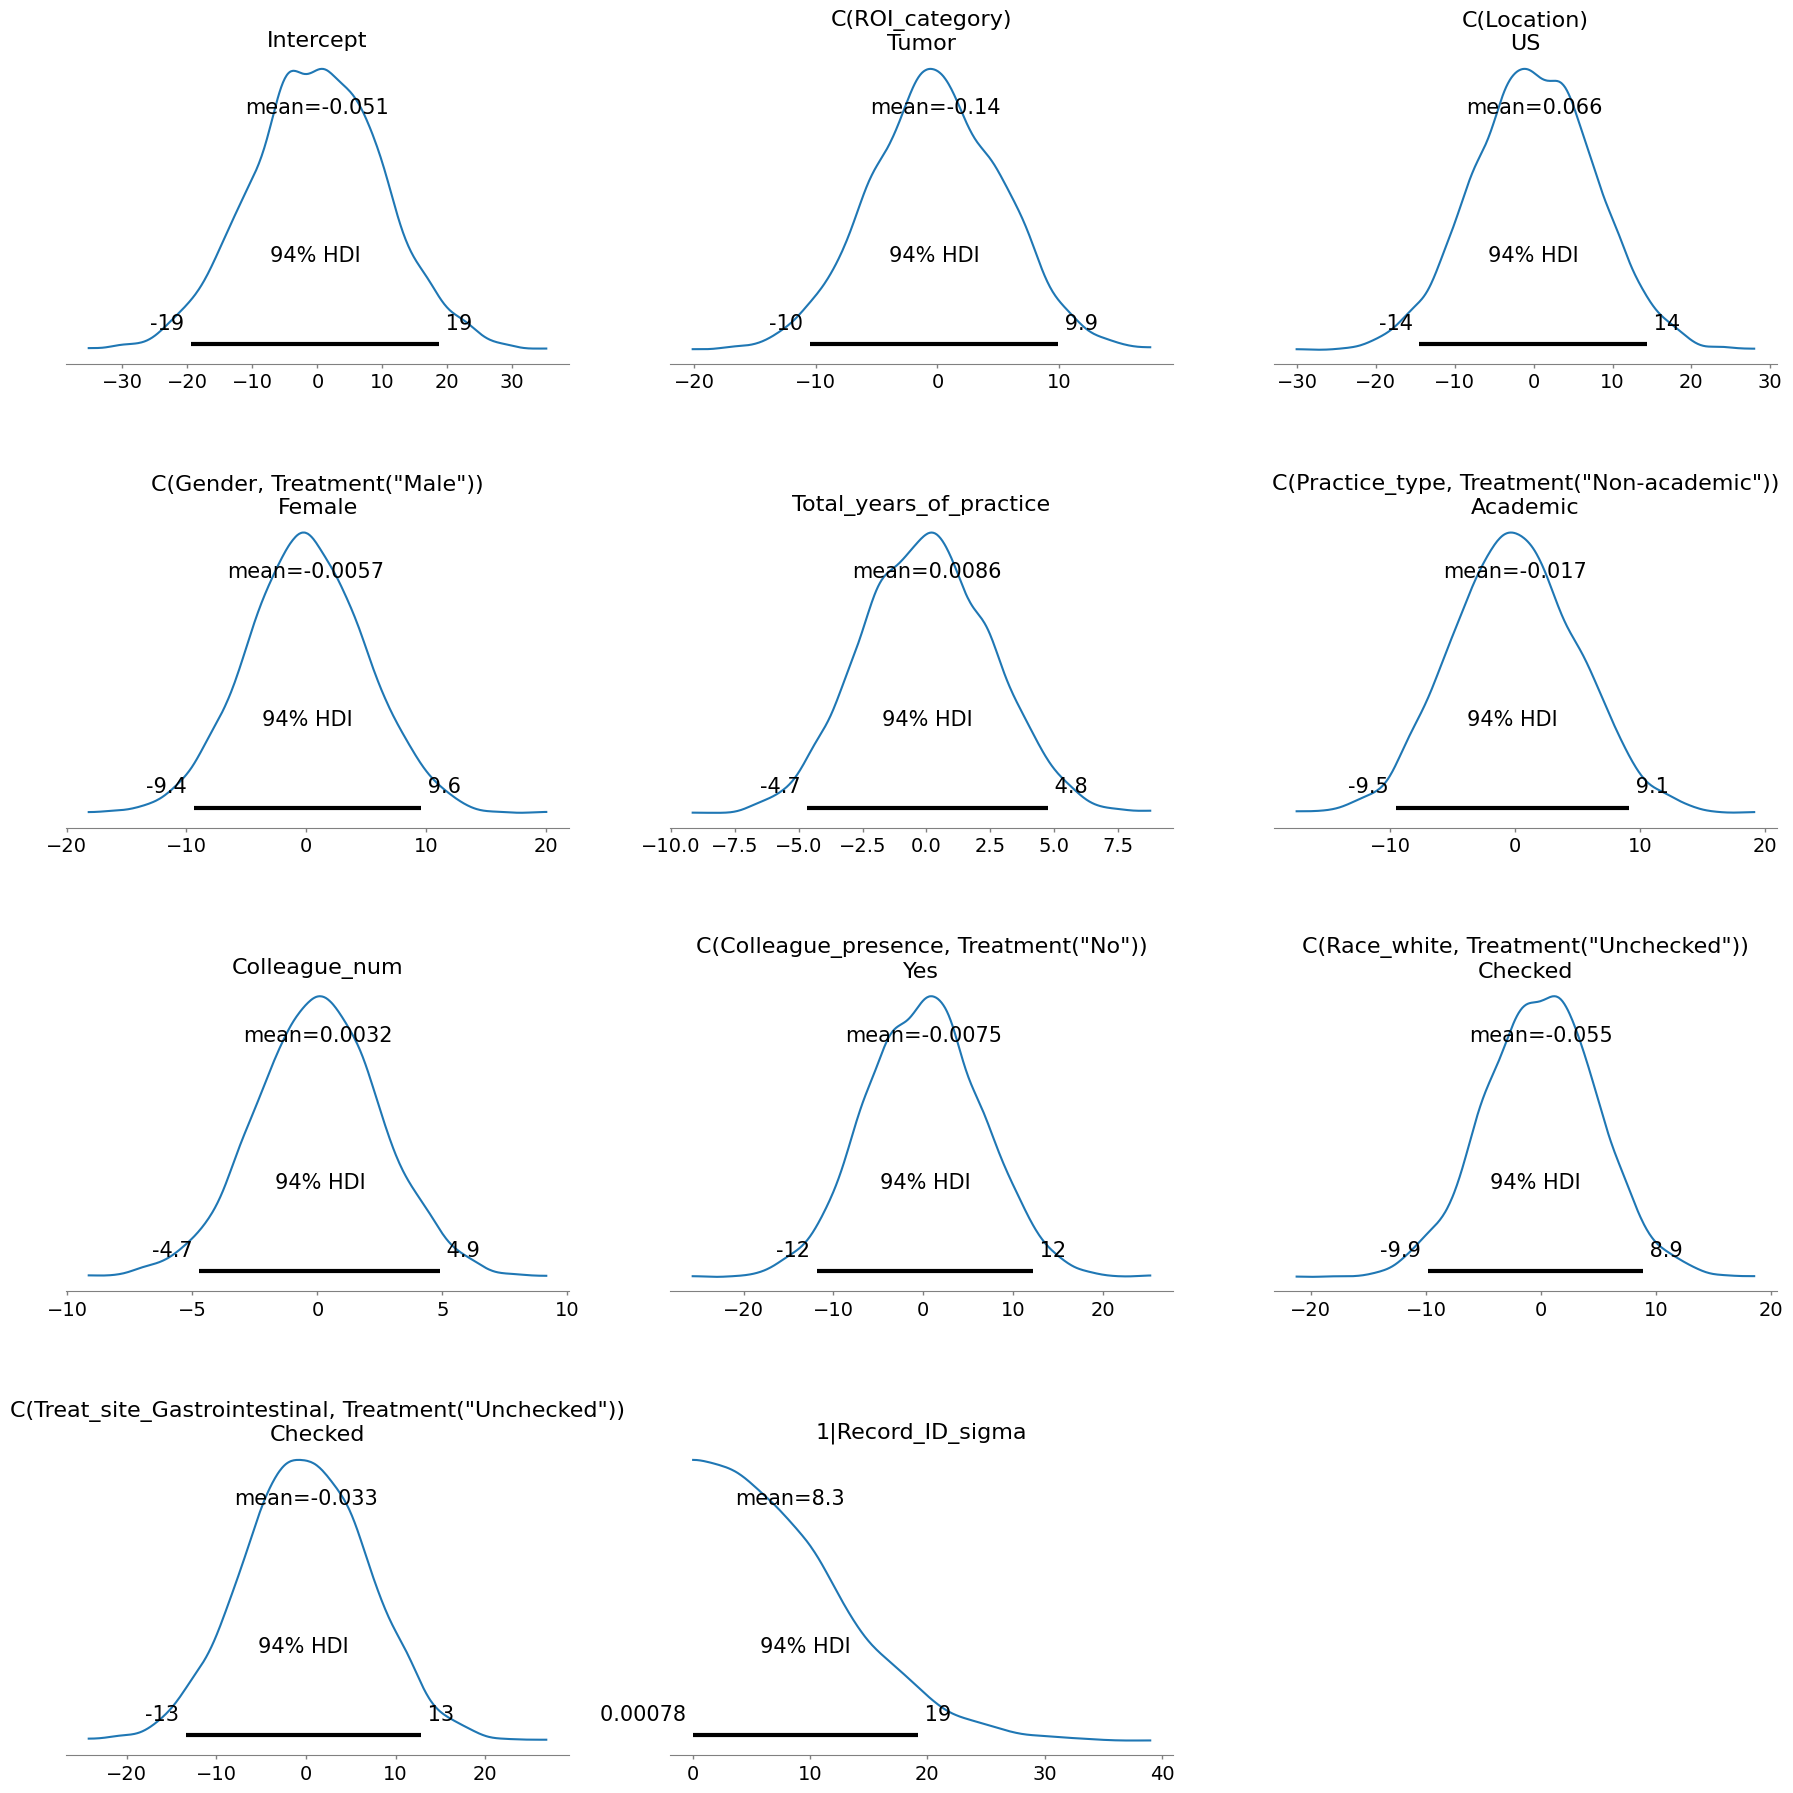

HD95_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Breast, Treatment("Unchecked"))


Modeling the probability that HD95_binary==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Breast, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 6929 seconds.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Breast, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


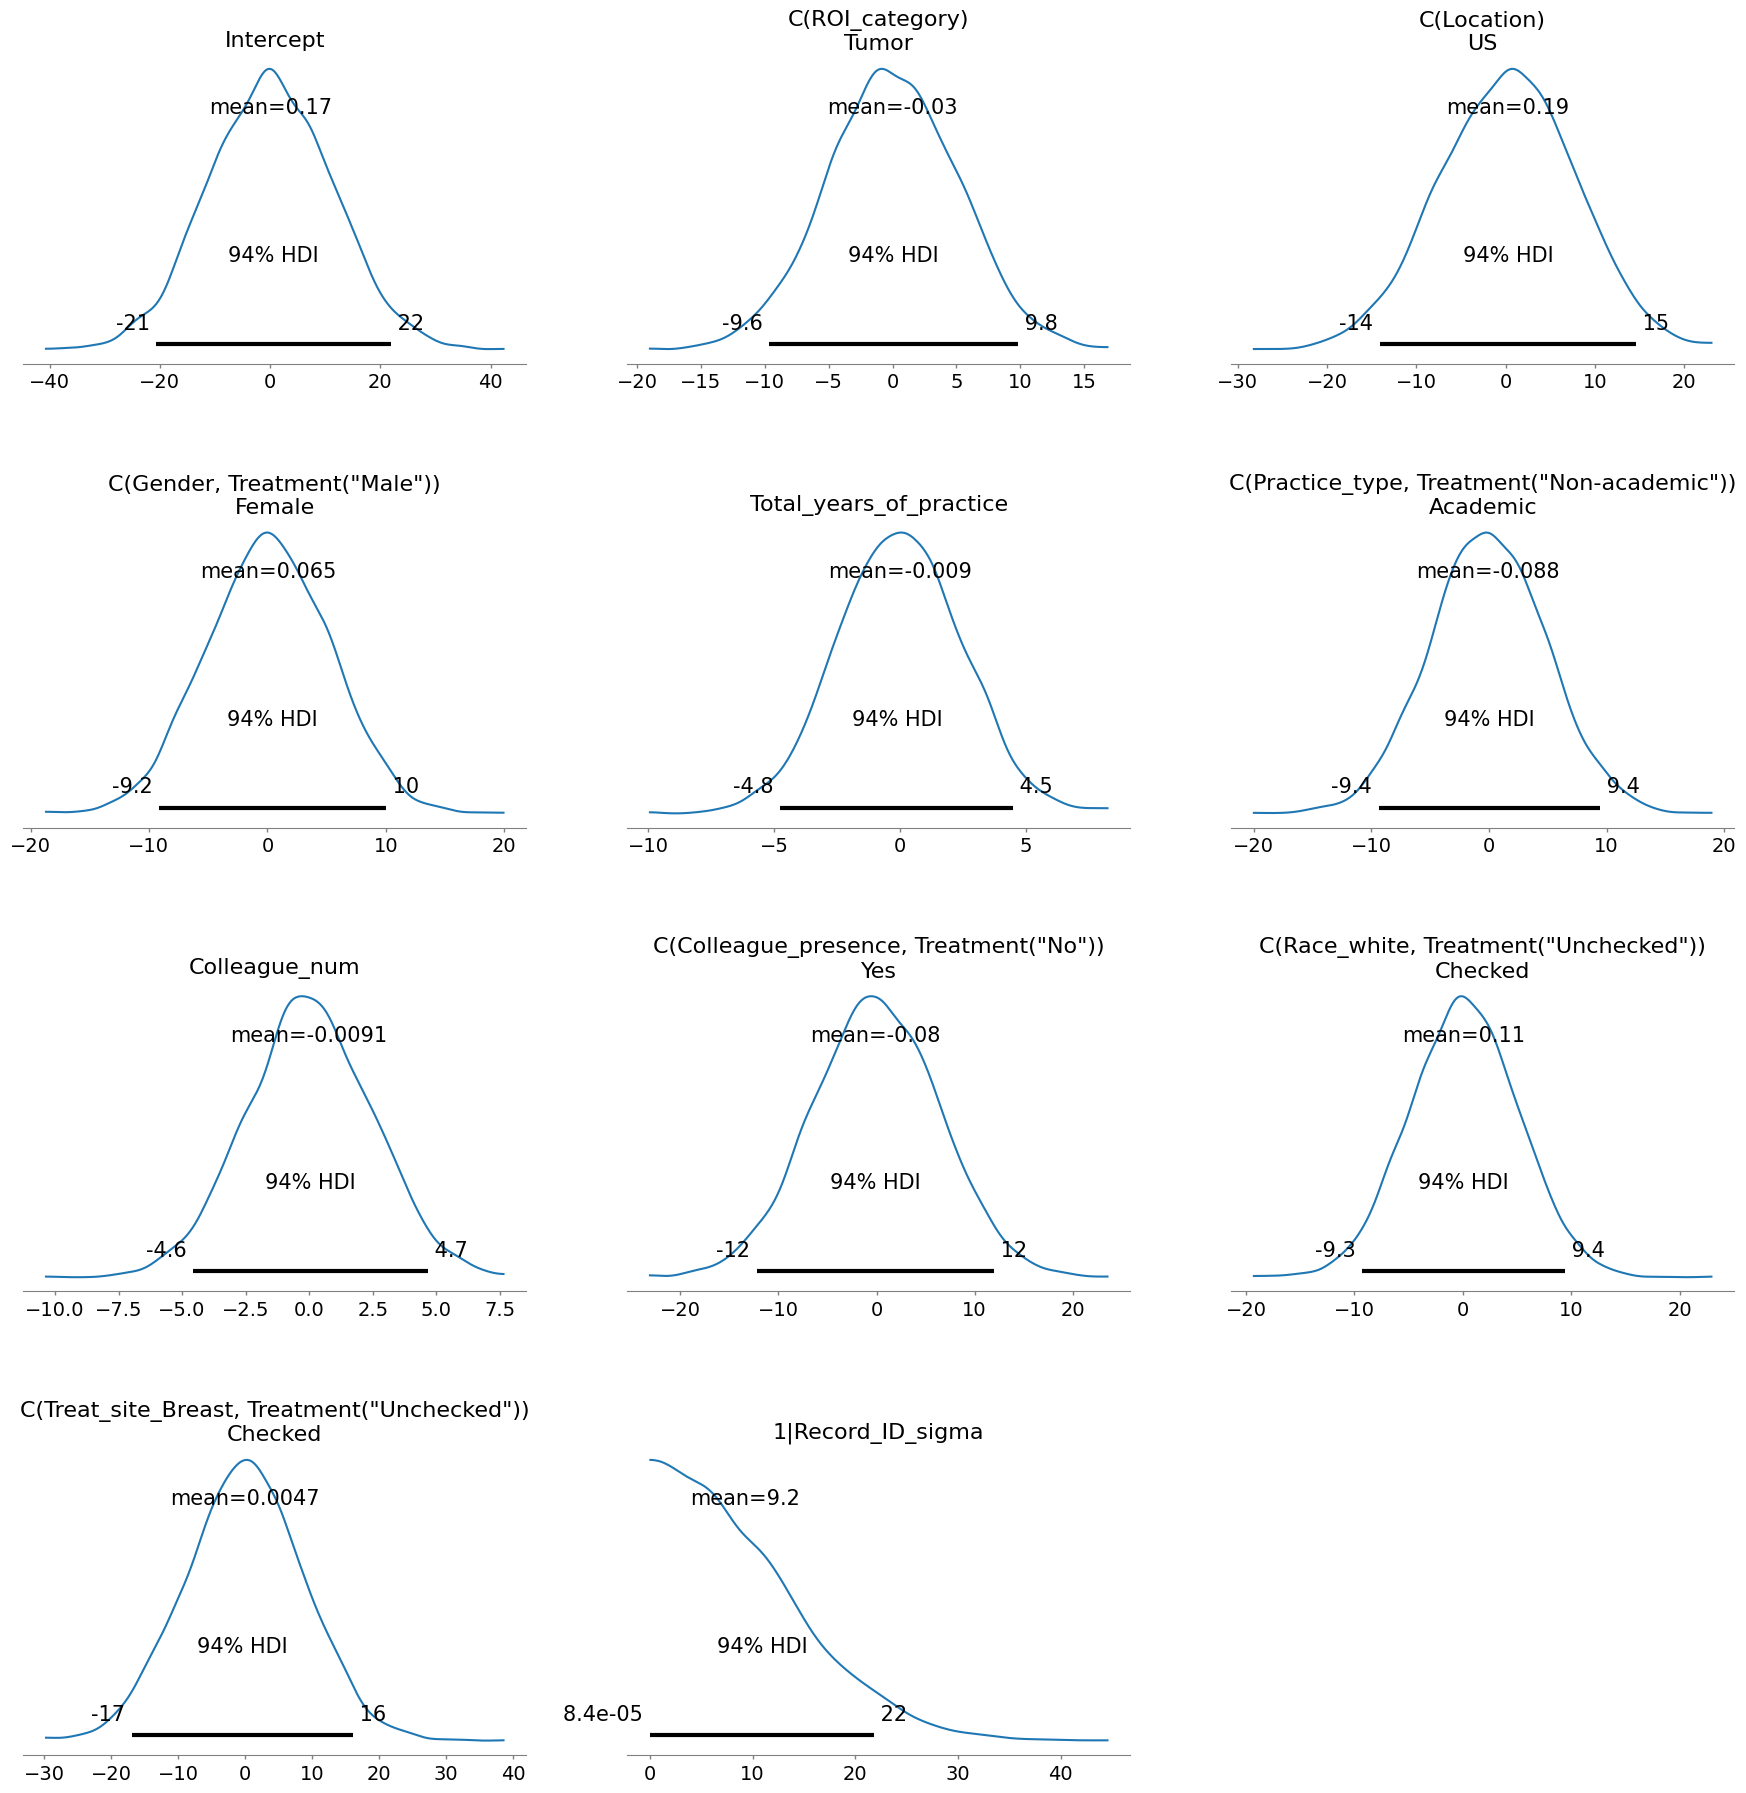

Modeling the probability that HD95_binary==1


HD95_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Sarcoma, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Sarcoma, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 1832 seconds.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Sarcoma, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


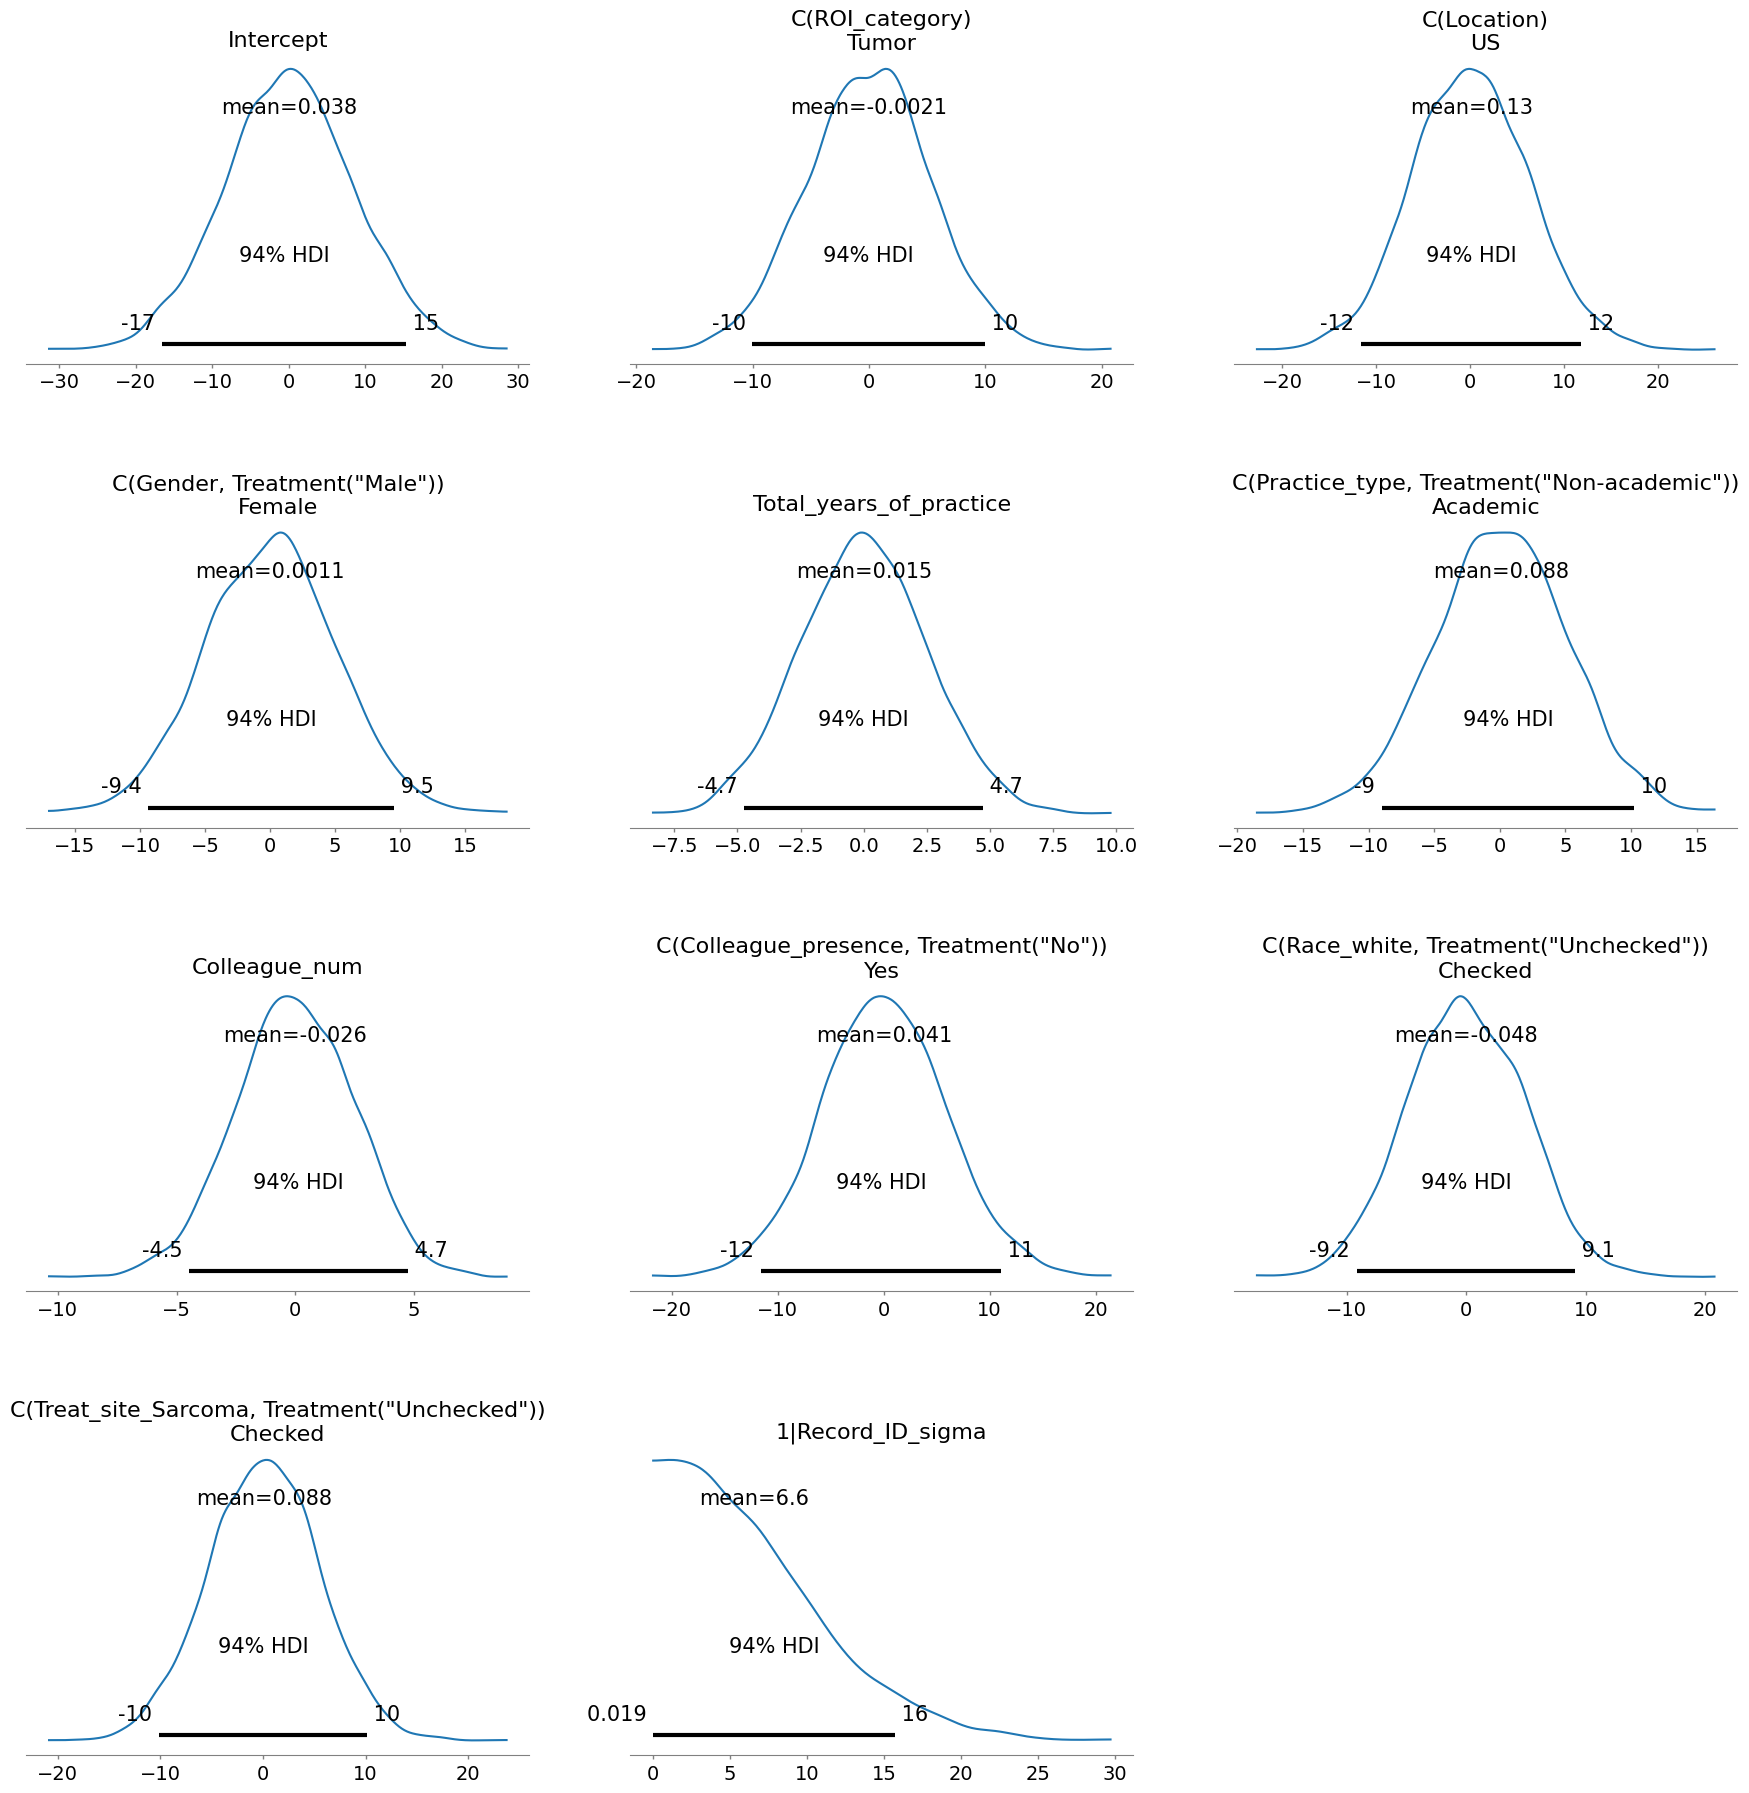

Modeling the probability that HD95_binary==1


HD95_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Head__Neck, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Head__Neck, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 5677 seconds.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Head__Neck, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


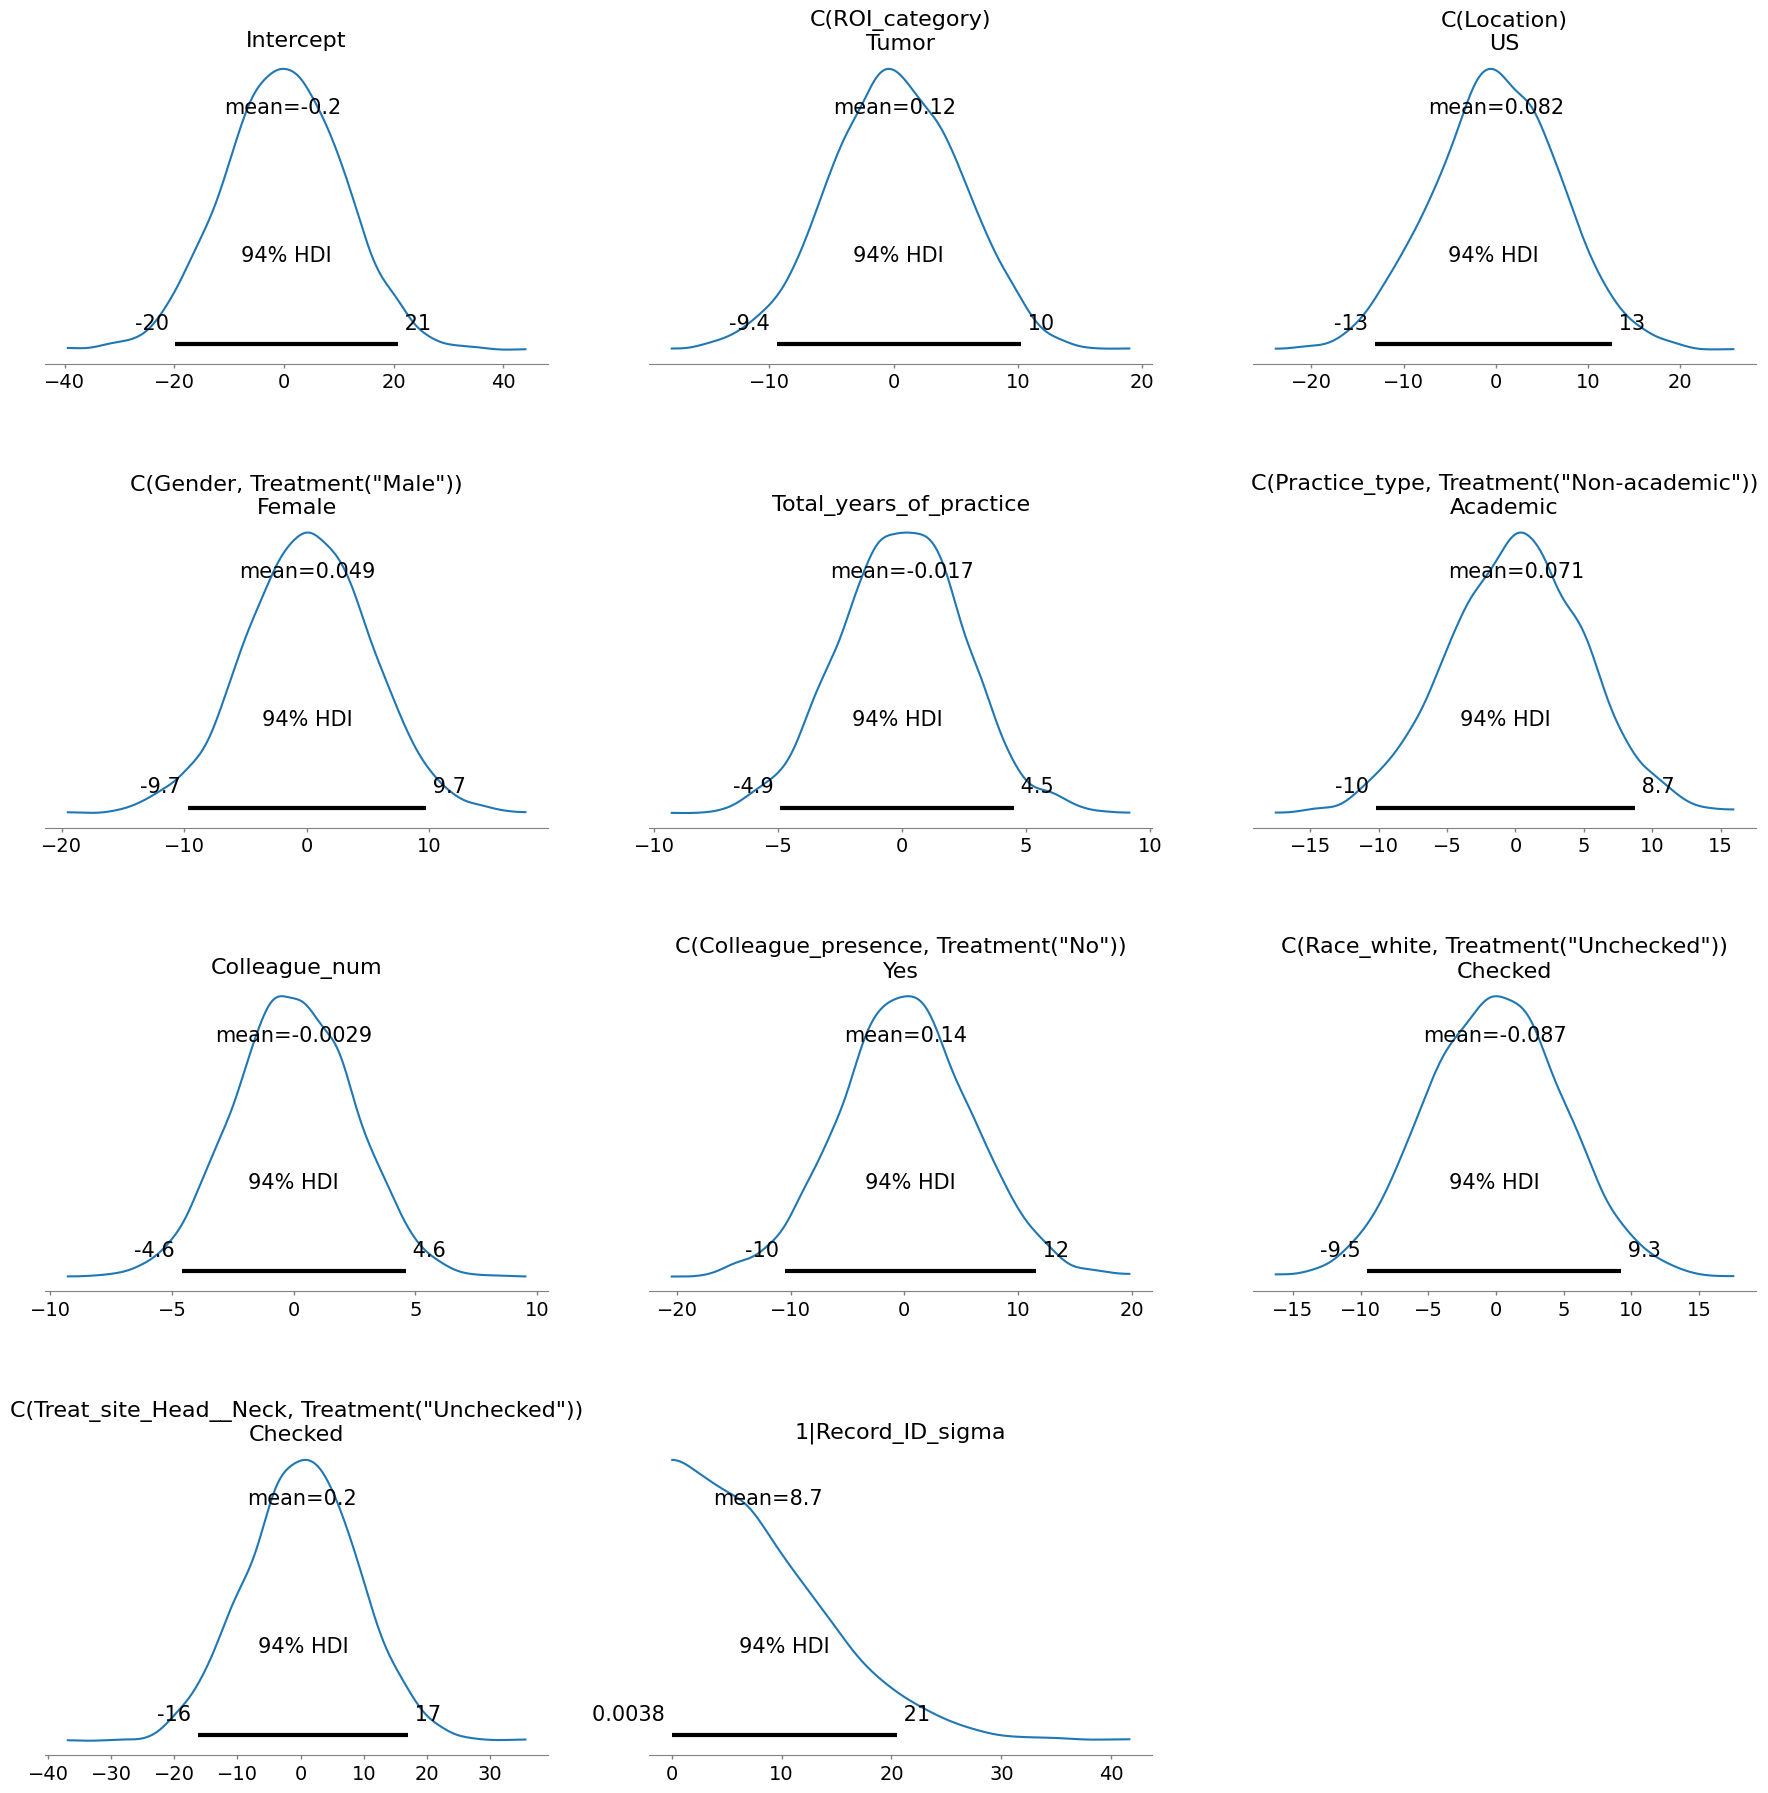

Modeling the probability that HD95_binary==1


HD95_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Gynecologic, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gynecologic, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 1948 seconds.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gynecologic, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


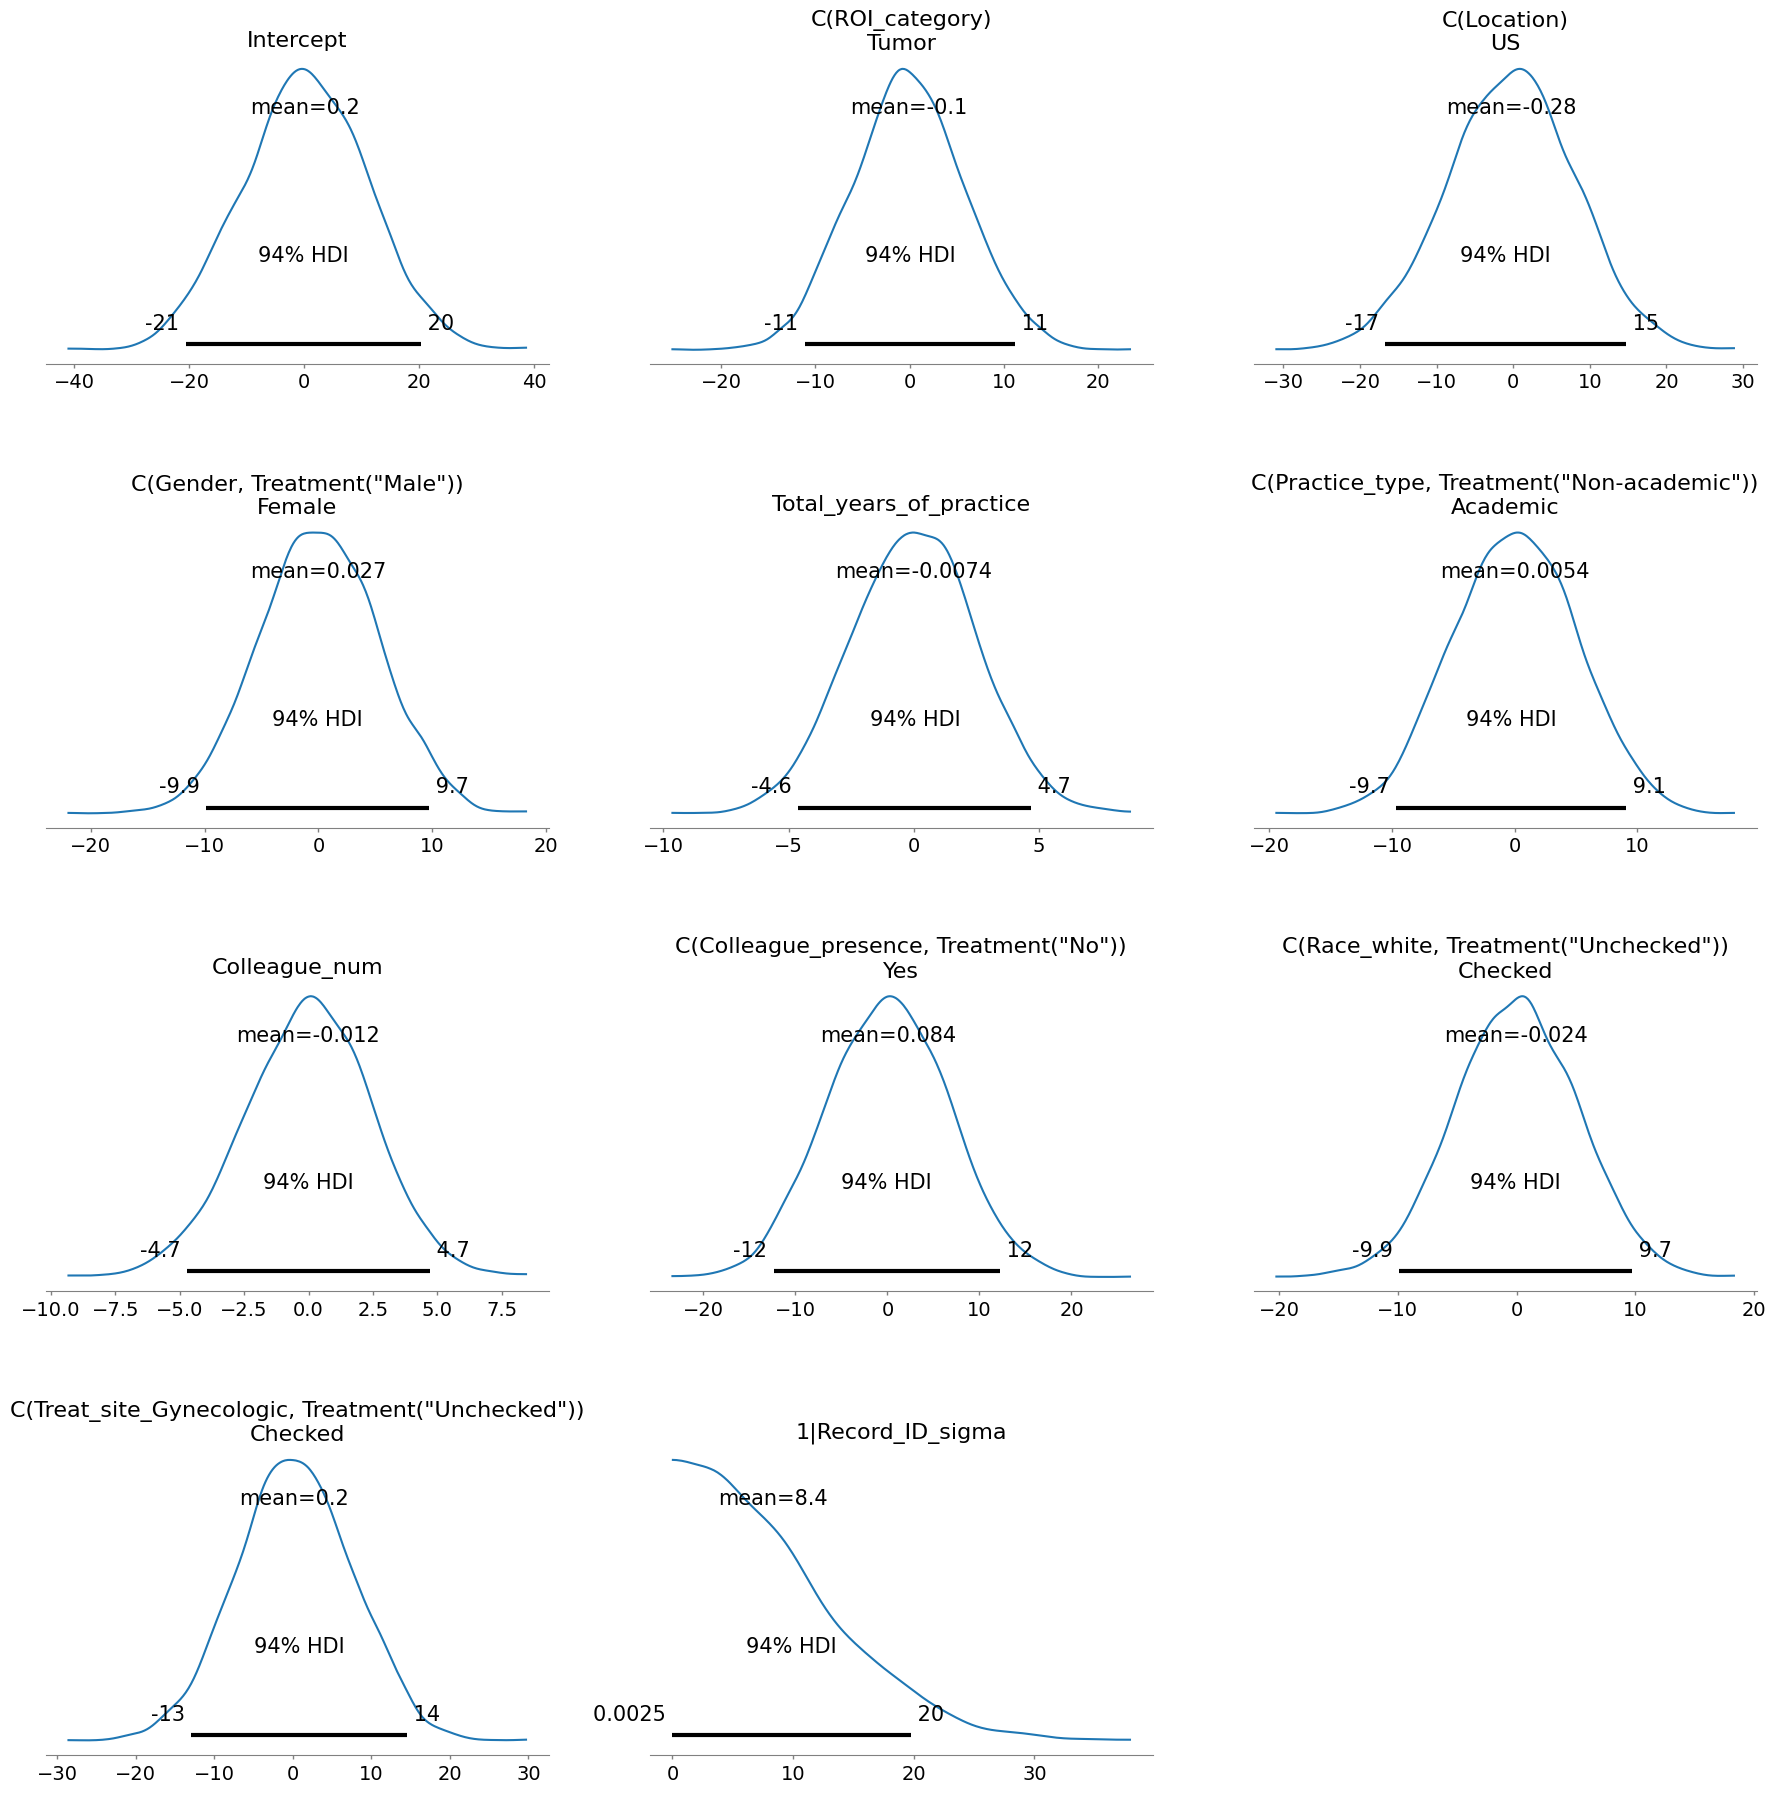

Modeling the probability that HD95_binary==1


HD95_binary ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male")) + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic")) + "Colleague_num" + C(Colleague_presence, Treatment("No")) + C(Race_white, Treatment("Unchecked")) + C(Treat_site_Gastrointestinal, Treatment("Unchecked"))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [Intercept, C(ROI_category), C(Location), C(Gender, Treatment("Male")), Total_years_of_practice, C(Practice_type, Treatment("Non-academic")), Colleague_num, C(Colleague_presence, Treatment("No")), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gastrointestinal, Treatment("Unchecked")), 1|Record_ID_sigma, 1|Record_ID_offset]


Sampling 4 chains for 1_500 tune and 10_000 draw iterations (6_000 + 40_000 draws total) took 1185 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [1|Record_ID_sigma, C(Colleague_presence, Treatment("No")), C(Gender, Treatment("Male")), C(Location), C(Practice_type, Treatment("Non-academic")), C(ROI_category), C(Race_white, Treatment("Unchecked")), C(Treat_site_Gastrointestinal, Treatment("Unchecked")), Colleague_num, Intercept, Total_years_of_practice]


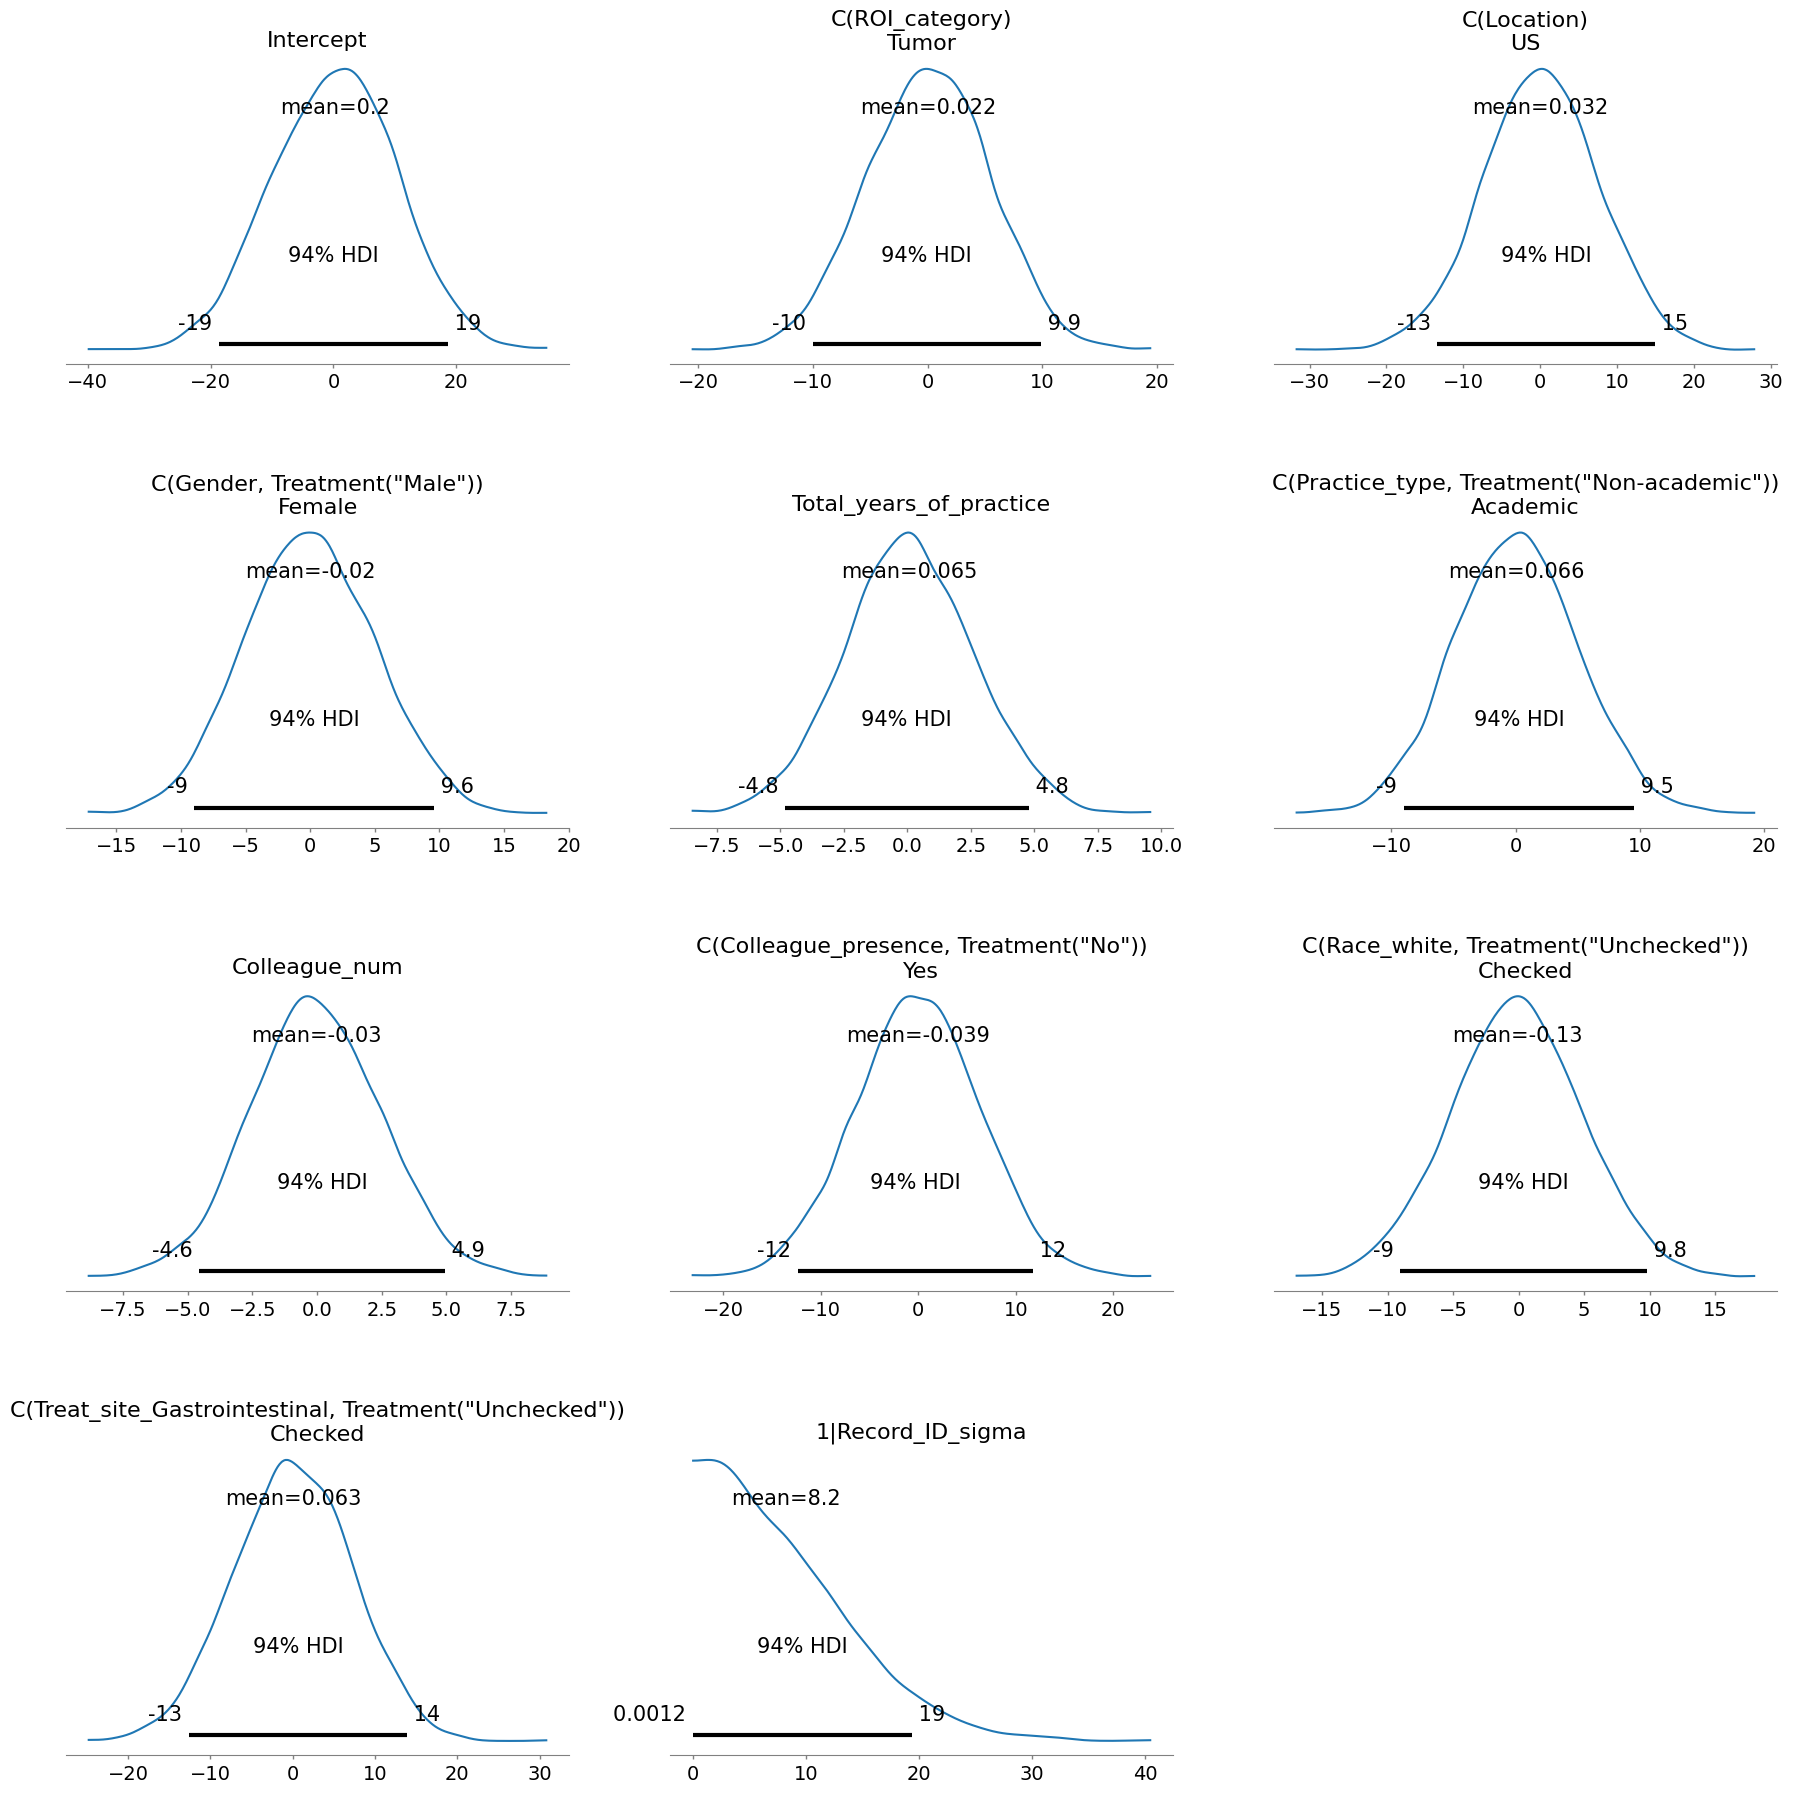

In [10]:
# Initializing an empty list to collect the results of the statistical analyses
pval_dfs = []

# Defining constants and configurations for Bayesian regression analysis
CSV_PATH = 'csv_files'
OUTPUT_PATH = 'bambi_binary_bayesian_regression_outputs'
SITE_LIST = ['Breast', 'Sarcoma', 'H&N', 'GYN', 'GI']
METRIC_LIST = ["DSC_binary", "SDSC_binary", "HD95_binary"]

# Function to preprocess the data, ensuring consistency across metrics and sites
def preprocess_data(df):
    df['Practice_type'] = np.where(df['Practice_type'] == 'Academic/university', 'Academic', 'Non-academic')
    # Removing columns that aren't required for the analysis
    remove_columns = [
    'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceOpportunity_to_win_gift_cards',
    'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceComparison_to_peersleaderboard',
    'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceAccess_to_educational_content',
    'Why_are_you_interested_in_participating_in_this_challenge__Select_all_that_apply_choiceAccess_to_contour_datasets_for_guidelineresearch_purposes',
    'How_did_you_first_hear_about_this_challenge__Select_all_that_apply',
    "Please_specify_Other",
    'What_year_of_residency_are_you_in',
    'What_year_did_you_start_practicing_graduate_residency' 
    ]
    
    df = df.drop(labels=remove_columns, axis=1)
    # Filtering data to keep only records of physicians
    df = df[df['What_is_your_profession'] == 'Radiation Oncologist/Clinical Oncologist']
    df.drop(['What_is_your_profession'], axis=1, inplace=True)
    # Filling NA values with median values
    df['Total_years_of_practice'] = df['Total_years_of_practice'].fillna(df['Total_years_of_practice'].median())
    df["Colleague_num"] = df["Colleague_num"].fillna(df["Colleague_num"].median())
    # Creating a new column for ROI category
    df['ROI_category'] = df['ROI'].apply(lambda x: 'Tumor' if 'TV' in str(x) else 'OAR')
    # Normalizing data using Z-score normalization
    for column in ["Total_years_of_practice", "Colleague_num"]:
        df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df

# Function to conduct Bayesian Regression analysis using Bambi
def run_bayesian_regression(site_df, metric, site):
    # Mapping sites to treatment values
    site_treat_mapping = {
    "Breast": "Treat_site_Breast",
    "Sarcoma": "Treat_site_Sarcoma",
    "H&N": "Treat_site_Head__Neck",
    "GYN": "Treat_site_Gynecologic",
    "GI": "Treat_site_Gastrointestinal"
}    

    site_treat = site_treat_mapping.get(site, "")
    formula = (metric + 
                   ' ~ C(ROI_category) + C(Location) + (1|"Record_ID") + C(Gender, Treatment("Male"))' +
                   ' + "Total_years_of_practice" + C(Practice_type, Treatment("Non-academic"))' + 
                   ' + "Colleague_num" + C(Colleague_presence, Treatment("No"))' + 
                   ' + C(Race_white, Treatment("Unchecked"))' + 
                   ' + C(' + site_treat + ', Treatment("Unchecked"))'
              )
    print(formula)
    
    # Defining and fitting the model using Bambi
    model_bayes = bmb.Model(formula, site_df, family="bernoulli")
    results = model_bayes.fit(draws=10000, cores=6, chains=4, tune=1500, random_seed=0) # real, long run time
    summary = az.summary(results, hdi_prob=0.89)
    summary = summary.reset_index().rename(columns={'index': 'Variable'})
    summary['Case'] = site
    summary['Metric'] = metric
    return results, summary, model_bayes

# Main loop to execute Bayesian regression for each metric and site
for metric in METRIC_LIST:
    for site in SITE_LIST:
        file_path = os.path.join(CSV_PATH, f"{site}.csv")
        if os.path.exists(file_path):
            site_df = pd.read_csv(file_path)
            site_df = preprocess_data(site_df)
            results, summary, model_bayes = run_bayesian_regression(site_df, metric, site)
            # Saving results to files
            az.to_netcdf(results, os.path.join(OUTPUT_PATH, f"{site}_{metric}.nc"))
            summary.to_csv(os.path.join(OUTPUT_PATH, f"{site}_{metric}_model_results.csv"), index=False)
            # Plotting and saving the priors
            model_bayes.plot_priors()
            plt.subplots_adjust(hspace=0.5)
            plt.savefig(os.path.join(OUTPUT_PATH, f"{site}_{metric}_priorplot.pdf"))
            plt.show()
            pval_dfs.append(summary)
        else:
            print(f"Error: {file_path} does not exist!")

# Consolidating and saving the final results
pval_df_final = pd.concat(pval_dfs, ignore_index=True)
pval_df_final.to_pickle(os.path.join(OUTPUT_PATH, 'pval_df_final.pkl'))


## Results Harmonization and Pivoting <a class="anchor" id="result"></a>
### Description
- Harmonizes variable names to ensure consistency across results.
- Structures the Bayesian regression results in a pivot table format


In [11]:
# Harmonizing variable names for clarity
mask = pval_df_final["Variable"].str.contains("Treat_site")
pval_df_final.loc[mask, "Variable"] = "Treat_site_checked"

# Removing rows containing variables with '|', specifically filtering out 'Record_ID'
df_filtered = pval_df_final[~pval_df_final['Variable'].str.contains('Record_ID')]

# Melt the dataframe to restructure it for the pivot operation
df_melted = df_filtered.melt(id_vars=["Case", "Metric", "Variable"], var_name="Statistic")

# Pivot the melted dataframe to get a clear view of statistics for each variable, case, and metric
df_pivot = df_melted.pivot_table(index=["Variable"], columns=["Case", "Metric", "Statistic"], values="value")

# Define desired statistics to retain
stats_to_keep = ['mean', 'hdi_5.5%', 'hdi_94.5%']

# Filter the columns based on the desired statistics
cols = list(df_pivot.columns)
cols_to_keep = [col for col in cols if col[2] in stats_to_keep]
df_pivot = df_pivot[cols_to_keep]

# Reorder columns for better readability
df_pivot = df_pivot.reindex(columns=['mean', 'hdi_5.5%', 'hdi_94.5%'], level='Statistic')


In [12]:
# Displaying the Pivot Table
df_pivot

Case                                                   Breast           \
Metric                                             DSC_binary            
Statistic                                                mean hdi_5.5%   
Variable                                                                 
C(Colleague_presence, Treatment("No"))[Yes]             0.279   -0.207   
C(Gender, Treatment("Male"))[Female]                   -0.102   -0.512   
C(Location)[US]                                        -0.537   -1.146   
C(Practice_type, Treatment("Non-academic"))[Aca...     -0.371   -0.738   
C(ROI_category)[Tumor]                                 -0.972   -1.293   
C(Race_white, Treatment("Unchecked"))[Checked]         -0.301   -0.676   
Colleague_num                                          -0.021   -0.220   
Intercept                                               0.902    0.078   
Total_years_of_practice                                -0.062   -0.250   
Treat_site_checked                                      0.529   -0.143   

Case                                                                      \
Metric                                                       HD95_binary   
Statistic                                          hdi_94.5%        mean   
Variable                                                                   
C(Colleague_presence, Treatment("No"))[Yes]            0.774       0.079   
C(Gender, Treatment("Male"))[Female]                   0.307      -0.228   
C(Location)[US]                                        0.061      -0.368   
C(Practice_type, Treatment("Non-academic"))[Aca...     0.018       0.067   
C(ROI_category)[Tumor]                                -0.651      -0.789   
C(Race_white, Treatment("Unchecked"))[Checked]         0.085      -0.069   
Colleague_num                                          0.176       0.002   
Intercept                                              1.687       0.194   
Total_years_of_practice                                0.125       0.013   
Treat_site_checked                                     1.198       0.428   

Case                                                                   \
Metric                                                                  
Statistic                                          hdi_5.5% hdi_94.5%   
Variable                                                                
C(Colleague_presence, Treatment("No"))[Yes]          -0.358     0.496   
C(Gender, Treatment("Male"))[Female]                 -0.590     0.123   
C(Location)[US]                                      -0.887     0.158   
C(Practice_type, Treatment("Non-academic"))[Aca...   -0.255     0.400   
C(ROI_category)[Tumor]                               -1.080    -0.500   
C(Race_white, Treatment("Unchecked"))[Checked]       -0.398     0.253   
Colleague_num                                        -0.171     0.174   
Intercept                                            -0.533     0.905   
Total_years_of_practice                              -0.155     0.171   
Treat_site_checked                                   -0.175     1.017   

Case                                                                     \
Metric                                             SDSC_binary            
Statistic                                                 mean hdi_5.5%   
Variable                                                                  
C(Colleague_presence, Treatment("No"))[Yes]              0.161   -0.340   
C(Gender, Treatment("Male"))[Female]                    -0.301   -0.693   
C(Location)[US]                                         -0.330   -0.950   
C(Practice_type, Treatment("Non-academic"))[Aca...      -0.374   -0.747   
C(ROI_category)[Tumor]                                  -1.235   -1.541   
C(Race_white, Treatment("Unchecked"))[Checked]          -0.169   -0.543   
Colleague_num                                           -0.032   -0.229   
Intercept                                         

In [13]:
# Create a new column with absolute values of the 'mean' column to facilitate sorting
pval_df_final['abs_numeric_column'] = pval_df_final['mean'].abs()

# Sort by 'Case' and the absolute value of the 'mean' column
pval_df_final.sort_values(by=['Case', 'abs_numeric_column'], ascending=[True, False], inplace=True)


In [14]:
# Filtering and displaying records with significant values for the 'DSC_binary' metric
dsc_significant = pval_df_final[
    ((pval_df_final['hdi_5.5%'] > 0) | (pval_df_final['hdi_94.5%'] < 0)) &
    (~pval_df_final['Variable'].str.contains('Record_ID')) &
    (pval_df_final['Variable'] != 'Intercept') &
    (pval_df_final['Metric'] == 'DSC_binary')
]
dsc_significant


Variable   mean     sd  hdi_5.5%  \
1                            C(ROI_category)[Tumor] -0.972  0.201    -1.293   
263                          C(ROI_category)[Tumor] -2.953  0.976    -4.441   
269     C(Colleague_presence, Treatment("No"))[Yes]  2.214  1.403     0.033   
159                          C(ROI_category)[Tumor] -1.004  0.241    -1.388   
166  C(Race_white, Treatment("Unchecked"))[Checked]  0.661  0.412     0.016   
106                          C(ROI_category)[Tumor] -1.044  0.543    -1.906   

     hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat     Case  \
1       -0.651      0.001    0.001   39951.0   24478.0    1.0   Breast   
263     -1.362      0.004    0.003   54623.0   28418.0    1.0       GI   
269      4.433      0.008    0.007   31745.0   22070.0    1.0       GI   
159     -0.620      0.001    0.001   65671.0   30350.0    1.0      H&N   
166      1.327      0.002    0.002   32625.0   27214.0    1.0      H&N   
106     -0.190      0.004    0.003   21729.0   17369.0    1.0  Sarcoma   

         Metric  abs_numeric_column  
1    DSC_binary               0.972  
263  DSC_binary               2.953  
269  DSC_binary               2.214  
159  DSC_binary               1.004  
166  DSC_binary               0.661  
106  DSC_binary               1.044

In [15]:
# Filtering and displaying records with significant values for the 'SDSC_binary' metric
sdsc_significant = pval_df_final[
    ((pval_df_final['hdi_5.5%'] > 0) | (pval_df_final['hdi_94.5%'] < 0)) &
    (~pval_df_final['Variable'].str.contains('Record_ID')) &
    (pval_df_final['Variable'] != 'Intercept') &
    (pval_df_final['Metric'] == 'SDSC_binary')
]
sdsc_significant


Variable   mean     sd  \
291                             C(ROI_category)[Tumor] -1.235  0.198   
514  C(Practice_type, Treatment("Non-academic"))[Ac... -1.304  0.786   
449                             C(ROI_category)[Tumor] -0.374  0.239   
396                             C(ROI_category)[Tumor] -2.741  0.806   

     hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  \
291    -1.541     -0.908      0.001    0.001   63876.0   28492.0    1.0   
514    -2.524     -0.041      0.007    0.006   14715.0   10401.0    1.0   
449    -0.768     -0.002      0.001    0.001   50955.0   27532.0    1.0   
396    -3.967     -1.440      0.006    0.004   17377.0   21681.0    1.0   

        Case       Metric  abs_numeric_column  
291   Breast  SDSC_binary               1.235  
514      GYN  SDSC_binary               1.304  
449      H&N  SDSC_binary               0.374  
396  Sarcoma  SDSC_binary               2.741

In [16]:
# Filtering and displaying records with significant values for the 'HD95_binary' metric
hd_significant = pval_df_final[
    ((pval_df_final['hdi_5.5%'] > 0) | (pval_df_final['hdi_94.5%'] < 0)) &
    (~pval_df_final['Variable'].str.contains('Record_ID')) &
    (pval_df_final['Variable'] != 'Intercept') &
    (pval_df_final['Metric'] == 'HD95_binary')
]
hd_significant


Variable   mean     sd  hdi_5.5%  hdi_94.5%  \
581                C(ROI_category)[Tumor] -0.789  0.182    -1.080     -0.500   
845  C(Gender, Treatment("Male"))[Female]  3.494  1.623     0.954      5.938   
848                         Colleague_num  2.732  1.391     0.511      4.887   
800                C(ROI_category)[Tumor]  1.121  0.621     0.128      2.106   
739                C(ROI_category)[Tumor] -0.487  0.227    -0.841     -0.116   
689               Total_years_of_practice  1.156  0.598     0.246      2.084   

     mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat     Case       Metric  \
581      0.001    0.001   35793.0   22164.0    1.0   Breast  HD95_binary   
845      0.020    0.018    8259.0    5344.0    1.0       GI  HD95_binary   
848      0.013    0.009   11423.0   11197.0    1.0       GI  HD95_binary   
800      0.003    0.002   63090.0   26425.0    1.0      GYN  HD95_binary   
739      0.001    0.001   65404.0   28231.0    1.0      H&N  HD95_binary   
689      0.004    0.003   28209.0   20462.0    1.0  Sarcoma  HD95_binary   

     abs_numeric_column  
581               0.789  
845               3.494  
848               2.732  
800               1.121  
739               0.487  
689               1.156